In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.networks.nets import UNETR
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import logging
logging.disable(logging.WARNING)

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpfpinde6d


In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)

torch.multiprocessing.set_sharing_strategy('file_system')

In [ ]:
#frequncy unetr pretrain on word

In [5]:
#pretrain on word
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=80,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=20, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=20, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|██████████████████████████| 20/20 [00:33<00:00,  1.65s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_onlyconcat_fold0_best_metric_model.pth")))

Training (79 / 25000 Steps) (loss=2.72518): 100%|█| 80/80 [00:46<00:00,  1.72it/
Training (159 / 25000 Steps) (loss=2.50305): 100%|█| 80/80 [00:43<00:00,  1.85it
Training (239 / 25000 Steps) (loss=2.37845): 100%|█| 80/80 [00:42<00:00,  1.86it
Training (319 / 25000 Steps) (loss=2.29125): 100%|█| 80/80 [00:43<00:00,  1.85it
Training (399 / 25000 Steps) (loss=2.14617): 100%|█| 80/80 [00:43<00:00,  1.86it
Training (479 / 25000 Steps) (loss=2.03392): 100%|█| 80/80 [00:43<00:00,  1.86it
Training (500 / 25000 Steps) (loss=2.06022):  25%|▎| 20/80 [00:14<00:28,  2.09it
Validate (480 / 10 Steps): 100%|████████████████| 20/20 [00:04<00:00,  4.24it/s]
Training (500 / 25000 Steps) (loss=2.06022):  26%|▎| 21/80 [00:22<02:42,  2.75s/

Model Was Saved ! Current Best Avg. Dice: 0.4188407361507416 Current Avg. Dice: 0.4188407361507416


Training (559 / 25000 Steps) (loss=1.99394): 100%|█| 80/80 [00:50<00:00,  1.57it
Training (639 / 25000 Steps) (loss=1.87331): 100%|█| 80/80 [00:43<00:00,  1.84it
Training (719 / 25000 Steps) (loss=1.82352): 100%|█| 80/80 [00:42<00:00,  1.86it
Training (799 / 25000 Steps) (loss=1.72755): 100%|█| 80/80 [00:42<00:00,  1.86it
Training (879 / 25000 Steps) (loss=1.67416): 100%|█| 80/80 [00:43<00:00,  1.86it
Training (959 / 25000 Steps) (loss=1.57086): 100%|█| 80/80 [00:42<00:00,  1.87it
Training (1000 / 25000 Steps) (loss=1.64379):  50%|▌| 40/80 [00:24<00:18,  2.11i
Validate (960 / 10 Steps): 100%|████████████████| 20/20 [00:04<00:00,  4.36it/s]
Training (1000 / 25000 Steps) (loss=1.64379):  51%|▌| 41/80 [00:32<01:51,  2.86s

Model Was Saved ! Current Best Avg. Dice: 0.48301181197166443 Current Avg. Dice: 0.48301181197166443


Training (1039 / 25000 Steps) (loss=1.61752): 100%|█| 80/80 [00:51<00:00,  1.56i
Training (1119 / 25000 Steps) (loss=1.55602): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (1199 / 25000 Steps) (loss=1.43712): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (1279 / 25000 Steps) (loss=1.47177): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (1359 / 25000 Steps) (loss=1.33539): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (1439 / 25000 Steps) (loss=1.24119): 100%|█| 80/80 [00:43<00:00,  1.86i
Training (1500 / 25000 Steps) (loss=1.50929):  75%|▊| 60/80 [00:33<00:09,  2.15i
Validate (1440 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.38it/s]
Training (1500 / 25000 Steps) (loss=1.50929):  76%|▊| 61/80 [00:37<00:34,  1.83s

Model Was Not Saved ! Current Best Avg. Dice: 0.48301181197166443 Current Avg. Dice: 0.45138341188430786


Training (1519 / 25000 Steps) (loss=1.26878): 100%|█| 80/80 [00:47<00:00,  1.69i
Training (1599 / 25000 Steps) (loss=1.22896): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (1679 / 25000 Steps) (loss=1.20313): 100%|█| 80/80 [00:42<00:00,  1.86i
Training (1759 / 25000 Steps) (loss=1.24147): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (1839 / 25000 Steps) (loss=1.13924): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (1919 / 25000 Steps) (loss=1.15338): 100%|█| 80/80 [00:42<00:00,  1.86i
Training (1999 / 25000 Steps) (loss=1.19378): 100%|█| 80/80 [00:43<00:00,  1.85i
Validate (2000 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.37it/s]
Training (2000 / 25000 Steps) (loss=1.27002):   1%| | 1/80 [00:13<17:15, 13.11s/

Model Was Saved ! Current Best Avg. Dice: 0.4964745044708252 Current Avg. Dice: 0.4964745044708252


Training (2079 / 25000 Steps) (loss=1.17988): 100%|█| 80/80 [00:51<00:00,  1.57i
Training (2159 / 25000 Steps) (loss=1.20610): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (2239 / 25000 Steps) (loss=1.12476): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (2319 / 25000 Steps) (loss=1.07051): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (2399 / 25000 Steps) (loss=1.08028): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (2479 / 25000 Steps) (loss=1.20178): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (2500 / 25000 Steps) (loss=1.03595):  25%|▎| 20/80 [00:14<00:27,  2.17i
Validate (2480 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.37it/s]
Training (2500 / 25000 Steps) (loss=1.03595):  26%|▎| 21/80 [00:23<03:09,  3.20s

Model Was Saved ! Current Best Avg. Dice: 0.5756785273551941 Current Avg. Dice: 0.5756785273551941


Training (2559 / 25000 Steps) (loss=0.97171): 100%|█| 80/80 [00:51<00:00,  1.56i
Training (2639 / 25000 Steps) (loss=1.03759): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (2719 / 25000 Steps) (loss=0.98311): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (2799 / 25000 Steps) (loss=1.17916): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (2879 / 25000 Steps) (loss=0.94379): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (2959 / 25000 Steps) (loss=0.94902): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (3000 / 25000 Steps) (loss=0.97036):  50%|▌| 40/80 [00:23<00:18,  2.17i
Validate (2960 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.47it/s]
Training (3000 / 25000 Steps) (loss=0.97036):  51%|▌| 41/80 [00:31<01:49,  2.80s

Model Was Saved ! Current Best Avg. Dice: 0.5846927762031555 Current Avg. Dice: 0.5846927762031555


Training (3039 / 25000 Steps) (loss=1.08248): 100%|█| 80/80 [00:49<00:00,  1.60i
Training (3119 / 25000 Steps) (loss=0.97038): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3199 / 25000 Steps) (loss=1.02850): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (3279 / 25000 Steps) (loss=0.99876): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3359 / 25000 Steps) (loss=1.02284): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (3439 / 25000 Steps) (loss=1.05472): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3500 / 25000 Steps) (loss=0.95646):  75%|▊| 60/80 [00:32<00:09,  2.19i
Validate (3440 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.43it/s]
Training (3500 / 25000 Steps) (loss=0.95646):  76%|▊| 61/80 [00:40<00:53,  2.84s

Model Was Saved ! Current Best Avg. Dice: 0.6372063755989075 Current Avg. Dice: 0.6372063755989075


Training (3519 / 25000 Steps) (loss=0.94895): 100%|█| 80/80 [00:50<00:00,  1.59i
Training (3599 / 25000 Steps) (loss=0.89357): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3679 / 25000 Steps) (loss=0.98637): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (3759 / 25000 Steps) (loss=1.03451): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3839 / 25000 Steps) (loss=0.85358): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (3919 / 25000 Steps) (loss=0.89866): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (3999 / 25000 Steps) (loss=0.89969): 100%|█| 80/80 [00:42<00:00,  1.89i
Validate (4000 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.39it/s]
Training (4000 / 25000 Steps) (loss=0.81642):   1%| | 1/80 [00:13<18:24, 13.98s/

Model Was Saved ! Current Best Avg. Dice: 0.6543552875518799 Current Avg. Dice: 0.6543552875518799


Training (4079 / 25000 Steps) (loss=0.91616): 100%|█| 80/80 [00:51<00:00,  1.56i
Training (4159 / 25000 Steps) (loss=0.89924): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (4239 / 25000 Steps) (loss=0.99893): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (4319 / 25000 Steps) (loss=0.90417): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (4399 / 25000 Steps) (loss=0.98315): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (4479 / 25000 Steps) (loss=0.83592): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (4500 / 25000 Steps) (loss=0.90608):  25%|▎| 20/80 [00:14<00:27,  2.16i
Validate (4480 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.18it/s]
Training (4500 / 25000 Steps) (loss=0.90608):  26%|▎| 21/80 [00:22<02:51,  2.91s

Model Was Saved ! Current Best Avg. Dice: 0.6616917848587036 Current Avg. Dice: 0.6616917848587036


Training (4559 / 25000 Steps) (loss=1.11399): 100%|█| 80/80 [00:50<00:00,  1.58i
Training (4639 / 25000 Steps) (loss=0.79573): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (4719 / 25000 Steps) (loss=0.90148): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (4799 / 25000 Steps) (loss=0.93875): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (4879 / 25000 Steps) (loss=0.85683): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (4959 / 25000 Steps) (loss=0.86852): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (5000 / 25000 Steps) (loss=0.80285):  50%|▌| 40/80 [00:23<00:18,  2.18i
Validate (4960 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.39it/s]
Training (5000 / 25000 Steps) (loss=0.80285):  51%|▌| 41/80 [00:32<01:53,  2.92s

Model Was Saved ! Current Best Avg. Dice: 0.6783121228218079 Current Avg. Dice: 0.6783121228218079


Training (5039 / 25000 Steps) (loss=0.90140): 100%|█| 80/80 [00:50<00:00,  1.58i
Training (5119 / 25000 Steps) (loss=0.77738): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (5199 / 25000 Steps) (loss=1.05808): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (5279 / 25000 Steps) (loss=0.83503): 100%|█| 80/80 [00:42<00:00,  1.87i
Training (5359 / 25000 Steps) (loss=0.85212): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (5439 / 25000 Steps) (loss=0.80854): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (5500 / 25000 Steps) (loss=0.76381):  75%|▊| 60/80 [00:33<00:09,  2.19i
Validate (5440 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.44it/s]
Training (5500 / 25000 Steps) (loss=0.76381):  76%|▊| 61/80 [00:41<00:54,  2.85s

Model Was Saved ! Current Best Avg. Dice: 0.724774181842804 Current Avg. Dice: 0.724774181842804


Training (5519 / 25000 Steps) (loss=1.23947): 100%|█| 80/80 [00:50<00:00,  1.59i
Training (5599 / 25000 Steps) (loss=0.84241): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (5679 / 25000 Steps) (loss=0.82838): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (5759 / 25000 Steps) (loss=0.72744): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (5839 / 25000 Steps) (loss=0.69793): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (5919 / 25000 Steps) (loss=0.79999): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (5999 / 25000 Steps) (loss=0.78063): 100%|█| 80/80 [00:42<00:00,  1.89i
Validate (6000 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.34it/s]
Training (6000 / 25000 Steps) (loss=0.78711):   1%| | 1/80 [00:09<12:57,  9.84s/

Model Was Not Saved ! Current Best Avg. Dice: 0.724774181842804 Current Avg. Dice: 0.7107486724853516


Training (6079 / 25000 Steps) (loss=1.31980): 100%|█| 80/80 [00:46<00:00,  1.71i
Training (6159 / 25000 Steps) (loss=0.84178): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (6239 / 25000 Steps) (loss=0.92879): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (6319 / 25000 Steps) (loss=0.81320): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (6399 / 25000 Steps) (loss=0.83041): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (6479 / 25000 Steps) (loss=0.86946): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (6500 / 25000 Steps) (loss=0.71763):  25%|▎| 20/80 [00:14<00:27,  2.17i
Validate (6480 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.47it/s]
Training (6500 / 25000 Steps) (loss=0.71763):  26%|▎| 21/80 [00:22<02:42,  2.76s

Model Was Saved ! Current Best Avg. Dice: 0.751398503780365 Current Avg. Dice: 0.751398503780365


Training (6559 / 25000 Steps) (loss=0.88782): 100%|█| 80/80 [00:49<00:00,  1.60i
Training (6639 / 25000 Steps) (loss=0.87336): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (6719 / 25000 Steps) (loss=0.86160): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (6799 / 25000 Steps) (loss=0.88864): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (6879 / 25000 Steps) (loss=0.80978): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (6959 / 25000 Steps) (loss=0.87827): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7000 / 25000 Steps) (loss=0.65832):  50%|▌| 40/80 [00:23<00:18,  2.18i
Validate (6960 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.37it/s]
Training (7000 / 25000 Steps) (loss=0.65832):  51%|▌| 41/80 [00:28<01:11,  1.84s

Model Was Not Saved ! Current Best Avg. Dice: 0.751398503780365 Current Avg. Dice: 0.7454125285148621


Training (7039 / 25000 Steps) (loss=0.83909): 100%|█| 80/80 [00:46<00:00,  1.71i
Training (7119 / 25000 Steps) (loss=0.77620): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7199 / 25000 Steps) (loss=0.84323): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (7279 / 25000 Steps) (loss=0.70069): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7359 / 25000 Steps) (loss=0.74309): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (7439 / 25000 Steps) (loss=0.70498): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (7500 / 25000 Steps) (loss=0.81352):  75%|▊| 60/80 [00:33<00:09,  2.18i
Validate (7440 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.45it/s]
Training (7500 / 25000 Steps) (loss=0.81352):  76%|▊| 61/80 [00:40<00:52,  2.76s

Model Was Saved ! Current Best Avg. Dice: 0.7629092931747437 Current Avg. Dice: 0.7629092931747437


Training (7519 / 25000 Steps) (loss=0.76166): 100%|█| 80/80 [00:50<00:00,  1.60i
Training (7599 / 25000 Steps) (loss=0.75412): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7679 / 25000 Steps) (loss=0.59322): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7759 / 25000 Steps) (loss=0.81077): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (7839 / 25000 Steps) (loss=0.83525): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7919 / 25000 Steps) (loss=0.63278): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (7999 / 25000 Steps) (loss=0.83890): 100%|█| 80/80 [00:42<00:00,  1.89i
Validate (8000 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.42it/s]
Training (8000 / 25000 Steps) (loss=0.65203):   1%| | 1/80 [00:13<17:41, 13.44s/

Model Was Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7852468490600586


Training (8079 / 25000 Steps) (loss=0.71939): 100%|█| 80/80 [00:50<00:00,  1.59i
Training (8159 / 25000 Steps) (loss=0.81470): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (8239 / 25000 Steps) (loss=0.75287): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (8319 / 25000 Steps) (loss=0.65753): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (8399 / 25000 Steps) (loss=0.79243): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (8479 / 25000 Steps) (loss=0.62787): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (8500 / 25000 Steps) (loss=0.77511):  25%|▎| 20/80 [00:14<00:27,  2.16i
Validate (8480 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.32it/s]
Training (8500 / 25000 Steps) (loss=0.77511):  26%|▎| 21/80 [00:18<01:49,  1.86s

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7724653482437134


Training (8559 / 25000 Steps) (loss=0.82240): 100%|█| 80/80 [00:46<00:00,  1.70i
Training (8639 / 25000 Steps) (loss=0.74771): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (8719 / 25000 Steps) (loss=0.75586): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (8799 / 25000 Steps) (loss=0.72518): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (8879 / 25000 Steps) (loss=0.75247): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (8959 / 25000 Steps) (loss=0.71519): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (9000 / 25000 Steps) (loss=0.83147):  50%|▌| 40/80 [00:23<00:18,  2.18i
Validate (8960 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.40it/s]
Training (9000 / 25000 Steps) (loss=0.83147):  51%|▌| 41/80 [00:28<01:11,  1.83s

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7689118385314941


Training (9039 / 25000 Steps) (loss=0.80089): 100%|█| 80/80 [00:46<00:00,  1.71i
Training (9119 / 25000 Steps) (loss=0.76926): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (9199 / 25000 Steps) (loss=0.62128): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9279 / 25000 Steps) (loss=0.55744): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9359 / 25000 Steps) (loss=0.71404): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (9439 / 25000 Steps) (loss=0.63642): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9500 / 25000 Steps) (loss=0.88585):  75%|▊| 60/80 [00:33<00:09,  2.15i
Validate (9440 / 10 Steps): 100%|███████████████| 20/20 [00:04<00:00,  4.40it/s]
Training (9500 / 25000 Steps) (loss=0.88585):  76%|▊| 61/80 [00:37<00:34,  1.83s

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7666428685188293


Training (9519 / 25000 Steps) (loss=0.79974): 100%|█| 80/80 [00:46<00:00,  1.70i
Training (9599 / 25000 Steps) (loss=0.67991): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9679 / 25000 Steps) (loss=0.67420): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9759 / 25000 Steps) (loss=0.58010): 100%|█| 80/80 [00:42<00:00,  1.90i
Training (9839 / 25000 Steps) (loss=0.64860): 100%|█| 80/80 [00:42<00:00,  1.89i
Training (9919 / 25000 Steps) (loss=0.80990): 100%|█| 80/80 [00:42<00:00,  1.88i
Training (9999 / 25000 Steps) (loss=0.66016): 100%|█| 80/80 [00:42<00:00,  1.89i
Validate (10000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.41it/s]
Training (10000 / 25000 Steps) (loss=0.74358):   1%| | 1/80 [00:09<12:55,  9.81s

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7764042019844055


Training (10079 / 25000 Steps) (loss=0.70003): 100%|█| 80/80 [00:46<00:00,  1.71
Training (10159 / 25000 Steps) (loss=0.55752): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10239 / 25000 Steps) (loss=0.72560): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10319 / 25000 Steps) (loss=0.64421): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10399 / 25000 Steps) (loss=0.58400): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10479 / 25000 Steps) (loss=0.64752): 100%|█| 80/80 [00:42<00:00,  1.90
Training (10500 / 25000 Steps) (loss=0.49433):  25%|▎| 20/80 [00:14<00:30,  2.00
Validate (10480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.46it/s]
Training (10500 / 25000 Steps) (loss=0.49433):  26%|▎| 21/80 [00:19<01:48,  1.84

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7711633443832397


Training (10559 / 25000 Steps) (loss=0.65061): 100%|█| 80/80 [00:46<00:00,  1.71
Training (10639 / 25000 Steps) (loss=0.56501): 100%|█| 80/80 [00:42<00:00,  1.87
Training (10719 / 25000 Steps) (loss=0.83903): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10799 / 25000 Steps) (loss=0.65168): 100%|█| 80/80 [00:42<00:00,  1.89
Training (10879 / 25000 Steps) (loss=0.76357): 100%|█| 80/80 [00:42<00:00,  1.90
Training (10959 / 25000 Steps) (loss=0.59500): 100%|█| 80/80 [00:42<00:00,  1.88
Training (11000 / 25000 Steps) (loss=0.70184):  50%|▌| 40/80 [00:23<00:18,  2.18
Validate (10960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.41it/s]
Training (11000 / 25000 Steps) (loss=0.70184):  51%|▌| 41/80 [00:28<01:11,  1.83

Model Was Not Saved ! Current Best Avg. Dice: 0.7852468490600586 Current Avg. Dice: 0.7701929211616516


Training (11039 / 25000 Steps) (loss=0.75063): 100%|█| 80/80 [00:46<00:00,  1.71
Training (11119 / 25000 Steps) (loss=0.90633): 100%|█| 80/80 [00:42<00:00,  1.89
Training (11199 / 25000 Steps) (loss=0.61336): 100%|█| 80/80 [00:42<00:00,  1.90
Training (11279 / 25000 Steps) (loss=0.76654): 100%|█| 80/80 [00:42<00:00,  1.89
Training (11359 / 25000 Steps) (loss=0.69571): 100%|█| 80/80 [00:42<00:00,  1.88
Training (11439 / 25000 Steps) (loss=0.72389): 100%|█| 80/80 [00:42<00:00,  1.89
Training (11500 / 25000 Steps) (loss=0.63144):  75%|▊| 60/80 [00:33<00:09,  2.19
Validate (11440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.44it/s]
Training (11500 / 25000 Steps) (loss=0.63144):  76%|▊| 61/80 [00:40<00:52,  2.76

Model Was Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8280547857284546


Training (11519 / 25000 Steps) (loss=0.72411): 100%|█| 80/80 [00:49<00:00,  1.60
Training (11599 / 25000 Steps) (loss=0.74464): 100%|█| 80/80 [00:42<00:00,  1.90
Training (11679 / 25000 Steps) (loss=0.76329): 100%|█| 80/80 [00:42<00:00,  1.89
Training (11759 / 25000 Steps) (loss=0.56320): 100%|█| 80/80 [00:42<00:00,  1.90
Training (11839 / 25000 Steps) (loss=0.64484): 100%|█| 80/80 [00:42<00:00,  1.89
Training (11919 / 25000 Steps) (loss=0.79872): 100%|█| 80/80 [00:42<00:00,  1.87
Training (11999 / 25000 Steps) (loss=0.72305): 100%|█| 80/80 [00:42<00:00,  1.89
Validate (12000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.45it/s]
Training (12000 / 25000 Steps) (loss=0.64143):   1%| | 1/80 [00:09<12:41,  9.64s

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8151623010635376


Training (12079 / 25000 Steps) (loss=0.78768): 100%|█| 80/80 [00:46<00:00,  1.72
Training (12159 / 25000 Steps) (loss=0.70515): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12239 / 25000 Steps) (loss=0.65827): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12319 / 25000 Steps) (loss=0.60794): 100%|█| 80/80 [00:42<00:00,  1.90
Training (12399 / 25000 Steps) (loss=0.76596): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12479 / 25000 Steps) (loss=0.66234): 100%|█| 80/80 [00:43<00:00,  1.84
Training (12500 / 25000 Steps) (loss=0.57557):  25%|▎| 20/80 [00:14<00:27,  2.16
Validate (12480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.44it/s]
Training (12500 / 25000 Steps) (loss=0.57557):  26%|▎| 21/80 [00:19<01:47,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8250963091850281


Training (12559 / 25000 Steps) (loss=0.58527): 100%|█| 80/80 [00:46<00:00,  1.71
Training (12639 / 25000 Steps) (loss=0.59505): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12719 / 25000 Steps) (loss=0.64413): 100%|█| 80/80 [00:42<00:00,  1.88
Training (12799 / 25000 Steps) (loss=0.68661): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12879 / 25000 Steps) (loss=0.61467): 100%|█| 80/80 [00:42<00:00,  1.89
Training (12959 / 25000 Steps) (loss=0.76005): 100%|█| 80/80 [00:42<00:00,  1.89
Training (13000 / 25000 Steps) (loss=0.64213):  50%|▌| 40/80 [00:23<00:18,  2.18
Validate (12960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.42it/s]
Training (13000 / 25000 Steps) (loss=0.64213):  51%|▌| 41/80 [00:28<01:10,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.7805497050285339


Training (13039 / 25000 Steps) (loss=0.67553): 100%|█| 80/80 [00:46<00:00,  1.72
Training (13119 / 25000 Steps) (loss=0.68990): 100%|█| 80/80 [00:42<00:00,  1.89
Training (13199 / 25000 Steps) (loss=0.60146): 100%|█| 80/80 [00:42<00:00,  1.88
Training (13279 / 25000 Steps) (loss=0.60602): 100%|█| 80/80 [00:42<00:00,  1.90
Training (13359 / 25000 Steps) (loss=0.71994): 100%|█| 80/80 [00:42<00:00,  1.90
Training (13439 / 25000 Steps) (loss=0.73414): 100%|█| 80/80 [00:42<00:00,  1.90
Training (13500 / 25000 Steps) (loss=0.70152):  75%|▊| 60/80 [00:32<00:09,  2.19
Validate (13440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.28it/s]
Training (13500 / 25000 Steps) (loss=0.70152):  76%|▊| 61/80 [00:37<00:35,  1.86

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.7978503108024597


Training (13519 / 25000 Steps) (loss=0.51323): 100%|█| 80/80 [00:46<00:00,  1.71
Training (13599 / 25000 Steps) (loss=0.77307): 100%|█| 80/80 [00:42<00:00,  1.90
Training (13679 / 25000 Steps) (loss=0.63260): 100%|█| 80/80 [00:42<00:00,  1.90
Training (13759 / 25000 Steps) (loss=0.70451): 100%|█| 80/80 [00:42<00:00,  1.89
Training (13839 / 25000 Steps) (loss=0.78207): 100%|█| 80/80 [00:42<00:00,  1.88
Training (13919 / 25000 Steps) (loss=0.68543): 100%|█| 80/80 [00:42<00:00,  1.88
Training (13999 / 25000 Steps) (loss=0.67941): 100%|█| 80/80 [00:42<00:00,  1.89
Validate (14000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.46it/s]
Training (14000 / 25000 Steps) (loss=0.66976):   1%| | 1/80 [00:09<12:51,  9.77s

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.7915894389152527


Training (14079 / 25000 Steps) (loss=0.80149): 100%|█| 80/80 [00:46<00:00,  1.71
Training (14159 / 25000 Steps) (loss=0.46389): 100%|█| 80/80 [00:42<00:00,  1.90
Training (14239 / 25000 Steps) (loss=0.65925): 100%|█| 80/80 [00:42<00:00,  1.88
Training (14319 / 25000 Steps) (loss=0.68718): 100%|█| 80/80 [00:42<00:00,  1.90
Training (14399 / 25000 Steps) (loss=0.61915): 100%|█| 80/80 [00:42<00:00,  1.89
Training (14479 / 25000 Steps) (loss=0.74997): 100%|█| 80/80 [00:42<00:00,  1.88
Training (14500 / 25000 Steps) (loss=0.71214):  25%|▎| 20/80 [00:14<00:27,  2.17
Validate (14480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.44it/s]
Training (14500 / 25000 Steps) (loss=0.71214):  26%|▎| 21/80 [00:19<01:47,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8207540512084961


Training (14559 / 25000 Steps) (loss=0.62642): 100%|█| 80/80 [00:46<00:00,  1.71
Training (14639 / 25000 Steps) (loss=0.80264): 100%|█| 80/80 [00:42<00:00,  1.88
Training (14719 / 25000 Steps) (loss=0.76164): 100%|█| 80/80 [00:42<00:00,  1.90
Training (14799 / 25000 Steps) (loss=0.73503): 100%|█| 80/80 [00:42<00:00,  1.90
Training (14879 / 25000 Steps) (loss=1.17187): 100%|█| 80/80 [00:42<00:00,  1.88
Training (14959 / 25000 Steps) (loss=0.71272): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15000 / 25000 Steps) (loss=0.53897):  50%|▌| 40/80 [00:23<00:18,  2.17
Validate (14960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.43it/s]
Training (15000 / 25000 Steps) (loss=0.53897):  51%|▌| 41/80 [00:28<01:10,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8189556002616882


Training (15039 / 25000 Steps) (loss=0.78544): 100%|█| 80/80 [00:46<00:00,  1.71
Training (15119 / 25000 Steps) (loss=0.60509): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15199 / 25000 Steps) (loss=0.68684): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15279 / 25000 Steps) (loss=0.71135): 100%|█| 80/80 [00:42<00:00,  1.87
Training (15359 / 25000 Steps) (loss=0.71207): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15439 / 25000 Steps) (loss=0.77455): 100%|█| 80/80 [00:42<00:00,  1.88
Training (15500 / 25000 Steps) (loss=0.59730):  75%|▊| 60/80 [00:32<00:09,  2.19
Validate (15440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.46it/s]
Training (15500 / 25000 Steps) (loss=0.59730):  76%|▊| 61/80 [00:37<00:34,  1.81

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8021276593208313


Training (15519 / 25000 Steps) (loss=0.61484): 100%|█| 80/80 [00:46<00:00,  1.72
Training (15599 / 25000 Steps) (loss=0.91846): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15679 / 25000 Steps) (loss=0.62848): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15759 / 25000 Steps) (loss=0.71832): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15839 / 25000 Steps) (loss=0.64565): 100%|█| 80/80 [00:42<00:00,  1.90
Training (15919 / 25000 Steps) (loss=0.91311): 100%|█| 80/80 [00:42<00:00,  1.89
Training (15999 / 25000 Steps) (loss=0.68518): 100%|█| 80/80 [00:42<00:00,  1.88
Validate (16000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.38it/s]
Training (16000 / 25000 Steps) (loss=0.74321):   1%| | 1/80 [00:09<13:02,  9.91s

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8229292631149292


Training (16079 / 25000 Steps) (loss=0.55488): 100%|█| 80/80 [00:46<00:00,  1.70
Training (16159 / 25000 Steps) (loss=0.56847): 100%|█| 80/80 [00:42<00:00,  1.88
Training (16239 / 25000 Steps) (loss=0.76620): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16319 / 25000 Steps) (loss=0.59226): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16399 / 25000 Steps) (loss=0.52533): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16479 / 25000 Steps) (loss=0.67188): 100%|█| 80/80 [00:42<00:00,  1.88
Training (16500 / 25000 Steps) (loss=0.63022):  25%|▎| 20/80 [00:14<00:27,  2.16
Validate (16480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.27it/s]
Training (16500 / 25000 Steps) (loss=0.63022):  26%|▎| 21/80 [00:19<01:50,  1.87

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8146551251411438


Training (16559 / 25000 Steps) (loss=0.82914): 100%|█| 80/80 [00:47<00:00,  1.69
Training (16639 / 25000 Steps) (loss=0.57813): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16719 / 25000 Steps) (loss=0.78785): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16799 / 25000 Steps) (loss=0.42527): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16879 / 25000 Steps) (loss=0.75189): 100%|█| 80/80 [00:42<00:00,  1.87
Training (16959 / 25000 Steps) (loss=0.67880): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17000 / 25000 Steps) (loss=0.58100):  50%|▌| 40/80 [00:24<00:18,  2.12
Validate (16960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.35it/s]
Training (17000 / 25000 Steps) (loss=0.58100):  51%|▌| 41/80 [00:28<01:12,  1.86

Model Was Not Saved ! Current Best Avg. Dice: 0.8280547857284546 Current Avg. Dice: 0.8041760325431824


Training (17039 / 25000 Steps) (loss=0.53191): 100%|█| 80/80 [00:47<00:00,  1.68
Training (17119 / 25000 Steps) (loss=0.88077): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17199 / 25000 Steps) (loss=0.75291): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17279 / 25000 Steps) (loss=0.58880): 100%|█| 80/80 [00:42<00:00,  1.88
Training (17359 / 25000 Steps) (loss=0.72041): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17439 / 25000 Steps) (loss=0.59049): 100%|█| 80/80 [00:42<00:00,  1.88
Training (17500 / 25000 Steps) (loss=0.59650):  75%|▊| 60/80 [00:33<00:09,  2.16
Validate (17440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.34it/s]
Training (17500 / 25000 Steps) (loss=0.59650):  76%|▊| 61/80 [00:41<00:53,  2.81

Model Was Saved ! Current Best Avg. Dice: 0.8297367095947266 Current Avg. Dice: 0.8297367095947266


Training (17519 / 25000 Steps) (loss=0.60415): 100%|█| 80/80 [00:50<00:00,  1.58
Training (17599 / 25000 Steps) (loss=0.68262): 100%|█| 80/80 [00:42<00:00,  1.89
Training (17679 / 25000 Steps) (loss=0.71792): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17759 / 25000 Steps) (loss=0.60697): 100%|█| 80/80 [00:42<00:00,  1.86
Training (17839 / 25000 Steps) (loss=0.73004): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17919 / 25000 Steps) (loss=0.65620): 100%|█| 80/80 [00:42<00:00,  1.87
Training (17999 / 25000 Steps) (loss=0.78493): 100%|█| 80/80 [00:42<00:00,  1.88
Validate (18000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.45it/s]
Training (18000 / 25000 Steps) (loss=0.69940):   1%| | 1/80 [00:09<12:57,  9.84s

Model Was Not Saved ! Current Best Avg. Dice: 0.8297367095947266 Current Avg. Dice: 0.8274710774421692


Training (18079 / 25000 Steps) (loss=0.65385): 100%|█| 80/80 [00:46<00:00,  1.70
Training (18159 / 25000 Steps) (loss=0.71728): 100%|█| 80/80 [00:42<00:00,  1.90
Training (18239 / 25000 Steps) (loss=0.60172): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18319 / 25000 Steps) (loss=0.59920): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18399 / 25000 Steps) (loss=0.66291): 100%|█| 80/80 [00:42<00:00,  1.90
Training (18479 / 25000 Steps) (loss=0.67441): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18500 / 25000 Steps) (loss=0.75406):  25%|▎| 20/80 [00:14<00:27,  2.17
Validate (18480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.39it/s]
Training (18500 / 25000 Steps) (loss=0.75406):  26%|▎| 21/80 [00:19<01:47,  1.83

Model Was Not Saved ! Current Best Avg. Dice: 0.8297367095947266 Current Avg. Dice: 0.8164676427841187


Training (18559 / 25000 Steps) (loss=0.72530): 100%|█| 80/80 [00:47<00:00,  1.70
Training (18639 / 25000 Steps) (loss=0.60466): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18719 / 25000 Steps) (loss=0.49699): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18799 / 25000 Steps) (loss=0.63798): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18879 / 25000 Steps) (loss=0.70087): 100%|█| 80/80 [00:42<00:00,  1.89
Training (18959 / 25000 Steps) (loss=0.78510): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19000 / 25000 Steps) (loss=0.70245):  50%|▌| 40/80 [00:24<00:18,  2.17
Validate (18960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.40it/s]
Training (19000 / 25000 Steps) (loss=0.70245):  51%|▌| 41/80 [00:28<01:11,  1.84

Model Was Not Saved ! Current Best Avg. Dice: 0.8297367095947266 Current Avg. Dice: 0.8274933695793152


Training (19039 / 25000 Steps) (loss=0.60487): 100%|█| 80/80 [00:47<00:00,  1.70
Training (19119 / 25000 Steps) (loss=0.87565): 100%|█| 80/80 [00:42<00:00,  1.88
Training (19199 / 25000 Steps) (loss=0.42978): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19279 / 25000 Steps) (loss=0.71640): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19359 / 25000 Steps) (loss=0.56332): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19439 / 25000 Steps) (loss=0.75878): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19500 / 25000 Steps) (loss=0.71316):  75%|▊| 60/80 [00:33<00:09,  2.19
Validate (19440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.38it/s]
Training (19500 / 25000 Steps) (loss=0.71316):  76%|▊| 61/80 [00:41<00:54,  2.86

Model Was Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8663331866264343


Training (19519 / 25000 Steps) (loss=0.68734): 100%|█| 80/80 [00:50<00:00,  1.59
Training (19599 / 25000 Steps) (loss=0.70179): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19679 / 25000 Steps) (loss=0.74920): 100%|█| 80/80 [00:42<00:00,  1.88
Training (19759 / 25000 Steps) (loss=0.68628): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19839 / 25000 Steps) (loss=0.79507): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19919 / 25000 Steps) (loss=0.40125): 100%|█| 80/80 [00:42<00:00,  1.89
Training (19999 / 25000 Steps) (loss=0.72040): 100%|█| 80/80 [00:42<00:00,  1.89
Validate (20000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.39it/s]
Training (20000 / 25000 Steps) (loss=0.56118):   1%| | 1/80 [00:09<12:48,  9.72s

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8174214363098145


Training (20079 / 25000 Steps) (loss=0.64349): 100%|█| 80/80 [00:46<00:00,  1.71
Training (20159 / 25000 Steps) (loss=0.62885): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20239 / 25000 Steps) (loss=0.62813): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20319 / 25000 Steps) (loss=0.65761): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20399 / 25000 Steps) (loss=0.69557): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20479 / 25000 Steps) (loss=0.55706): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20500 / 25000 Steps) (loss=0.76012):  25%|▎| 20/80 [00:14<00:27,  2.17
Validate (20480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.46it/s]
Training (20500 / 25000 Steps) (loss=0.76012):  26%|▎| 21/80 [00:18<01:46,  1.81

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8458271026611328


Training (20559 / 25000 Steps) (loss=0.64950): 100%|█| 80/80 [00:46<00:00,  1.71
Training (20639 / 25000 Steps) (loss=0.63905): 100%|█| 80/80 [00:42<00:00,  1.88
Training (20719 / 25000 Steps) (loss=0.61173): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20799 / 25000 Steps) (loss=0.66985): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20879 / 25000 Steps) (loss=0.70387): 100%|█| 80/80 [00:42<00:00,  1.89
Training (20959 / 25000 Steps) (loss=0.62664): 100%|█| 80/80 [00:42<00:00,  1.88
Training (21000 / 25000 Steps) (loss=0.47587):  50%|▌| 40/80 [00:23<00:18,  2.17
Validate (20960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.43it/s]
Training (21000 / 25000 Steps) (loss=0.47587):  51%|▌| 41/80 [00:28<01:10,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8311433792114258


Training (21039 / 25000 Steps) (loss=0.74541): 100%|█| 80/80 [00:46<00:00,  1.71
Training (21119 / 25000 Steps) (loss=0.64062): 100%|█| 80/80 [00:42<00:00,  1.90
Training (21199 / 25000 Steps) (loss=0.70880): 100%|█| 80/80 [00:42<00:00,  1.89
Training (21279 / 25000 Steps) (loss=0.57497): 100%|█| 80/80 [00:42<00:00,  1.89
Training (21359 / 25000 Steps) (loss=0.50177): 100%|█| 80/80 [00:42<00:00,  1.89
Training (21439 / 25000 Steps) (loss=0.50134): 100%|█| 80/80 [00:42<00:00,  1.90
Training (21500 / 25000 Steps) (loss=0.71555):  75%|▊| 60/80 [00:33<00:09,  2.19
Validate (21440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.42it/s]
Training (21500 / 25000 Steps) (loss=0.71555):  76%|▊| 61/80 [00:37<00:34,  1.82

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.837699294090271


Training (21519 / 25000 Steps) (loss=0.48161): 100%|█| 80/80 [00:47<00:00,  1.69
Training (21599 / 25000 Steps) (loss=0.70716): 100%|█| 80/80 [00:42<00:00,  1.87
Training (21679 / 25000 Steps) (loss=0.69778): 100%|█| 80/80 [00:42<00:00,  1.90
Training (21759 / 25000 Steps) (loss=0.61380): 100%|█| 80/80 [00:42<00:00,  1.88
Training (21839 / 25000 Steps) (loss=0.75417): 100%|█| 80/80 [00:42<00:00,  1.88
Training (21919 / 25000 Steps) (loss=0.71067): 100%|█| 80/80 [00:42<00:00,  1.89
Training (21999 / 25000 Steps) (loss=0.59658): 100%|█| 80/80 [00:42<00:00,  1.89
Validate (22000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.39it/s]
Training (22000 / 25000 Steps) (loss=0.67800):   1%| | 1/80 [00:09<12:57,  9.84s

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8176887631416321


Training (22079 / 25000 Steps) (loss=0.57209): 100%|█| 80/80 [00:46<00:00,  1.70
Training (22159 / 25000 Steps) (loss=0.48059): 100%|█| 80/80 [00:42<00:00,  1.89
Training (22239 / 25000 Steps) (loss=0.51898): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22319 / 25000 Steps) (loss=0.69824): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22399 / 25000 Steps) (loss=0.46385): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22479 / 25000 Steps) (loss=0.62262): 100%|█| 80/80 [00:42<00:00,  1.89
Training (22500 / 25000 Steps) (loss=0.62440):  25%|▎| 20/80 [00:14<00:27,  2.17
Validate (22480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.31it/s]
Training (22500 / 25000 Steps) (loss=0.62440):  26%|▎| 21/80 [00:19<01:49,  1.85

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.847018837928772


Training (22559 / 25000 Steps) (loss=0.68094): 100%|█| 80/80 [00:47<00:00,  1.70
Training (22639 / 25000 Steps) (loss=0.59856): 100%|█| 80/80 [00:42<00:00,  1.89
Training (22719 / 25000 Steps) (loss=0.49800): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22799 / 25000 Steps) (loss=0.72517): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22879 / 25000 Steps) (loss=0.58771): 100%|█| 80/80 [00:42<00:00,  1.88
Training (22959 / 25000 Steps) (loss=0.69762): 100%|█| 80/80 [00:42<00:00,  1.90
Training (23000 / 25000 Steps) (loss=0.80369):  50%|▌| 40/80 [00:24<00:18,  2.17
Validate (22960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.41it/s]
Training (23000 / 25000 Steps) (loss=0.80369):  51%|▌| 41/80 [00:28<01:11,  1.83

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8440948724746704


Training (23039 / 25000 Steps) (loss=0.75189): 100%|█| 80/80 [00:47<00:00,  1.70
Training (23119 / 25000 Steps) (loss=0.52038): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23199 / 25000 Steps) (loss=0.84077): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23279 / 25000 Steps) (loss=0.75817): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23359 / 25000 Steps) (loss=0.64414): 100%|█| 80/80 [00:42<00:00,  1.89
Training (23439 / 25000 Steps) (loss=0.77388): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23500 / 25000 Steps) (loss=0.54847):  75%|▊| 60/80 [00:32<00:09,  2.19
Validate (23440 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.32it/s]
Training (23500 / 25000 Steps) (loss=0.54847):  76%|▊| 61/80 [00:37<00:35,  1.86

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8134670257568359


Training (23519 / 25000 Steps) (loss=0.66200): 100%|█| 80/80 [00:46<00:00,  1.71
Training (23599 / 25000 Steps) (loss=0.61614): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23679 / 25000 Steps) (loss=0.58186): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23759 / 25000 Steps) (loss=0.49131): 100%|█| 80/80 [00:42<00:00,  1.87
Training (23839 / 25000 Steps) (loss=0.68291): 100%|█| 80/80 [00:42<00:00,  1.88
Training (23919 / 25000 Steps) (loss=0.50767): 100%|█| 80/80 [00:42<00:00,  1.90
Training (23999 / 25000 Steps) (loss=0.62507): 100%|█| 80/80 [00:42<00:00,  1.88
Validate (24000 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.40it/s]
Training (24000 / 25000 Steps) (loss=0.50707):   1%| | 1/80 [00:09<12:58,  9.85s

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8303543329238892


Training (24079 / 25000 Steps) (loss=0.62471): 100%|█| 80/80 [00:46<00:00,  1.70
Training (24159 / 25000 Steps) (loss=0.44172): 100%|█| 80/80 [00:42<00:00,  1.88
Training (24239 / 25000 Steps) (loss=0.67766): 100%|█| 80/80 [00:42<00:00,  1.89
Training (24319 / 25000 Steps) (loss=0.60907): 100%|█| 80/80 [00:42<00:00,  1.89
Training (24399 / 25000 Steps) (loss=0.61656): 100%|█| 80/80 [00:42<00:00,  1.88
Training (24479 / 25000 Steps) (loss=0.65029): 100%|█| 80/80 [00:42<00:00,  1.89
Training (24500 / 25000 Steps) (loss=0.43722):  25%|▎| 20/80 [00:14<00:27,  2.17
Validate (24480 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.34it/s]
Training (24500 / 25000 Steps) (loss=0.43722):  26%|▎| 21/80 [00:19<01:49,  1.85

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.858647346496582


Training (24559 / 25000 Steps) (loss=0.73064): 100%|█| 80/80 [00:46<00:00,  1.71
Training (24639 / 25000 Steps) (loss=0.69086): 100%|█| 80/80 [00:42<00:00,  1.89
Training (24719 / 25000 Steps) (loss=0.76744): 100%|█| 80/80 [00:42<00:00,  1.88
Training (24799 / 25000 Steps) (loss=0.66459): 100%|█| 80/80 [00:42<00:00,  1.88
Training (24879 / 25000 Steps) (loss=0.77109): 100%|█| 80/80 [00:42<00:00,  1.90
Training (24959 / 25000 Steps) (loss=0.76936): 100%|█| 80/80 [00:42<00:00,  1.90
Training (25000 / 25000 Steps) (loss=0.47084):  50%|▌| 40/80 [00:24<00:18,  2.17
Validate (24960 / 10 Steps): 100%|██████████████| 20/20 [00:04<00:00,  4.45it/s]
Training (25000 / 25000 Steps) (loss=0.47084):  51%|▌| 41/80 [00:28<01:10,  1.81

Model Was Not Saved ! Current Best Avg. Dice: 0.8663331866264343 Current Avg. Dice: 0.8358748555183411


Training (25039 / 25000 Steps) (loss=0.65122): 100%|█| 80/80 [00:47<00:00,  1.70


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8663 at iteration: 19500


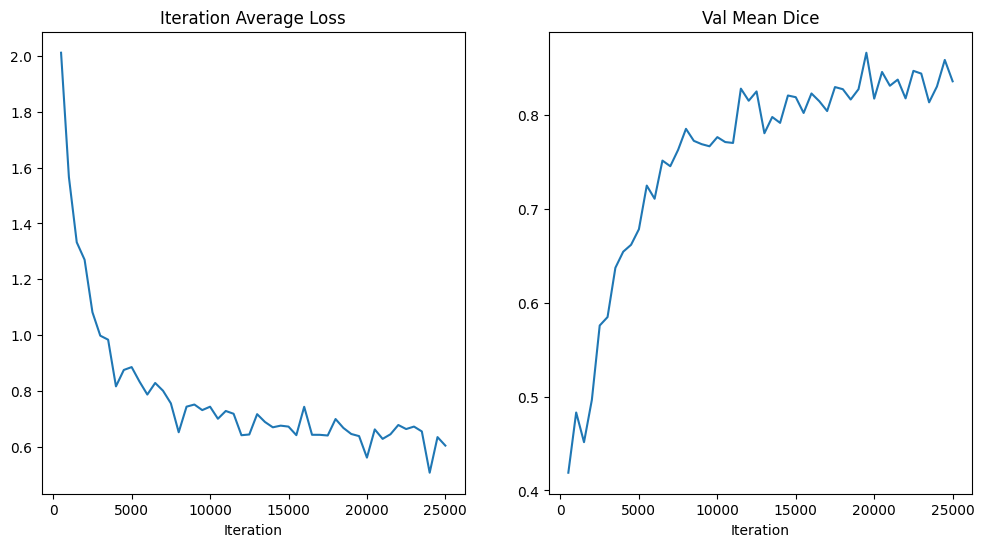

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
#Frequncy UNETR

In [5]:
#fold 0
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold0_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold0_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=0.91130): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=0.77782): 100%|█| 24/24 [00:11<00:00,  2.00it/
Training (71 / 25000 Steps) (loss=0.79579): 100%|█| 24/24 [00:12<00:00,  1.93it/
Training (95 / 25000 Steps) (loss=0.92490): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (119 / 25000 Steps) (loss=0.84349): 100%|█| 24/24 [00:12<00:00,  1.92it
Training (143 / 25000 Steps) (loss=0.76717): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (167 / 25000 Steps) (loss=0.85127): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (191 / 25000 Steps) (loss=0.79080): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (215 / 25000 Steps) (loss=2.04287): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (239 / 25000 Steps) (loss=0.62656): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (263 / 25000 Steps) (loss=0.69634): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (287 / 25000 Steps) (loss=0.90292): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8035328984260559 Current Avg. Dice: 0.8035328984260559


Training (503 / 25000 Steps) (loss=1.14556): 100%|█| 24/24 [00:16<00:00,  1.43it
Training (527 / 25000 Steps) (loss=0.95359): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (551 / 25000 Steps) (loss=0.88288): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (575 / 25000 Steps) (loss=0.84495): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (599 / 25000 Steps) (loss=0.61826): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (623 / 25000 Steps) (loss=0.93705): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (647 / 25000 Steps) (loss=0.72160): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (671 / 25000 Steps) (loss=1.03228): 100%|█| 24/24 [00:12<00:00,  1.91it
Training (695 / 25000 Steps) (loss=0.88858): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (719 / 25000 Steps) (loss=0.68649): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (743 / 25000 Steps) (loss=0.91486): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (767 / 25000 Steps) (loss=0.73607): 100%|█| 24/24 [00:12<00:00,  1.99it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.8111226558685303 Current Avg. Dice: 0.8111226558685303


Training (1007 / 25000 Steps) (loss=0.93644): 100%|█| 24/24 [00:17<00:00,  1.34i
Training (1031 / 25000 Steps) (loss=0.81791): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1055 / 25000 Steps) (loss=0.64491): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1079 / 25000 Steps) (loss=0.71271): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1103 / 25000 Steps) (loss=1.96814): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1127 / 25000 Steps) (loss=0.74816): 100%|█| 24/24 [00:12<00:00,  1.91i
Training (1151 / 25000 Steps) (loss=0.86101): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1175 / 25000 Steps) (loss=0.83964): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1199 / 25000 Steps) (loss=0.78056): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1223 / 25000 Steps) (loss=0.72327): 100%|█| 24/24 [00:12<00:00,  1.92i
Training (1247 / 25000 Steps) (loss=1.12394): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1271 / 25000 Steps) (loss=1.12840): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.8555965423583984


Training (1511 / 25000 Steps) (loss=1.08297): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (1535 / 25000 Steps) (loss=1.05089): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (1559 / 25000 Steps) (loss=1.01817): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1583 / 25000 Steps) (loss=0.61031): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1607 / 25000 Steps) (loss=0.54988): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1631 / 25000 Steps) (loss=0.85808): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (1655 / 25000 Steps) (loss=0.79165): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1679 / 25000 Steps) (loss=0.98395): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1703 / 25000 Steps) (loss=1.16703): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=0.84939): 100%|█| 24/24 [00:12<00:00,  1.92i
Training (1751 / 25000 Steps) (loss=0.69867): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1775 / 25000 Steps) (loss=0.98231): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.8036920428276062


Training (2015 / 25000 Steps) (loss=0.64395): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (2039 / 25000 Steps) (loss=0.71804): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2063 / 25000 Steps) (loss=0.99997): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2087 / 25000 Steps) (loss=0.82701): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2111 / 25000 Steps) (loss=1.05078): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2135 / 25000 Steps) (loss=0.82692): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2159 / 25000 Steps) (loss=0.84639): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2183 / 25000 Steps) (loss=0.59875): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2207 / 25000 Steps) (loss=0.82494): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2231 / 25000 Steps) (loss=0.73750): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2255 / 25000 Steps) (loss=1.23364): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2279 / 25000 Steps) (loss=0.80440): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.800811767578125


Training (2519 / 25000 Steps) (loss=0.71780): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (2543 / 25000 Steps) (loss=0.83166): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2567 / 25000 Steps) (loss=1.92280): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2591 / 25000 Steps) (loss=1.00859): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2615 / 25000 Steps) (loss=0.63678): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2639 / 25000 Steps) (loss=0.80472): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2663 / 25000 Steps) (loss=0.55317): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2687 / 25000 Steps) (loss=0.76191): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2711 / 25000 Steps) (loss=2.08677): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2735 / 25000 Steps) (loss=0.83601): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2759 / 25000 Steps) (loss=0.87220): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2783 / 25000 Steps) (loss=0.81001): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.7140953540802002


Training (3023 / 25000 Steps) (loss=0.80534): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (3047 / 25000 Steps) (loss=0.92300): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3071 / 25000 Steps) (loss=0.81690): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3095 / 25000 Steps) (loss=1.29423): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3119 / 25000 Steps) (loss=0.82171): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3143 / 25000 Steps) (loss=0.76721): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3167 / 25000 Steps) (loss=0.75187): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3191 / 25000 Steps) (loss=0.90717): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3215 / 25000 Steps) (loss=0.84351): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3239 / 25000 Steps) (loss=0.81253): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3263 / 25000 Steps) (loss=0.71495): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3287 / 25000 Steps) (loss=1.66479): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.7851748466491699


Training (3503 / 25000 Steps) (loss=0.84762): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (3527 / 25000 Steps) (loss=0.86877): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3551 / 25000 Steps) (loss=0.97563): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3575 / 25000 Steps) (loss=0.87562): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3599 / 25000 Steps) (loss=0.92132): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3623 / 25000 Steps) (loss=1.18804): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3647 / 25000 Steps) (loss=0.72497): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3671 / 25000 Steps) (loss=0.77895): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3695 / 25000 Steps) (loss=0.94215): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3719 / 25000 Steps) (loss=0.80036): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (3743 / 25000 Steps) (loss=0.78253): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3767 / 25000 Steps) (loss=0.96812): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.8193281292915344


Training (4007 / 25000 Steps) (loss=0.70020): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4031 / 25000 Steps) (loss=0.76915): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4055 / 25000 Steps) (loss=0.95694): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4079 / 25000 Steps) (loss=0.81683): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4103 / 25000 Steps) (loss=0.62659): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4127 / 25000 Steps) (loss=0.85078): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4151 / 25000 Steps) (loss=0.80786): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4175 / 25000 Steps) (loss=0.73438): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4199 / 25000 Steps) (loss=1.25563): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4223 / 25000 Steps) (loss=1.10334): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4247 / 25000 Steps) (loss=0.57806): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4271 / 25000 Steps) (loss=1.00409): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.754493772983551


Training (4511 / 25000 Steps) (loss=0.85301): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4535 / 25000 Steps) (loss=1.26961): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4559 / 25000 Steps) (loss=0.69065): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4583 / 25000 Steps) (loss=0.89622): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4607 / 25000 Steps) (loss=0.71580): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4631 / 25000 Steps) (loss=0.71701): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4655 / 25000 Steps) (loss=0.87294): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4679 / 25000 Steps) (loss=0.60671): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4703 / 25000 Steps) (loss=0.91286): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4727 / 25000 Steps) (loss=0.81665): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4751 / 25000 Steps) (loss=1.11729): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4775 / 25000 Steps) (loss=0.80461): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.7921525835990906


Training (5015 / 25000 Steps) (loss=0.72846): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5039 / 25000 Steps) (loss=0.85305): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5063 / 25000 Steps) (loss=0.77426): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5087 / 25000 Steps) (loss=0.66668): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5111 / 25000 Steps) (loss=0.63086): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5135 / 25000 Steps) (loss=0.92574): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5159 / 25000 Steps) (loss=0.77632): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5183 / 25000 Steps) (loss=0.76624): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5207 / 25000 Steps) (loss=0.78895): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5231 / 25000 Steps) (loss=1.59813): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5255 / 25000 Steps) (loss=0.77676): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5279 / 25000 Steps) (loss=0.84180): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.7628226280212402


Training (5519 / 25000 Steps) (loss=0.74332): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (5543 / 25000 Steps) (loss=0.83532): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5567 / 25000 Steps) (loss=0.88565): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5591 / 25000 Steps) (loss=0.76561): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5615 / 25000 Steps) (loss=0.61277): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5639 / 25000 Steps) (loss=0.89023): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5663 / 25000 Steps) (loss=0.79359): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5687 / 25000 Steps) (loss=0.95003): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5711 / 25000 Steps) (loss=0.79016): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5735 / 25000 Steps) (loss=0.93030): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5759 / 25000 Steps) (loss=0.81557): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5783 / 25000 Steps) (loss=0.59568): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8555965423583984 Current Avg. Dice: 0.7406293749809265


Training (6023 / 25000 Steps) (loss=1.16110): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (6047 / 25000 Steps) (loss=0.84978): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6071 / 25000 Steps) (loss=0.77820): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6095 / 25000 Steps) (loss=0.55087): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6119 / 25000 Steps) (loss=0.81535): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6143 / 25000 Steps) (loss=0.84607): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6167 / 25000 Steps) (loss=0.81156): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6191 / 25000 Steps) (loss=0.73477): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6215 / 25000 Steps) (loss=0.79106): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6239 / 25000 Steps) (loss=0.68399): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6263 / 25000 Steps) (loss=0.73123): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6287 / 25000 Steps) (loss=0.76519): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8592246174812317


Training (6503 / 25000 Steps) (loss=1.09193): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (6527 / 25000 Steps) (loss=0.77590): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6551 / 25000 Steps) (loss=0.79848): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6575 / 25000 Steps) (loss=0.71735): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6599 / 25000 Steps) (loss=0.69208): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6623 / 25000 Steps) (loss=0.81954): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6647 / 25000 Steps) (loss=0.85534): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6671 / 25000 Steps) (loss=1.35788): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6695 / 25000 Steps) (loss=0.74871): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6719 / 25000 Steps) (loss=0.74137): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6743 / 25000 Steps) (loss=0.78153): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6767 / 25000 Steps) (loss=0.70490): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7698192000389099


Training (7007 / 25000 Steps) (loss=0.84363): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (7031 / 25000 Steps) (loss=0.67323): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7055 / 25000 Steps) (loss=0.64972): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7079 / 25000 Steps) (loss=0.72417): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7103 / 25000 Steps) (loss=0.76219): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7127 / 25000 Steps) (loss=0.76405): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7151 / 25000 Steps) (loss=0.97471): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7175 / 25000 Steps) (loss=0.71781): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7199 / 25000 Steps) (loss=1.07808): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7223 / 25000 Steps) (loss=0.64499): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7247 / 25000 Steps) (loss=0.75365): 100%|█| 24/24 [00:11<00:00,  2.02i
Training (7271 / 25000 Steps) (loss=0.89831): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.778519332408905


Training (7511 / 25000 Steps) (loss=0.80790): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (7535 / 25000 Steps) (loss=1.25374): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7559 / 25000 Steps) (loss=0.87737): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7583 / 25000 Steps) (loss=0.84067): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7607 / 25000 Steps) (loss=0.83291): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7631 / 25000 Steps) (loss=0.72448): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7655 / 25000 Steps) (loss=1.63125): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7679 / 25000 Steps) (loss=0.79778): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7703 / 25000 Steps) (loss=0.90175): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7727 / 25000 Steps) (loss=0.90174): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (7751 / 25000 Steps) (loss=0.73718): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7775 / 25000 Steps) (loss=0.75406): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7945627570152283


Training (8015 / 25000 Steps) (loss=0.81852): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8039 / 25000 Steps) (loss=1.33074): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8063 / 25000 Steps) (loss=0.86955): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8087 / 25000 Steps) (loss=1.56942): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8111 / 25000 Steps) (loss=0.75435): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8135 / 25000 Steps) (loss=1.41732): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8159 / 25000 Steps) (loss=0.79448): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8183 / 25000 Steps) (loss=1.06296): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8207 / 25000 Steps) (loss=0.71693): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8231 / 25000 Steps) (loss=0.72908): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8255 / 25000 Steps) (loss=0.91247): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8279 / 25000 Steps) (loss=1.01021): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8187923431396484


Training (8519 / 25000 Steps) (loss=1.48897): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8543 / 25000 Steps) (loss=0.93967): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8567 / 25000 Steps) (loss=1.20444): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8591 / 25000 Steps) (loss=1.10090): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8615 / 25000 Steps) (loss=0.74683): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8639 / 25000 Steps) (loss=0.77618): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8663 / 25000 Steps) (loss=0.90075): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8687 / 25000 Steps) (loss=0.89936): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8711 / 25000 Steps) (loss=0.78982): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (8735 / 25000 Steps) (loss=0.92530): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8759 / 25000 Steps) (loss=0.75186): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8783 / 25000 Steps) (loss=0.60098): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7704737186431885


Training (9023 / 25000 Steps) (loss=0.82512): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (9047 / 25000 Steps) (loss=0.81027): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9071 / 25000 Steps) (loss=0.75177): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9095 / 25000 Steps) (loss=1.16293): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9119 / 25000 Steps) (loss=0.82212): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9143 / 25000 Steps) (loss=0.60241): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9167 / 25000 Steps) (loss=0.54507): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9191 / 25000 Steps) (loss=0.61166): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9215 / 25000 Steps) (loss=0.74778): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9239 / 25000 Steps) (loss=0.98324): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9263 / 25000 Steps) (loss=1.14508): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9287 / 25000 Steps) (loss=1.11351): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7961316704750061


Training (9503 / 25000 Steps) (loss=0.68700): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (9527 / 25000 Steps) (loss=0.83792): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9551 / 25000 Steps) (loss=0.71891): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9575 / 25000 Steps) (loss=0.56732): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9599 / 25000 Steps) (loss=1.06118): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9623 / 25000 Steps) (loss=0.97533): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9647 / 25000 Steps) (loss=0.75937): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9671 / 25000 Steps) (loss=0.69466): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9695 / 25000 Steps) (loss=0.71672): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9719 / 25000 Steps) (loss=0.70920): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9743 / 25000 Steps) (loss=0.61094): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9767 / 25000 Steps) (loss=0.81805): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.790233850479126


Training (10007 / 25000 Steps) (loss=1.56781): 100%|█| 24/24 [00:13<00:00,  1.77
Training (10031 / 25000 Steps) (loss=0.62503): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10055 / 25000 Steps) (loss=0.71669): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10079 / 25000 Steps) (loss=0.82280): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10103 / 25000 Steps) (loss=0.75743): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10127 / 25000 Steps) (loss=0.79379): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10151 / 25000 Steps) (loss=0.82430): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10175 / 25000 Steps) (loss=0.78823): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10199 / 25000 Steps) (loss=0.98728): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10223 / 25000 Steps) (loss=0.73760): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10247 / 25000 Steps) (loss=0.60270): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10271 / 25000 Steps) (loss=0.71620): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7866001129150391


Training (10511 / 25000 Steps) (loss=0.90042): 100%|█| 24/24 [00:13<00:00,  1.77
Training (10535 / 25000 Steps) (loss=0.84863): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10559 / 25000 Steps) (loss=0.94830): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10583 / 25000 Steps) (loss=1.00592): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10607 / 25000 Steps) (loss=0.75704): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10631 / 25000 Steps) (loss=1.74630): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10655 / 25000 Steps) (loss=1.32097): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10679 / 25000 Steps) (loss=0.98696): 100%|█| 24/24 [00:11<00:00,  2.01
Training (10703 / 25000 Steps) (loss=0.83037): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10727 / 25000 Steps) (loss=0.91430): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10751 / 25000 Steps) (loss=0.78061): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10775 / 25000 Steps) (loss=0.95896): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8172423243522644


Training (11015 / 25000 Steps) (loss=0.85233): 100%|█| 24/24 [00:13<00:00,  1.78
Training (11039 / 25000 Steps) (loss=0.84083): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11063 / 25000 Steps) (loss=1.12550): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11087 / 25000 Steps) (loss=1.00798): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11111 / 25000 Steps) (loss=0.85644): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11135 / 25000 Steps) (loss=0.81631): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11159 / 25000 Steps) (loss=0.92982): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11183 / 25000 Steps) (loss=0.82912): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11207 / 25000 Steps) (loss=1.11771): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11231 / 25000 Steps) (loss=0.83489): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11255 / 25000 Steps) (loss=0.72420): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11279 / 25000 Steps) (loss=1.20410): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7843262553215027


Training (11519 / 25000 Steps) (loss=0.68199): 100%|█| 24/24 [00:13<00:00,  1.77
Training (11543 / 25000 Steps) (loss=0.76716): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11567 / 25000 Steps) (loss=0.93620): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11591 / 25000 Steps) (loss=1.18338): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11615 / 25000 Steps) (loss=0.74904): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11639 / 25000 Steps) (loss=1.25013): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11663 / 25000 Steps) (loss=0.68418): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11687 / 25000 Steps) (loss=0.88025): 100%|█| 24/24 [00:11<00:00,  2.00
Training (11711 / 25000 Steps) (loss=0.80479): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11735 / 25000 Steps) (loss=0.97956): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11759 / 25000 Steps) (loss=0.78074): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11783 / 25000 Steps) (loss=0.78558): 100%|█| 24/24 [00:11<00:00,  2.01
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.7753689289093018


Training (12023 / 25000 Steps) (loss=0.82805): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12047 / 25000 Steps) (loss=0.78529): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12071 / 25000 Steps) (loss=0.81445): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12095 / 25000 Steps) (loss=0.98097): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12119 / 25000 Steps) (loss=0.75858): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12143 / 25000 Steps) (loss=0.87623): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12167 / 25000 Steps) (loss=0.81494): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12191 / 25000 Steps) (loss=1.19824): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12215 / 25000 Steps) (loss=0.85081): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12239 / 25000 Steps) (loss=0.85889): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12263 / 25000 Steps) (loss=1.17114): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12287 / 25000 Steps) (loss=0.83377): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8138441443443298


Training (12503 / 25000 Steps) (loss=0.73995): 100%|█| 24/24 [00:13<00:00,  1.78
Training (12527 / 25000 Steps) (loss=0.93234): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12551 / 25000 Steps) (loss=0.69248): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12575 / 25000 Steps) (loss=0.95911): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12599 / 25000 Steps) (loss=1.41135): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12623 / 25000 Steps) (loss=0.68502): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12647 / 25000 Steps) (loss=0.79416): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12671 / 25000 Steps) (loss=0.82963): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12695 / 25000 Steps) (loss=0.64286): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12719 / 25000 Steps) (loss=0.90186): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12743 / 25000 Steps) (loss=0.70945): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12767 / 25000 Steps) (loss=1.41059): 100%|█| 24/24 [00:11<00:00,  2.01
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8098354339599609


Training (13007 / 25000 Steps) (loss=0.83518): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13031 / 25000 Steps) (loss=0.70225): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13055 / 25000 Steps) (loss=0.75178): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13079 / 25000 Steps) (loss=1.68229): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13103 / 25000 Steps) (loss=0.61507): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13127 / 25000 Steps) (loss=0.52097): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13151 / 25000 Steps) (loss=0.62667): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13175 / 25000 Steps) (loss=0.75352): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13199 / 25000 Steps) (loss=1.67223): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13223 / 25000 Steps) (loss=0.78702): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13247 / 25000 Steps) (loss=0.75185): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13271 / 25000 Steps) (loss=1.22579): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.827362596988678


Training (13511 / 25000 Steps) (loss=0.78028): 100%|█| 24/24 [00:13<00:00,  1.76
Training (13535 / 25000 Steps) (loss=0.82884): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13559 / 25000 Steps) (loss=0.86538): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13583 / 25000 Steps) (loss=0.83628): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13607 / 25000 Steps) (loss=0.82361): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13631 / 25000 Steps) (loss=0.75240): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13655 / 25000 Steps) (loss=0.65256): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13679 / 25000 Steps) (loss=0.88605): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13703 / 25000 Steps) (loss=1.01883): 100%|█| 24/24 [00:11<00:00,  2.01
Training (13727 / 25000 Steps) (loss=1.01868): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13751 / 25000 Steps) (loss=0.59566): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13775 / 25000 Steps) (loss=1.45940): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8592246174812317 Current Avg. Dice: 0.8215942978858948


Training (14015 / 25000 Steps) (loss=1.28253): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14039 / 25000 Steps) (loss=0.88658): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14063 / 25000 Steps) (loss=0.76775): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14087 / 25000 Steps) (loss=1.16364): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14111 / 25000 Steps) (loss=1.12291): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14135 / 25000 Steps) (loss=0.77028): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14159 / 25000 Steps) (loss=0.82902): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14183 / 25000 Steps) (loss=0.82690): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14207 / 25000 Steps) (loss=0.87433): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14231 / 25000 Steps) (loss=0.83429): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14255 / 25000 Steps) (loss=1.12304): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14279 / 25000 Steps) (loss=0.83374): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8598113059997559


Training (14519 / 25000 Steps) (loss=0.78560): 100%|█| 24/24 [00:17<00:00,  1.41
Training (14543 / 25000 Steps) (loss=0.75903): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14567 / 25000 Steps) (loss=0.84520): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14591 / 25000 Steps) (loss=0.51541): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14615 / 25000 Steps) (loss=0.75841): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14639 / 25000 Steps) (loss=1.15228): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14663 / 25000 Steps) (loss=0.72956): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14687 / 25000 Steps) (loss=1.23347): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14711 / 25000 Steps) (loss=0.63626): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14735 / 25000 Steps) (loss=0.68829): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14759 / 25000 Steps) (loss=0.69134): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14783 / 25000 Steps) (loss=0.95769): 100%|█| 24/24 [00:11<00:00,  2.01
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.7414892315864563


Training (15023 / 25000 Steps) (loss=0.70373): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15047 / 25000 Steps) (loss=0.67276): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15071 / 25000 Steps) (loss=0.77880): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15095 / 25000 Steps) (loss=0.45778): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15119 / 25000 Steps) (loss=1.10861): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15143 / 25000 Steps) (loss=0.84555): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15167 / 25000 Steps) (loss=0.69940): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15191 / 25000 Steps) (loss=0.81290): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15215 / 25000 Steps) (loss=0.77048): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15239 / 25000 Steps) (loss=0.94711): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15263 / 25000 Steps) (loss=1.00295): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15287 / 25000 Steps) (loss=0.63386): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.7562372088432312


Training (15503 / 25000 Steps) (loss=0.78624): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15527 / 25000 Steps) (loss=0.68485): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15551 / 25000 Steps) (loss=1.02744): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15575 / 25000 Steps) (loss=0.89873): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15599 / 25000 Steps) (loss=0.62196): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15623 / 25000 Steps) (loss=0.80596): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15647 / 25000 Steps) (loss=0.77474): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15671 / 25000 Steps) (loss=0.84125): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15695 / 25000 Steps) (loss=1.10246): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15719 / 25000 Steps) (loss=0.79275): 100%|█| 24/24 [00:11<00:00,  2.01
Training (15743 / 25000 Steps) (loss=0.75233): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15767 / 25000 Steps) (loss=0.52016): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8324205875396729


Training (16007 / 25000 Steps) (loss=0.73449): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16031 / 25000 Steps) (loss=0.85925): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16055 / 25000 Steps) (loss=1.02312): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16079 / 25000 Steps) (loss=0.66026): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16103 / 25000 Steps) (loss=1.04892): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16127 / 25000 Steps) (loss=0.69237): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16151 / 25000 Steps) (loss=0.93254): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16175 / 25000 Steps) (loss=0.76193): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16199 / 25000 Steps) (loss=0.76193): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16223 / 25000 Steps) (loss=0.79603): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16247 / 25000 Steps) (loss=0.72215): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16271 / 25000 Steps) (loss=0.88142): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8121164441108704


Training (16511 / 25000 Steps) (loss=1.07653): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16535 / 25000 Steps) (loss=0.85824): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16559 / 25000 Steps) (loss=0.76354): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16583 / 25000 Steps) (loss=0.85435): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16607 / 25000 Steps) (loss=0.80278): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16631 / 25000 Steps) (loss=0.73115): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16655 / 25000 Steps) (loss=0.78074): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16679 / 25000 Steps) (loss=0.69774): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16703 / 25000 Steps) (loss=0.80013): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16727 / 25000 Steps) (loss=0.98707): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16751 / 25000 Steps) (loss=0.54434): 100%|█| 24/24 [00:11<00:00,  2.01
Training (16775 / 25000 Steps) (loss=0.74307): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8247963786125183


Training (17015 / 25000 Steps) (loss=0.85018): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17039 / 25000 Steps) (loss=0.80083): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17063 / 25000 Steps) (loss=0.82103): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17087 / 25000 Steps) (loss=0.82015): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17111 / 25000 Steps) (loss=0.96355): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17135 / 25000 Steps) (loss=1.14235): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17159 / 25000 Steps) (loss=0.51536): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17183 / 25000 Steps) (loss=0.73061): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17207 / 25000 Steps) (loss=1.10160): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17231 / 25000 Steps) (loss=0.57900): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17255 / 25000 Steps) (loss=0.72773): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17279 / 25000 Steps) (loss=0.74533): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.7499447464942932


Training (17519 / 25000 Steps) (loss=1.02433): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17543 / 25000 Steps) (loss=0.96125): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17567 / 25000 Steps) (loss=0.94244): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17591 / 25000 Steps) (loss=0.85544): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17615 / 25000 Steps) (loss=0.71177): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17639 / 25000 Steps) (loss=0.68861): 100%|█| 24/24 [00:11<00:00,  2.01
Training (17663 / 25000 Steps) (loss=1.19579): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17687 / 25000 Steps) (loss=0.74380): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17711 / 25000 Steps) (loss=0.95178): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17735 / 25000 Steps) (loss=0.74385): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17759 / 25000 Steps) (loss=0.83727): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17783 / 25000 Steps) (loss=1.00558): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.7493465542793274


Training (18023 / 25000 Steps) (loss=1.08944): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18047 / 25000 Steps) (loss=0.82333): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18071 / 25000 Steps) (loss=0.72314): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18095 / 25000 Steps) (loss=0.85607): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18119 / 25000 Steps) (loss=1.21287): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18143 / 25000 Steps) (loss=0.55085): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18167 / 25000 Steps) (loss=0.76533): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18191 / 25000 Steps) (loss=0.70180): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18215 / 25000 Steps) (loss=0.88538): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18239 / 25000 Steps) (loss=0.66606): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18263 / 25000 Steps) (loss=0.84598): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18287 / 25000 Steps) (loss=0.82769): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8282361030578613


Training (18503 / 25000 Steps) (loss=0.54832): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18527 / 25000 Steps) (loss=1.48744): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18551 / 25000 Steps) (loss=0.80128): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18575 / 25000 Steps) (loss=1.00713): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18599 / 25000 Steps) (loss=1.51115): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18623 / 25000 Steps) (loss=1.40563): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18647 / 25000 Steps) (loss=0.87413): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18671 / 25000 Steps) (loss=0.71391): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18695 / 25000 Steps) (loss=1.37940): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18719 / 25000 Steps) (loss=0.92585): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18743 / 25000 Steps) (loss=0.74016): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18767 / 25000 Steps) (loss=0.82052): 100%|█| 24/24 [00:11<00:00,  2.01
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8598113059997559 Current Avg. Dice: 0.8526711463928223


Training (19007 / 25000 Steps) (loss=0.81252): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.74052): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19055 / 25000 Steps) (loss=0.77758): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19079 / 25000 Steps) (loss=0.77267): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19103 / 25000 Steps) (loss=1.19409): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19127 / 25000 Steps) (loss=0.58806): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19151 / 25000 Steps) (loss=0.68443): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19175 / 25000 Steps) (loss=0.53877): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19199 / 25000 Steps) (loss=0.90774): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19223 / 25000 Steps) (loss=0.95882): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19247 / 25000 Steps) (loss=0.70695): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19271 / 25000 Steps) (loss=0.70288): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.8746144771575928


Training (19511 / 25000 Steps) (loss=0.67538): 100%|█| 24/24 [00:17<00:00,  1.41
Training (19535 / 25000 Steps) (loss=0.73798): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19559 / 25000 Steps) (loss=0.54278): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19583 / 25000 Steps) (loss=0.74345): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19607 / 25000 Steps) (loss=0.70864): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19631 / 25000 Steps) (loss=0.66620): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19655 / 25000 Steps) (loss=0.81109): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19679 / 25000 Steps) (loss=0.83160): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19703 / 25000 Steps) (loss=0.74683): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19727 / 25000 Steps) (loss=0.85334): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19751 / 25000 Steps) (loss=0.82637): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19775 / 25000 Steps) (loss=1.17576): 100%|█| 24/24 [00:11<00:00,  2.01
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.804825484752655


Training (20015 / 25000 Steps) (loss=0.75320): 100%|█| 24/24 [00:13<00:00,  1.77
Training (20039 / 25000 Steps) (loss=0.67151): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20063 / 25000 Steps) (loss=0.78454): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20087 / 25000 Steps) (loss=0.76768): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20111 / 25000 Steps) (loss=0.65889): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20135 / 25000 Steps) (loss=1.37821): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20159 / 25000 Steps) (loss=0.60404): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20183 / 25000 Steps) (loss=0.98760): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20207 / 25000 Steps) (loss=0.81953): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20231 / 25000 Steps) (loss=0.73645): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20255 / 25000 Steps) (loss=0.82395): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20279 / 25000 Steps) (loss=0.89599): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.7808201909065247


Training (20519 / 25000 Steps) (loss=0.92058): 100%|█| 24/24 [00:13<00:00,  1.77
Training (20543 / 25000 Steps) (loss=0.82263): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20567 / 25000 Steps) (loss=0.69802): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20591 / 25000 Steps) (loss=0.72054): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20615 / 25000 Steps) (loss=0.79842): 100%|█| 24/24 [00:11<00:00,  2.01
Training (20639 / 25000 Steps) (loss=0.81729): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20663 / 25000 Steps) (loss=0.81128): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20687 / 25000 Steps) (loss=0.82116): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20711 / 25000 Steps) (loss=0.81817): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20735 / 25000 Steps) (loss=0.91864): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20759 / 25000 Steps) (loss=0.87689): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20783 / 25000 Steps) (loss=1.17140): 100%|█| 24/24 [00:11<00:00,  2.00
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.8571987748146057


Training (21023 / 25000 Steps) (loss=0.76955): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21047 / 25000 Steps) (loss=0.85562): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21071 / 25000 Steps) (loss=1.15566): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21095 / 25000 Steps) (loss=0.76902): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21119 / 25000 Steps) (loss=0.79183): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21143 / 25000 Steps) (loss=0.79336): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21167 / 25000 Steps) (loss=0.99576): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21191 / 25000 Steps) (loss=0.89630): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21215 / 25000 Steps) (loss=0.89214): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21239 / 25000 Steps) (loss=1.26103): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21263 / 25000 Steps) (loss=0.66613): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21287 / 25000 Steps) (loss=0.99788): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.8378044962882996


Training (21503 / 25000 Steps) (loss=0.51629): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21527 / 25000 Steps) (loss=0.61139): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21551 / 25000 Steps) (loss=0.66773): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21575 / 25000 Steps) (loss=1.11476): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21599 / 25000 Steps) (loss=1.02100): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21623 / 25000 Steps) (loss=0.84509): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21647 / 25000 Steps) (loss=0.73175): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21671 / 25000 Steps) (loss=1.12939): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21695 / 25000 Steps) (loss=0.65955): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21719 / 25000 Steps) (loss=1.25772): 100%|█| 24/24 [00:11<00:00,  2.00
Training (21743 / 25000 Steps) (loss=0.81146): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21767 / 25000 Steps) (loss=0.76399): 100%|█| 24/24 [00:11<00:00,  2.01
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.7930681705474854


Training (22007 / 25000 Steps) (loss=1.20115): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22031 / 25000 Steps) (loss=0.72151): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22055 / 25000 Steps) (loss=0.65716): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22079 / 25000 Steps) (loss=0.83496): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22103 / 25000 Steps) (loss=0.77729): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22127 / 25000 Steps) (loss=1.01010): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22151 / 25000 Steps) (loss=0.73981): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22175 / 25000 Steps) (loss=0.90377): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22199 / 25000 Steps) (loss=0.84250): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22223 / 25000 Steps) (loss=1.28746): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22247 / 25000 Steps) (loss=0.72923): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22271 / 25000 Steps) (loss=0.90005): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.758120059967041


Training (22511 / 25000 Steps) (loss=0.79205): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22535 / 25000 Steps) (loss=0.68497): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.93911): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22583 / 25000 Steps) (loss=0.74999): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22607 / 25000 Steps) (loss=0.77163): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22631 / 25000 Steps) (loss=0.80780): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22655 / 25000 Steps) (loss=0.75138): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22679 / 25000 Steps) (loss=0.82768): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22703 / 25000 Steps) (loss=0.85203): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22727 / 25000 Steps) (loss=0.88286): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22751 / 25000 Steps) (loss=0.99823): 100%|█| 24/24 [00:11<00:00,  2.01
Training (22775 / 25000 Steps) (loss=0.93443): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.806016743183136


Training (23015 / 25000 Steps) (loss=0.81062): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23039 / 25000 Steps) (loss=0.98984): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23063 / 25000 Steps) (loss=0.58043): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23087 / 25000 Steps) (loss=0.67592): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23111 / 25000 Steps) (loss=0.80867): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23135 / 25000 Steps) (loss=0.85191): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23159 / 25000 Steps) (loss=0.85615): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23183 / 25000 Steps) (loss=0.88588): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23207 / 25000 Steps) (loss=0.74632): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23231 / 25000 Steps) (loss=0.62153): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23255 / 25000 Steps) (loss=0.79892): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23279 / 25000 Steps) (loss=0.58141): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.790701687335968


Training (23519 / 25000 Steps) (loss=0.71608): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23543 / 25000 Steps) (loss=1.01436): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23567 / 25000 Steps) (loss=0.66237): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23591 / 25000 Steps) (loss=0.83411): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23615 / 25000 Steps) (loss=0.85792): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23639 / 25000 Steps) (loss=0.97381): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23663 / 25000 Steps) (loss=1.25486): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23687 / 25000 Steps) (loss=0.68569): 100%|█| 24/24 [00:11<00:00,  2.01
Training (23711 / 25000 Steps) (loss=0.74344): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23735 / 25000 Steps) (loss=0.60091): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23759 / 25000 Steps) (loss=0.86117): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23783 / 25000 Steps) (loss=0.87117): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.8368048667907715


Training (24023 / 25000 Steps) (loss=0.79358): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24047 / 25000 Steps) (loss=1.04296): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24071 / 25000 Steps) (loss=0.80425): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24095 / 25000 Steps) (loss=1.16489): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24119 / 25000 Steps) (loss=0.77304): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24143 / 25000 Steps) (loss=0.64964): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24167 / 25000 Steps) (loss=0.86267): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24191 / 25000 Steps) (loss=0.77385): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24215 / 25000 Steps) (loss=0.94957): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24239 / 25000 Steps) (loss=0.92315): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24263 / 25000 Steps) (loss=0.84624): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24287 / 25000 Steps) (loss=0.62674): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.738238513469696


Training (24503 / 25000 Steps) (loss=0.59724): 100%|█| 24/24 [00:13<00:00,  1.77
Training (24527 / 25000 Steps) (loss=0.56108): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24551 / 25000 Steps) (loss=0.77554): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24575 / 25000 Steps) (loss=0.54147): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24599 / 25000 Steps) (loss=0.94159): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24623 / 25000 Steps) (loss=1.03059): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24647 / 25000 Steps) (loss=0.78117): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24671 / 25000 Steps) (loss=0.80513): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24695 / 25000 Steps) (loss=0.84464): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24719 / 25000 Steps) (loss=0.81494): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24743 / 25000 Steps) (loss=0.89232): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24767 / 25000 Steps) (loss=0.69548): 100%|█| 24/24 [00:11<00:00,  2.01
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8746144771575928 Current Avg. Dice: 0.8025608062744141


Training (25007 / 25000 Steps) (loss=0.66705): 100%|█| 24/24 [00:13<00:00,  1.77


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8746 at iteration: 19500


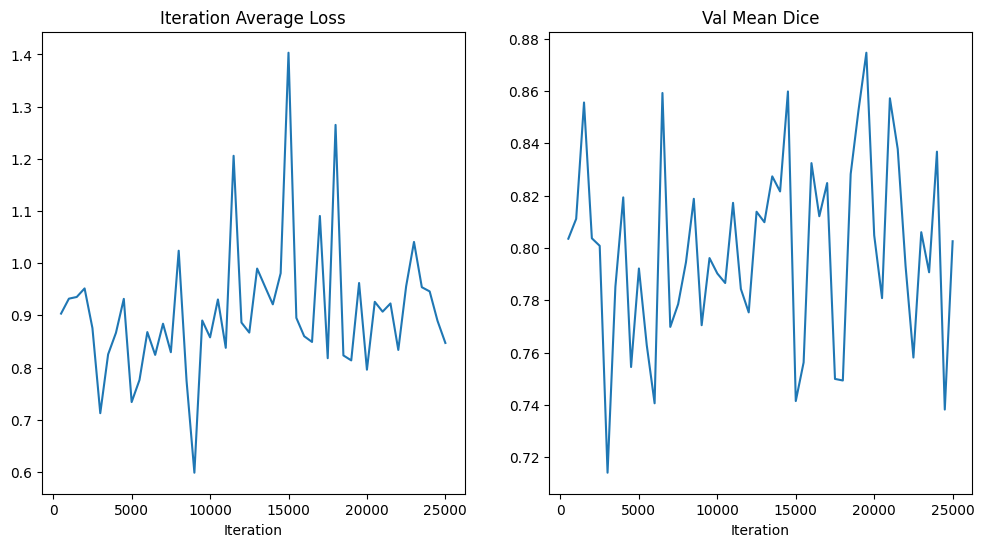

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 1
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_1.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()   
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.76768): 100%|█| 24/24 [00:14<00:00,  1.67it/
Training (47 / 25000 Steps) (loss=2.65314): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (71 / 25000 Steps) (loss=2.54968): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.55442): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (119 / 25000 Steps) (loss=2.34469): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (143 / 25000 Steps) (loss=2.47687): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (167 / 25000 Steps) (loss=2.18919): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (191 / 25000 Steps) (loss=2.31224): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (215 / 25000 Steps) (loss=2.29621): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (239 / 25000 Steps) (loss=2.16016): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (263 / 25000 Steps) (loss=2.16809): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (287 / 25000 Steps) (loss=2.25301): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3559645116329193 Current Avg. Dice: 0.3559645116329193


Training (503 / 25000 Steps) (loss=2.03032): 100%|█| 24/24 [00:17<00:00,  1.37it
Training (527 / 25000 Steps) (loss=1.80601): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (551 / 25000 Steps) (loss=1.76335): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (575 / 25000 Steps) (loss=1.78709): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (599 / 25000 Steps) (loss=1.67891): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (623 / 25000 Steps) (loss=1.81118): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (647 / 25000 Steps) (loss=1.76241): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (671 / 25000 Steps) (loss=1.85761): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (695 / 25000 Steps) (loss=1.66920): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (719 / 25000 Steps) (loss=1.72591): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (743 / 25000 Steps) (loss=1.69328): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (767 / 25000 Steps) (loss=1.90100): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4069817066192627 Current Avg. Dice: 0.4069817066192627


Training (1007 / 25000 Steps) (loss=1.69815): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (1031 / 25000 Steps) (loss=1.40586): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.52805): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1079 / 25000 Steps) (loss=1.58640): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1103 / 25000 Steps) (loss=1.50792): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1127 / 25000 Steps) (loss=1.44519): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1151 / 25000 Steps) (loss=1.42352): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1175 / 25000 Steps) (loss=1.37527): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1199 / 25000 Steps) (loss=1.68608): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1223 / 25000 Steps) (loss=1.67522): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1247 / 25000 Steps) (loss=1.49152): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1271 / 25000 Steps) (loss=1.44003): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4424546957015991 Current Avg. Dice: 0.4424546957015991


Training (1511 / 25000 Steps) (loss=1.23052): 100%|█| 24/24 [00:17<00:00,  1.37i
Training (1535 / 25000 Steps) (loss=1.25885): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.26526): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1583 / 25000 Steps) (loss=1.43457): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1607 / 25000 Steps) (loss=1.16124): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1631 / 25000 Steps) (loss=1.29777): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1655 / 25000 Steps) (loss=1.49845): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1679 / 25000 Steps) (loss=1.12087): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1703 / 25000 Steps) (loss=1.30158): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1727 / 25000 Steps) (loss=1.16446): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1751 / 25000 Steps) (loss=1.10670): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1775 / 25000 Steps) (loss=1.14085): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4424546957015991 Current Avg. Dice: 0.33998432755470276


Training (2015 / 25000 Steps) (loss=1.14457): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (2039 / 25000 Steps) (loss=1.10250): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2063 / 25000 Steps) (loss=1.13893): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2087 / 25000 Steps) (loss=1.09854): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2111 / 25000 Steps) (loss=1.03786): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2135 / 25000 Steps) (loss=1.08464): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2159 / 25000 Steps) (loss=1.06991): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2183 / 25000 Steps) (loss=1.11291): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2207 / 25000 Steps) (loss=1.05346): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2231 / 25000 Steps) (loss=1.18126): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2255 / 25000 Steps) (loss=1.19565): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2279 / 25000 Steps) (loss=1.30221): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48758944869041443 Current Avg. Dice: 0.48758944869041443


Training (2519 / 25000 Steps) (loss=1.07070): 100%|█| 24/24 [00:20<00:00,  1.16i
Training (2543 / 25000 Steps) (loss=1.12676): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2567 / 25000 Steps) (loss=1.17367): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2591 / 25000 Steps) (loss=1.44350): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2615 / 25000 Steps) (loss=1.08770): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2639 / 25000 Steps) (loss=1.04343): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2663 / 25000 Steps) (loss=0.99898): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2687 / 25000 Steps) (loss=1.11533): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2711 / 25000 Steps) (loss=1.11890): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2735 / 25000 Steps) (loss=1.00244): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2759 / 25000 Steps) (loss=1.06695): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2783 / 25000 Steps) (loss=1.12872): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48758944869041443 Current Avg. Dice: 0.47109225392341614


Training (3023 / 25000 Steps) (loss=1.15954): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (3047 / 25000 Steps) (loss=1.22857): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3071 / 25000 Steps) (loss=1.12942): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3095 / 25000 Steps) (loss=0.97909): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3119 / 25000 Steps) (loss=0.96107): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3143 / 25000 Steps) (loss=0.97288): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3167 / 25000 Steps) (loss=1.12106): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3191 / 25000 Steps) (loss=0.99481): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3215 / 25000 Steps) (loss=0.97464): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3239 / 25000 Steps) (loss=0.98663): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3263 / 25000 Steps) (loss=1.05082): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3287 / 25000 Steps) (loss=0.99024): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48758944869041443 Current Avg. Dice: 0.4645555019378662


Training (3503 / 25000 Steps) (loss=0.96232): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (3527 / 25000 Steps) (loss=1.06377): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3551 / 25000 Steps) (loss=1.06454): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3575 / 25000 Steps) (loss=0.98484): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3599 / 25000 Steps) (loss=1.04212): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3623 / 25000 Steps) (loss=0.93981): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3647 / 25000 Steps) (loss=1.04631): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3671 / 25000 Steps) (loss=1.00074): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3695 / 25000 Steps) (loss=1.02394): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3719 / 25000 Steps) (loss=0.95703): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3743 / 25000 Steps) (loss=0.96789): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3767 / 25000 Steps) (loss=0.98603): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5559288859367371 Current Avg. Dice: 0.5559288859367371


Training (4007 / 25000 Steps) (loss=1.09324): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (4031 / 25000 Steps) (loss=0.92533): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4055 / 25000 Steps) (loss=0.92377): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4079 / 25000 Steps) (loss=1.01909): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4103 / 25000 Steps) (loss=0.97821): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4127 / 25000 Steps) (loss=1.01225): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4151 / 25000 Steps) (loss=0.99173): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4175 / 25000 Steps) (loss=0.95518): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4199 / 25000 Steps) (loss=1.12357): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4223 / 25000 Steps) (loss=0.93820): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4247 / 25000 Steps) (loss=0.96545): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4271 / 25000 Steps) (loss=1.10338): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5618850588798523 Current Avg. Dice: 0.5618850588798523


Training (4511 / 25000 Steps) (loss=0.99804): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (4535 / 25000 Steps) (loss=0.99628): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4559 / 25000 Steps) (loss=1.00017): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4583 / 25000 Steps) (loss=0.89335): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4607 / 25000 Steps) (loss=0.95357): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4631 / 25000 Steps) (loss=0.93853): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4655 / 25000 Steps) (loss=1.05410): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4679 / 25000 Steps) (loss=0.94499): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4703 / 25000 Steps) (loss=1.40278): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4727 / 25000 Steps) (loss=1.00879): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4751 / 25000 Steps) (loss=1.04606): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4775 / 25000 Steps) (loss=0.94487): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5897089838981628 Current Avg. Dice: 0.5897089838981628


Training (5015 / 25000 Steps) (loss=0.97058): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (5039 / 25000 Steps) (loss=1.15089): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5063 / 25000 Steps) (loss=0.96489): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=0.93669): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5111 / 25000 Steps) (loss=0.96824): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5135 / 25000 Steps) (loss=0.97279): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5159 / 25000 Steps) (loss=0.95979): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5183 / 25000 Steps) (loss=0.95553): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5207 / 25000 Steps) (loss=0.90524): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5231 / 25000 Steps) (loss=0.93833): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5255 / 25000 Steps) (loss=1.56120): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5279 / 25000 Steps) (loss=0.93217): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5897089838981628 Current Avg. Dice: 0.5357263684272766


Training (5519 / 25000 Steps) (loss=0.89677): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (5543 / 25000 Steps) (loss=1.11631): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5567 / 25000 Steps) (loss=0.92632): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5591 / 25000 Steps) (loss=0.88609): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5615 / 25000 Steps) (loss=0.94296): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5639 / 25000 Steps) (loss=0.99542): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5663 / 25000 Steps) (loss=1.05099): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5687 / 25000 Steps) (loss=0.91682): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5711 / 25000 Steps) (loss=1.39069): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5735 / 25000 Steps) (loss=0.90300): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5759 / 25000 Steps) (loss=0.89869): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5783 / 25000 Steps) (loss=0.96391): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6031007766723633 Current Avg. Dice: 0.6031007766723633


Training (6023 / 25000 Steps) (loss=1.02686): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (6047 / 25000 Steps) (loss=0.92101): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6071 / 25000 Steps) (loss=0.84512): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6095 / 25000 Steps) (loss=0.82275): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6119 / 25000 Steps) (loss=1.12737): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6143 / 25000 Steps) (loss=0.96103): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6167 / 25000 Steps) (loss=0.95193): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6191 / 25000 Steps) (loss=1.02120): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6215 / 25000 Steps) (loss=0.83148): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6239 / 25000 Steps) (loss=0.84757): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6263 / 25000 Steps) (loss=0.92450): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6287 / 25000 Steps) (loss=1.00895): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6407849788665771 Current Avg. Dice: 0.6407849788665771


Training (6503 / 25000 Steps) (loss=0.84453): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (6527 / 25000 Steps) (loss=0.78088): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6551 / 25000 Steps) (loss=0.84846): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6575 / 25000 Steps) (loss=0.95391): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6599 / 25000 Steps) (loss=0.86037): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6623 / 25000 Steps) (loss=0.83739): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6647 / 25000 Steps) (loss=0.79806): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6671 / 25000 Steps) (loss=0.79747): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6695 / 25000 Steps) (loss=1.49196): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6719 / 25000 Steps) (loss=0.86034): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6743 / 25000 Steps) (loss=0.84284): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6767 / 25000 Steps) (loss=0.85422): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.660054624080658 Current Avg. Dice: 0.660054624080658


Training (7007 / 25000 Steps) (loss=0.78776): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (7031 / 25000 Steps) (loss=0.87015): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7055 / 25000 Steps) (loss=0.83301): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7079 / 25000 Steps) (loss=0.85469): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7103 / 25000 Steps) (loss=0.85681): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7127 / 25000 Steps) (loss=0.83726): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7151 / 25000 Steps) (loss=0.78608): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7175 / 25000 Steps) (loss=0.86317): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7199 / 25000 Steps) (loss=0.79854): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7223 / 25000 Steps) (loss=0.85295): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7247 / 25000 Steps) (loss=1.39912): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7271 / 25000 Steps) (loss=0.94515): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6794125437736511 Current Avg. Dice: 0.6794125437736511


Training (7511 / 25000 Steps) (loss=0.96144): 100%|█| 24/24 [00:16<00:00,  1.41i
Training (7535 / 25000 Steps) (loss=0.87756): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7559 / 25000 Steps) (loss=0.93946): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7583 / 25000 Steps) (loss=0.69207): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7607 / 25000 Steps) (loss=0.86979): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7631 / 25000 Steps) (loss=0.81508): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7655 / 25000 Steps) (loss=0.95531): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7679 / 25000 Steps) (loss=1.16623): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7703 / 25000 Steps) (loss=0.76839): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7727 / 25000 Steps) (loss=0.70105): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7751 / 25000 Steps) (loss=0.85723): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7775 / 25000 Steps) (loss=0.84095): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6794125437736511 Current Avg. Dice: 0.6534990668296814


Training (8015 / 25000 Steps) (loss=0.83176): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8039 / 25000 Steps) (loss=0.83470): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8063 / 25000 Steps) (loss=0.77874): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8087 / 25000 Steps) (loss=0.86803): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8111 / 25000 Steps) (loss=0.78780): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8135 / 25000 Steps) (loss=0.95660): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8159 / 25000 Steps) (loss=0.80439): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8183 / 25000 Steps) (loss=0.77673): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8207 / 25000 Steps) (loss=0.83958): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8231 / 25000 Steps) (loss=0.82127): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8255 / 25000 Steps) (loss=0.81429): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8279 / 25000 Steps) (loss=0.84414): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6794125437736511 Current Avg. Dice: 0.673086404800415


Training (8519 / 25000 Steps) (loss=0.76350): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8543 / 25000 Steps) (loss=0.77123): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8567 / 25000 Steps) (loss=0.97475): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8591 / 25000 Steps) (loss=0.76512): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8615 / 25000 Steps) (loss=0.84576): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8639 / 25000 Steps) (loss=1.23239): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8663 / 25000 Steps) (loss=0.76115): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8687 / 25000 Steps) (loss=0.70372): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8711 / 25000 Steps) (loss=0.74831): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8735 / 25000 Steps) (loss=0.79938): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8759 / 25000 Steps) (loss=0.74309): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8783 / 25000 Steps) (loss=0.82529): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7022700905799866 Current Avg. Dice: 0.7022700905799866


Training (9023 / 25000 Steps) (loss=0.68712): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (9047 / 25000 Steps) (loss=0.73431): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9071 / 25000 Steps) (loss=0.72083): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9095 / 25000 Steps) (loss=0.88895): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9119 / 25000 Steps) (loss=1.06246): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9143 / 25000 Steps) (loss=0.80313): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9167 / 25000 Steps) (loss=0.81841): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9191 / 25000 Steps) (loss=0.79159): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9215 / 25000 Steps) (loss=0.73022): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9239 / 25000 Steps) (loss=1.60713): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9263 / 25000 Steps) (loss=0.93747): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9287 / 25000 Steps) (loss=0.85179): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7022700905799866 Current Avg. Dice: 0.6721704602241516


Training (9503 / 25000 Steps) (loss=0.85552): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (9527 / 25000 Steps) (loss=0.81767): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9551 / 25000 Steps) (loss=1.09281): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9575 / 25000 Steps) (loss=0.75997): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9599 / 25000 Steps) (loss=1.17910): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9623 / 25000 Steps) (loss=0.76246): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9647 / 25000 Steps) (loss=0.98882): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9671 / 25000 Steps) (loss=0.74713): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9695 / 25000 Steps) (loss=0.78858): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9719 / 25000 Steps) (loss=0.80933): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9743 / 25000 Steps) (loss=0.69500): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9767 / 25000 Steps) (loss=0.73654): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7689434885978699 Current Avg. Dice: 0.7689434885978699


Training (10007 / 25000 Steps) (loss=0.75841): 100%|█| 24/24 [00:17<00:00,  1.40
Training (10031 / 25000 Steps) (loss=0.73254): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10055 / 25000 Steps) (loss=0.73822): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10079 / 25000 Steps) (loss=0.52888): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10103 / 25000 Steps) (loss=0.67914): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10127 / 25000 Steps) (loss=0.55765): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10151 / 25000 Steps) (loss=0.78526): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10175 / 25000 Steps) (loss=0.69150): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10199 / 25000 Steps) (loss=0.85379): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10223 / 25000 Steps) (loss=0.63982): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10247 / 25000 Steps) (loss=0.83221): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10271 / 25000 Steps) (loss=0.75391): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7689434885978699 Current Avg. Dice: 0.7589028477668762


Training (10511 / 25000 Steps) (loss=0.73118): 100%|█| 24/24 [00:13<00:00,  1.78
Training (10535 / 25000 Steps) (loss=0.79186): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10559 / 25000 Steps) (loss=0.79346): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10583 / 25000 Steps) (loss=0.73163): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10607 / 25000 Steps) (loss=0.66591): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10631 / 25000 Steps) (loss=0.75256): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10655 / 25000 Steps) (loss=0.81801): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10679 / 25000 Steps) (loss=0.81598): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10703 / 25000 Steps) (loss=0.56261): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10727 / 25000 Steps) (loss=0.77672): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10751 / 25000 Steps) (loss=0.64960): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10775 / 25000 Steps) (loss=0.72700): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.8012371063232422


Training (11015 / 25000 Steps) (loss=0.77554): 100%|█| 24/24 [00:16<00:00,  1.41
Training (11039 / 25000 Steps) (loss=0.61363): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11063 / 25000 Steps) (loss=0.64222): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11087 / 25000 Steps) (loss=0.56118): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11111 / 25000 Steps) (loss=0.70027): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11135 / 25000 Steps) (loss=0.83278): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11159 / 25000 Steps) (loss=0.71747): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11183 / 25000 Steps) (loss=0.83768): 100%|█| 24/24 [00:12<00:00,  2.00
Training (11207 / 25000 Steps) (loss=0.68503): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11231 / 25000 Steps) (loss=0.66721): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11255 / 25000 Steps) (loss=1.05886): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11279 / 25000 Steps) (loss=0.85178): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7828120589256287


Training (11519 / 25000 Steps) (loss=0.86004): 100%|█| 24/24 [00:13<00:00,  1.78
Training (11543 / 25000 Steps) (loss=0.65277): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11567 / 25000 Steps) (loss=0.73249): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11591 / 25000 Steps) (loss=0.66535): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11615 / 25000 Steps) (loss=0.68381): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11639 / 25000 Steps) (loss=0.72103): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11663 / 25000 Steps) (loss=0.86721): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11687 / 25000 Steps) (loss=0.62144): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11711 / 25000 Steps) (loss=0.80050): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11735 / 25000 Steps) (loss=0.73083): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11759 / 25000 Steps) (loss=0.83425): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11783 / 25000 Steps) (loss=0.80292): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7579724788665771


Training (12023 / 25000 Steps) (loss=0.64626): 100%|█| 24/24 [00:13<00:00,  1.78
Training (12047 / 25000 Steps) (loss=0.74516): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12071 / 25000 Steps) (loss=0.60776): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12095 / 25000 Steps) (loss=0.78204): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12119 / 25000 Steps) (loss=0.58318): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12143 / 25000 Steps) (loss=0.67355): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12167 / 25000 Steps) (loss=0.63959): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12191 / 25000 Steps) (loss=0.77385): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12215 / 25000 Steps) (loss=0.65655): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12239 / 25000 Steps) (loss=0.60645): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12263 / 25000 Steps) (loss=0.98353): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12287 / 25000 Steps) (loss=0.78842): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7934427261352539


Training (12503 / 25000 Steps) (loss=0.59734): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12527 / 25000 Steps) (loss=0.63886): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12551 / 25000 Steps) (loss=0.79578): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12575 / 25000 Steps) (loss=0.81299): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12599 / 25000 Steps) (loss=0.61756): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12623 / 25000 Steps) (loss=0.69829): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12647 / 25000 Steps) (loss=0.76978): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12671 / 25000 Steps) (loss=0.69160): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12695 / 25000 Steps) (loss=0.59404): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12719 / 25000 Steps) (loss=0.76001): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12743 / 25000 Steps) (loss=0.68078): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12767 / 25000 Steps) (loss=0.74057): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7729883790016174


Training (13007 / 25000 Steps) (loss=0.69670): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13031 / 25000 Steps) (loss=0.89412): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13055 / 25000 Steps) (loss=0.58689): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13079 / 25000 Steps) (loss=0.64586): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13103 / 25000 Steps) (loss=0.86129): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13127 / 25000 Steps) (loss=0.68476): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13151 / 25000 Steps) (loss=0.67414): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13175 / 25000 Steps) (loss=0.66159): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13199 / 25000 Steps) (loss=0.55679): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13223 / 25000 Steps) (loss=0.71574): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13247 / 25000 Steps) (loss=0.62634): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13271 / 25000 Steps) (loss=0.76078): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7933873534202576


Training (13511 / 25000 Steps) (loss=0.53900): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13535 / 25000 Steps) (loss=0.71636): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.63959): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13583 / 25000 Steps) (loss=0.65834): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13607 / 25000 Steps) (loss=0.60948): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13631 / 25000 Steps) (loss=0.77718): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13655 / 25000 Steps) (loss=0.61870): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13679 / 25000 Steps) (loss=0.58772): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13703 / 25000 Steps) (loss=0.72660): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13727 / 25000 Steps) (loss=0.52054): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13751 / 25000 Steps) (loss=0.68331): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13775 / 25000 Steps) (loss=0.66222): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7731429934501648


Training (14015 / 25000 Steps) (loss=0.86374): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14039 / 25000 Steps) (loss=0.68145): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14063 / 25000 Steps) (loss=0.77839): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14087 / 25000 Steps) (loss=0.58384): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14111 / 25000 Steps) (loss=0.74158): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.76722): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14159 / 25000 Steps) (loss=0.84423): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14183 / 25000 Steps) (loss=0.73580): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14207 / 25000 Steps) (loss=0.67912): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14231 / 25000 Steps) (loss=0.88169): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14255 / 25000 Steps) (loss=0.50943): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14279 / 25000 Steps) (loss=0.59484): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7881749272346497


Training (14519 / 25000 Steps) (loss=0.60492): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14543 / 25000 Steps) (loss=0.77999): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14567 / 25000 Steps) (loss=0.69895): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.64842): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14615 / 25000 Steps) (loss=0.69623): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14639 / 25000 Steps) (loss=0.61175): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14663 / 25000 Steps) (loss=0.77157): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14687 / 25000 Steps) (loss=0.58406): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14711 / 25000 Steps) (loss=0.67712): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14735 / 25000 Steps) (loss=0.63602): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14759 / 25000 Steps) (loss=0.53677): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14783 / 25000 Steps) (loss=0.73755): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7286526560783386


Training (15023 / 25000 Steps) (loss=0.59807): 100%|█| 24/24 [00:13<00:00,  1.78
Training (15047 / 25000 Steps) (loss=0.88944): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15071 / 25000 Steps) (loss=0.67297): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15095 / 25000 Steps) (loss=0.73452): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15119 / 25000 Steps) (loss=0.67658): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15143 / 25000 Steps) (loss=0.88247): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15167 / 25000 Steps) (loss=0.66120): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15191 / 25000 Steps) (loss=0.68421): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15215 / 25000 Steps) (loss=0.67814): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15239 / 25000 Steps) (loss=0.76259): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15263 / 25000 Steps) (loss=0.95332): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15287 / 25000 Steps) (loss=0.64900): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7552130818367004


Training (15503 / 25000 Steps) (loss=0.60662): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15527 / 25000 Steps) (loss=0.69834): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15551 / 25000 Steps) (loss=0.75466): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15575 / 25000 Steps) (loss=0.61625): 100%|█| 24/24 [00:12<00:00,  1.93
Training (15599 / 25000 Steps) (loss=0.68273): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15623 / 25000 Steps) (loss=0.59026): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15647 / 25000 Steps) (loss=0.73675): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15671 / 25000 Steps) (loss=0.75822): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15695 / 25000 Steps) (loss=0.42244): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15719 / 25000 Steps) (loss=0.65218): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15743 / 25000 Steps) (loss=0.69916): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15767 / 25000 Steps) (loss=0.73999): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8012371063232422 Current Avg. Dice: 0.7823295593261719


Training (16007 / 25000 Steps) (loss=0.82173): 100%|█| 24/24 [00:13<00:00,  1.75
Training (16031 / 25000 Steps) (loss=0.44789): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16055 / 25000 Steps) (loss=0.82255): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16079 / 25000 Steps) (loss=0.76906): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16103 / 25000 Steps) (loss=0.65789): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16127 / 25000 Steps) (loss=0.52303): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16151 / 25000 Steps) (loss=0.75412): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16175 / 25000 Steps) (loss=0.70903): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16199 / 25000 Steps) (loss=0.74184): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16223 / 25000 Steps) (loss=0.73620): 100%|█| 24/24 [00:12<00:00,  1.95
Training (16247 / 25000 Steps) (loss=0.67923): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16271 / 25000 Steps) (loss=0.74614): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.8222932815551758


Training (16511 / 25000 Steps) (loss=0.76476): 100%|█| 24/24 [00:17<00:00,  1.37
Training (16535 / 25000 Steps) (loss=0.65291): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16559 / 25000 Steps) (loss=0.70226): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16583 / 25000 Steps) (loss=0.71524): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16607 / 25000 Steps) (loss=0.54504): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16631 / 25000 Steps) (loss=0.62424): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16655 / 25000 Steps) (loss=0.69963): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16679 / 25000 Steps) (loss=0.77267): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16703 / 25000 Steps) (loss=0.40928): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16727 / 25000 Steps) (loss=0.59035): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16751 / 25000 Steps) (loss=0.67644): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16775 / 25000 Steps) (loss=0.52712): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7999048829078674


Training (17015 / 25000 Steps) (loss=0.57268): 100%|█| 24/24 [00:13<00:00,  1.75
Training (17039 / 25000 Steps) (loss=0.56669): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17063 / 25000 Steps) (loss=0.65822): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17087 / 25000 Steps) (loss=0.69567): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17111 / 25000 Steps) (loss=0.78799): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17135 / 25000 Steps) (loss=0.57320): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17159 / 25000 Steps) (loss=0.56263): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17183 / 25000 Steps) (loss=0.64376): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17207 / 25000 Steps) (loss=0.49645): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17231 / 25000 Steps) (loss=0.86721): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17255 / 25000 Steps) (loss=0.74490): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17279 / 25000 Steps) (loss=0.51458): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.75700443983078


Training (17519 / 25000 Steps) (loss=0.97007): 100%|█| 24/24 [00:13<00:00,  1.78
Training (17543 / 25000 Steps) (loss=0.69415): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17567 / 25000 Steps) (loss=0.69881): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17591 / 25000 Steps) (loss=0.74732): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17615 / 25000 Steps) (loss=0.64585): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17639 / 25000 Steps) (loss=0.64329): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17663 / 25000 Steps) (loss=0.76916): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17687 / 25000 Steps) (loss=0.64426): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17711 / 25000 Steps) (loss=0.81144): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17735 / 25000 Steps) (loss=0.75168): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17759 / 25000 Steps) (loss=0.68797): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17783 / 25000 Steps) (loss=0.59623): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7835917472839355


Training (18023 / 25000 Steps) (loss=0.71148): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18047 / 25000 Steps) (loss=0.50846): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18071 / 25000 Steps) (loss=0.57454): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18095 / 25000 Steps) (loss=0.66409): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18119 / 25000 Steps) (loss=0.62347): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18143 / 25000 Steps) (loss=0.75415): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18167 / 25000 Steps) (loss=0.67796): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18191 / 25000 Steps) (loss=0.58306): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18215 / 25000 Steps) (loss=0.59119): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18239 / 25000 Steps) (loss=0.73010): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18263 / 25000 Steps) (loss=0.58608): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18287 / 25000 Steps) (loss=0.59876): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.816537082195282


Training (18503 / 25000 Steps) (loss=0.48476): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18527 / 25000 Steps) (loss=0.58287): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18551 / 25000 Steps) (loss=0.58030): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18575 / 25000 Steps) (loss=0.67132): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18599 / 25000 Steps) (loss=0.68310): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18623 / 25000 Steps) (loss=0.46580): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18647 / 25000 Steps) (loss=0.72736): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18671 / 25000 Steps) (loss=0.54114): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18695 / 25000 Steps) (loss=0.68708): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18719 / 25000 Steps) (loss=0.75689): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18743 / 25000 Steps) (loss=0.56344): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18767 / 25000 Steps) (loss=0.68266): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7737911343574524


Training (19007 / 25000 Steps) (loss=0.76489): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.64250): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19055 / 25000 Steps) (loss=0.66121): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19079 / 25000 Steps) (loss=0.70395): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19103 / 25000 Steps) (loss=0.75776): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19127 / 25000 Steps) (loss=0.52641): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19151 / 25000 Steps) (loss=0.68280): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19175 / 25000 Steps) (loss=0.47414): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19199 / 25000 Steps) (loss=0.73132): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19223 / 25000 Steps) (loss=0.42365): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19247 / 25000 Steps) (loss=0.69688): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19271 / 25000 Steps) (loss=0.78610): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.8075200915336609


Training (19511 / 25000 Steps) (loss=0.45134): 100%|█| 24/24 [00:13<00:00,  1.78
Training (19535 / 25000 Steps) (loss=0.73771): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19559 / 25000 Steps) (loss=0.79371): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19583 / 25000 Steps) (loss=0.75299): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19607 / 25000 Steps) (loss=0.79589): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19631 / 25000 Steps) (loss=0.80195): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19655 / 25000 Steps) (loss=0.70711): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19679 / 25000 Steps) (loss=0.57910): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19703 / 25000 Steps) (loss=0.69607): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19727 / 25000 Steps) (loss=0.54922): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19751 / 25000 Steps) (loss=0.58048): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19775 / 25000 Steps) (loss=0.87151): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7975621223449707


Training (20015 / 25000 Steps) (loss=0.65075): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20039 / 25000 Steps) (loss=0.62820): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20063 / 25000 Steps) (loss=0.54490): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20087 / 25000 Steps) (loss=0.74318): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20111 / 25000 Steps) (loss=0.52559): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20135 / 25000 Steps) (loss=0.48286): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20159 / 25000 Steps) (loss=0.83348): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20183 / 25000 Steps) (loss=0.76997): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20207 / 25000 Steps) (loss=0.47592): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20231 / 25000 Steps) (loss=0.74644): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20255 / 25000 Steps) (loss=0.55459): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20279 / 25000 Steps) (loss=0.67056): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.775091826915741


Training (20519 / 25000 Steps) (loss=0.71550): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20543 / 25000 Steps) (loss=0.63911): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20567 / 25000 Steps) (loss=0.50666): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20591 / 25000 Steps) (loss=0.58453): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20615 / 25000 Steps) (loss=0.62051): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20639 / 25000 Steps) (loss=0.57686): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20663 / 25000 Steps) (loss=0.44449): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20687 / 25000 Steps) (loss=0.82269): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20711 / 25000 Steps) (loss=0.48003): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20735 / 25000 Steps) (loss=0.56799): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20759 / 25000 Steps) (loss=0.60435): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20783 / 25000 Steps) (loss=0.59061): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7770311832427979


Training (21023 / 25000 Steps) (loss=0.56808): 100%|█| 24/24 [00:13<00:00,  1.78
Training (21047 / 25000 Steps) (loss=0.49696): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21071 / 25000 Steps) (loss=0.51332): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21095 / 25000 Steps) (loss=0.63610): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21119 / 25000 Steps) (loss=0.62692): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21143 / 25000 Steps) (loss=0.62802): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21167 / 25000 Steps) (loss=0.58813): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21191 / 25000 Steps) (loss=0.58030): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21215 / 25000 Steps) (loss=0.65811): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21239 / 25000 Steps) (loss=0.78497): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21263 / 25000 Steps) (loss=0.68676): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21287 / 25000 Steps) (loss=0.57879): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.8124923706054688


Training (21503 / 25000 Steps) (loss=0.60121): 100%|█| 24/24 [00:13<00:00,  1.78
Training (21527 / 25000 Steps) (loss=0.68980): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21551 / 25000 Steps) (loss=0.66528): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21575 / 25000 Steps) (loss=0.59232): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21599 / 25000 Steps) (loss=0.63591): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21623 / 25000 Steps) (loss=0.67888): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21647 / 25000 Steps) (loss=0.61420): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21671 / 25000 Steps) (loss=0.82712): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21695 / 25000 Steps) (loss=0.36607): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21719 / 25000 Steps) (loss=0.59055): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21743 / 25000 Steps) (loss=0.58755): 100%|█| 24/24 [00:12<00:00,  2.00
Training (21767 / 25000 Steps) (loss=0.63630): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7789018750190735


Training (22007 / 25000 Steps) (loss=0.84580): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22031 / 25000 Steps) (loss=0.59146): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22055 / 25000 Steps) (loss=0.68257): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22079 / 25000 Steps) (loss=0.71667): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22103 / 25000 Steps) (loss=0.66635): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22127 / 25000 Steps) (loss=0.66875): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22151 / 25000 Steps) (loss=0.73296): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22175 / 25000 Steps) (loss=0.56433): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22199 / 25000 Steps) (loss=0.76762): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22223 / 25000 Steps) (loss=0.73146): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22247 / 25000 Steps) (loss=0.47124): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22271 / 25000 Steps) (loss=0.62433): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7716024518013


Training (22511 / 25000 Steps) (loss=0.66763): 100%|█| 24/24 [00:13<00:00,  1.78
Training (22535 / 25000 Steps) (loss=0.58891): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.61104): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22583 / 25000 Steps) (loss=0.69771): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22607 / 25000 Steps) (loss=0.42537): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22631 / 25000 Steps) (loss=0.73285): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22655 / 25000 Steps) (loss=0.75831): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22679 / 25000 Steps) (loss=0.62101): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22703 / 25000 Steps) (loss=0.70666): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22727 / 25000 Steps) (loss=0.69651): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22751 / 25000 Steps) (loss=0.59329): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22775 / 25000 Steps) (loss=0.68683): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7898454070091248


Training (23015 / 25000 Steps) (loss=0.79391): 100%|█| 24/24 [00:13<00:00,  1.78
Training (23039 / 25000 Steps) (loss=0.58179): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23063 / 25000 Steps) (loss=0.50809): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23087 / 25000 Steps) (loss=0.55820): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23111 / 25000 Steps) (loss=0.43683): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23135 / 25000 Steps) (loss=0.66401): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23159 / 25000 Steps) (loss=0.57699): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23183 / 25000 Steps) (loss=0.43074): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23207 / 25000 Steps) (loss=0.58804): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23231 / 25000 Steps) (loss=0.54018): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23255 / 25000 Steps) (loss=0.62831): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23279 / 25000 Steps) (loss=0.79116): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8222932815551758 Current Avg. Dice: 0.7956801056861877


Training (23519 / 25000 Steps) (loss=0.55284): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23543 / 25000 Steps) (loss=0.65412): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23567 / 25000 Steps) (loss=0.55744): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23591 / 25000 Steps) (loss=0.58046): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23615 / 25000 Steps) (loss=0.65643): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23639 / 25000 Steps) (loss=0.59451): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23663 / 25000 Steps) (loss=0.68207): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23687 / 25000 Steps) (loss=0.63601): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23711 / 25000 Steps) (loss=0.58501): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23735 / 25000 Steps) (loss=0.62435): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23759 / 25000 Steps) (loss=0.55449): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23783 / 25000 Steps) (loss=0.62692): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8459322452545166 Current Avg. Dice: 0.8459322452545166


Training (24023 / 25000 Steps) (loss=0.51992): 100%|█| 24/24 [00:17<00:00,  1.41
Training (24047 / 25000 Steps) (loss=0.34755): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24071 / 25000 Steps) (loss=0.75190): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24095 / 25000 Steps) (loss=0.69420): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24119 / 25000 Steps) (loss=0.73525): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24143 / 25000 Steps) (loss=0.78583): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24167 / 25000 Steps) (loss=0.53259): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24191 / 25000 Steps) (loss=0.50972): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24215 / 25000 Steps) (loss=0.67562): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24239 / 25000 Steps) (loss=0.61950): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24263 / 25000 Steps) (loss=0.65740): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24287 / 25000 Steps) (loss=0.73371): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8459322452545166 Current Avg. Dice: 0.7535360455513


Training (24503 / 25000 Steps) (loss=0.58351): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24527 / 25000 Steps) (loss=0.68267): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24551 / 25000 Steps) (loss=0.54064): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24575 / 25000 Steps) (loss=0.51985): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24599 / 25000 Steps) (loss=0.67553): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24623 / 25000 Steps) (loss=0.67241): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24647 / 25000 Steps) (loss=0.61162): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24671 / 25000 Steps) (loss=0.64484): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24695 / 25000 Steps) (loss=0.58629): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24719 / 25000 Steps) (loss=0.55161): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24743 / 25000 Steps) (loss=0.62244): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24767 / 25000 Steps) (loss=0.56368): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8459322452545166 Current Avg. Dice: 0.7796913981437683


Training (25007 / 25000 Steps) (loss=0.61490): 100%|█| 24/24 [00:13<00:00,  1.78


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8459 at iteration: 24000


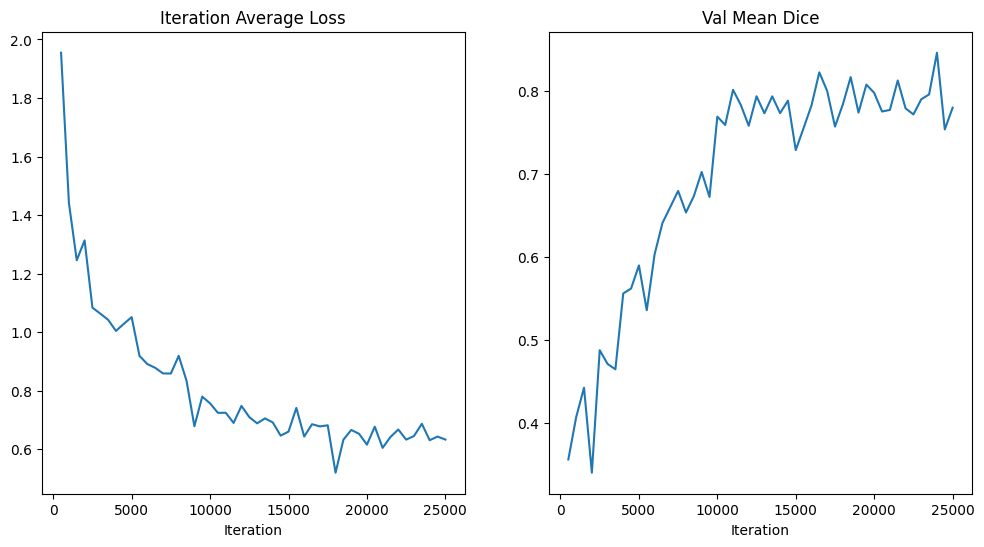

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 2
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_2.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train() 
#     model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold2_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold2_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.24232): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.17079): 100%|█| 24/24 [00:12<00:00,  1.94it/
Training (71 / 25000 Steps) (loss=2.03155): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (95 / 25000 Steps) (loss=2.02398): 100%|█| 24/24 [00:12<00:00,  1.98it/
Training (119 / 25000 Steps) (loss=1.95500): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (143 / 25000 Steps) (loss=2.11863): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (167 / 25000 Steps) (loss=1.88070): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (191 / 25000 Steps) (loss=1.83287): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (215 / 25000 Steps) (loss=1.76480): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (239 / 25000 Steps) (loss=1.83738): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (263 / 25000 Steps) (loss=1.88827): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (287 / 25000 Steps) (loss=1.75907): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.46704891324043274 Current Avg. Dice: 0.46704891324043274


Training (503 / 25000 Steps) (loss=1.46509): 100%|█| 24/24 [00:17<00:00,  1.36it
Training (527 / 25000 Steps) (loss=1.43102): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (551 / 25000 Steps) (loss=1.47901): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (575 / 25000 Steps) (loss=1.43072): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (599 / 25000 Steps) (loss=1.35987): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (623 / 25000 Steps) (loss=1.46566): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (647 / 25000 Steps) (loss=1.42022): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (671 / 25000 Steps) (loss=1.42599): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (695 / 25000 Steps) (loss=1.38929): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (719 / 25000 Steps) (loss=1.83861): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (743 / 25000 Steps) (loss=1.21151): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (767 / 25000 Steps) (loss=1.36155): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.46704891324043274 Current Avg. Dice: 0.38426050543785095


Training (1007 / 25000 Steps) (loss=1.33041): 100%|█| 24/24 [00:13<00:00,  1.73i
Training (1031 / 25000 Steps) (loss=1.22981): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1055 / 25000 Steps) (loss=1.58875): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1079 / 25000 Steps) (loss=1.33242): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1103 / 25000 Steps) (loss=1.37060): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1127 / 25000 Steps) (loss=1.25929): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1151 / 25000 Steps) (loss=1.15445): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1175 / 25000 Steps) (loss=1.27128): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1199 / 25000 Steps) (loss=1.10229): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1223 / 25000 Steps) (loss=1.50248): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1247 / 25000 Steps) (loss=1.28179): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1271 / 25000 Steps) (loss=1.25595): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.46704891324043274 Current Avg. Dice: 0.39482614398002625


Training (1511 / 25000 Steps) (loss=1.21162): 100%|█| 24/24 [00:13<00:00,  1.74i
Training (1535 / 25000 Steps) (loss=1.13479): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1559 / 25000 Steps) (loss=1.17671): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1583 / 25000 Steps) (loss=1.11481): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1607 / 25000 Steps) (loss=1.16505): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1631 / 25000 Steps) (loss=1.34826): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1655 / 25000 Steps) (loss=1.22166): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1679 / 25000 Steps) (loss=1.27738): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1703 / 25000 Steps) (loss=1.04865): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=1.04327): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1751 / 25000 Steps) (loss=1.12354): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1775 / 25000 Steps) (loss=1.05623): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.50644451379776 Current Avg. Dice: 0.50644451379776


Training (2015 / 25000 Steps) (loss=1.03811): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (2039 / 25000 Steps) (loss=1.06112): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2063 / 25000 Steps) (loss=1.20817): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2087 / 25000 Steps) (loss=1.11959): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2111 / 25000 Steps) (loss=1.23599): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2135 / 25000 Steps) (loss=1.08587): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2159 / 25000 Steps) (loss=1.01426): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2183 / 25000 Steps) (loss=1.17706): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2207 / 25000 Steps) (loss=1.28485): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2231 / 25000 Steps) (loss=1.03677): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2255 / 25000 Steps) (loss=1.10104): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2279 / 25000 Steps) (loss=1.18773): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.50644451379776 Current Avg. Dice: 0.42336800694465637


Training (2519 / 25000 Steps) (loss=1.12751): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (2543 / 25000 Steps) (loss=1.12876): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2567 / 25000 Steps) (loss=1.09725): 100%|█| 24/24 [00:11<00:00,  2.01i
Training (2591 / 25000 Steps) (loss=1.05406): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2615 / 25000 Steps) (loss=1.16888): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2639 / 25000 Steps) (loss=1.16742): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2663 / 25000 Steps) (loss=1.06078): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2687 / 25000 Steps) (loss=1.01918): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2711 / 25000 Steps) (loss=1.15551): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2735 / 25000 Steps) (loss=0.97800): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (2759 / 25000 Steps) (loss=0.96124): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (2783 / 25000 Steps) (loss=1.04369): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.50644451379776 Current Avg. Dice: 0.35832199454307556


Training (3023 / 25000 Steps) (loss=1.03753): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (3047 / 25000 Steps) (loss=1.09599): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3071 / 25000 Steps) (loss=1.09907): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3095 / 25000 Steps) (loss=1.20336): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3119 / 25000 Steps) (loss=1.04622): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3143 / 25000 Steps) (loss=1.00440): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3167 / 25000 Steps) (loss=1.06065): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3191 / 25000 Steps) (loss=0.93437): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3215 / 25000 Steps) (loss=1.08763): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3239 / 25000 Steps) (loss=0.99632): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3263 / 25000 Steps) (loss=1.06617): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3287 / 25000 Steps) (loss=1.03367): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5462429523468018 Current Avg. Dice: 0.5462429523468018


Training (3503 / 25000 Steps) (loss=1.44456): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (3527 / 25000 Steps) (loss=0.96981): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3551 / 25000 Steps) (loss=0.94788): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3575 / 25000 Steps) (loss=0.94031): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3599 / 25000 Steps) (loss=0.93417): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3623 / 25000 Steps) (loss=0.95576): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3647 / 25000 Steps) (loss=0.91632): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3671 / 25000 Steps) (loss=0.98785): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3695 / 25000 Steps) (loss=1.10704): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (3719 / 25000 Steps) (loss=0.93122): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3743 / 25000 Steps) (loss=1.06379): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3767 / 25000 Steps) (loss=0.97826): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5462429523468018 Current Avg. Dice: 0.5340684056282043


Training (4007 / 25000 Steps) (loss=0.92632): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4031 / 25000 Steps) (loss=0.90331): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4055 / 25000 Steps) (loss=1.22455): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4079 / 25000 Steps) (loss=0.93783): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4103 / 25000 Steps) (loss=1.06995): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4127 / 25000 Steps) (loss=0.95896): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4151 / 25000 Steps) (loss=0.91995): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4175 / 25000 Steps) (loss=1.09777): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4199 / 25000 Steps) (loss=0.91202): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4223 / 25000 Steps) (loss=0.95487): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4247 / 25000 Steps) (loss=1.09836): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4271 / 25000 Steps) (loss=1.21286): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.6259487271308899


Training (4511 / 25000 Steps) (loss=0.92044): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (4535 / 25000 Steps) (loss=0.90877): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (4559 / 25000 Steps) (loss=0.93620): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4583 / 25000 Steps) (loss=0.96084): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4607 / 25000 Steps) (loss=1.01456): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4631 / 25000 Steps) (loss=0.93301): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4655 / 25000 Steps) (loss=1.00263): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4679 / 25000 Steps) (loss=1.05117): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4703 / 25000 Steps) (loss=0.94135): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4727 / 25000 Steps) (loss=0.85435): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4751 / 25000 Steps) (loss=0.90422): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4775 / 25000 Steps) (loss=0.88032): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.5464742183685303


Training (5015 / 25000 Steps) (loss=0.96909): 100%|█| 24/24 [00:13<00:00,  1.79i
Training (5039 / 25000 Steps) (loss=0.99830): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5063 / 25000 Steps) (loss=0.86185): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=0.82142): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5111 / 25000 Steps) (loss=0.87681): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5135 / 25000 Steps) (loss=1.08547): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5159 / 25000 Steps) (loss=0.83481): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5183 / 25000 Steps) (loss=0.89813): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5207 / 25000 Steps) (loss=0.93440): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5231 / 25000 Steps) (loss=0.82089): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5255 / 25000 Steps) (loss=0.93401): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5279 / 25000 Steps) (loss=1.02599): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.5935763716697693


Training (5519 / 25000 Steps) (loss=0.90397): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (5543 / 25000 Steps) (loss=0.87707): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5567 / 25000 Steps) (loss=0.89080): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5591 / 25000 Steps) (loss=0.89727): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5615 / 25000 Steps) (loss=0.99766): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5639 / 25000 Steps) (loss=0.78775): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5663 / 25000 Steps) (loss=0.80937): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5687 / 25000 Steps) (loss=1.00996): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5711 / 25000 Steps) (loss=0.90061): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5735 / 25000 Steps) (loss=0.98111): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5759 / 25000 Steps) (loss=0.90054): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (5783 / 25000 Steps) (loss=0.79180): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.5127480626106262


Training (6023 / 25000 Steps) (loss=0.91596): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (6047 / 25000 Steps) (loss=0.97355): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6071 / 25000 Steps) (loss=0.91209): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6095 / 25000 Steps) (loss=0.89880): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6119 / 25000 Steps) (loss=0.81724): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6143 / 25000 Steps) (loss=0.81172): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (6167 / 25000 Steps) (loss=0.90758): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6191 / 25000 Steps) (loss=0.81594): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6215 / 25000 Steps) (loss=1.07556): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6239 / 25000 Steps) (loss=1.06224): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6263 / 25000 Steps) (loss=0.93188): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6287 / 25000 Steps) (loss=0.87379): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.5711069107055664


Training (6503 / 25000 Steps) (loss=0.85287): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (6527 / 25000 Steps) (loss=0.87380): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6551 / 25000 Steps) (loss=0.76448): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6575 / 25000 Steps) (loss=0.68368): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6599 / 25000 Steps) (loss=0.81667): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6623 / 25000 Steps) (loss=0.89703): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6647 / 25000 Steps) (loss=0.82876): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6671 / 25000 Steps) (loss=0.85752): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6695 / 25000 Steps) (loss=0.99351): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6719 / 25000 Steps) (loss=0.86511): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6743 / 25000 Steps) (loss=0.64197): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6767 / 25000 Steps) (loss=0.82664): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6259487271308899 Current Avg. Dice: 0.616516649723053


Training (7007 / 25000 Steps) (loss=0.87300): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (7031 / 25000 Steps) (loss=0.71276): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7055 / 25000 Steps) (loss=0.82916): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7079 / 25000 Steps) (loss=1.04957): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7103 / 25000 Steps) (loss=0.81737): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7127 / 25000 Steps) (loss=0.83232): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7151 / 25000 Steps) (loss=0.91280): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7175 / 25000 Steps) (loss=0.86763): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7199 / 25000 Steps) (loss=0.73832): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7223 / 25000 Steps) (loss=1.17460): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7247 / 25000 Steps) (loss=0.73374): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7271 / 25000 Steps) (loss=0.84003): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7311869263648987 Current Avg. Dice: 0.7311869263648987


Training (7511 / 25000 Steps) (loss=0.78427): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (7535 / 25000 Steps) (loss=0.86531): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7559 / 25000 Steps) (loss=0.81564): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7583 / 25000 Steps) (loss=0.76167): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7607 / 25000 Steps) (loss=0.73825): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7631 / 25000 Steps) (loss=0.65772): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7655 / 25000 Steps) (loss=0.59221): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7679 / 25000 Steps) (loss=0.63036): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7703 / 25000 Steps) (loss=0.82753): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7727 / 25000 Steps) (loss=0.74728): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7751 / 25000 Steps) (loss=0.87389): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (7775 / 25000 Steps) (loss=1.03910): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7311869263648987 Current Avg. Dice: 0.6800601482391357


Training (8015 / 25000 Steps) (loss=0.88995): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8039 / 25000 Steps) (loss=0.89980): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8063 / 25000 Steps) (loss=0.76935): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8087 / 25000 Steps) (loss=0.89200): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8111 / 25000 Steps) (loss=0.83407): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8135 / 25000 Steps) (loss=0.79975): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8159 / 25000 Steps) (loss=0.75579): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8183 / 25000 Steps) (loss=0.84381): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8207 / 25000 Steps) (loss=0.72263): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8231 / 25000 Steps) (loss=0.89698): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8255 / 25000 Steps) (loss=0.89193): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8279 / 25000 Steps) (loss=0.86493): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7311869263648987 Current Avg. Dice: 0.6626154780387878


Training (8519 / 25000 Steps) (loss=0.78515): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (8543 / 25000 Steps) (loss=0.87261): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8567 / 25000 Steps) (loss=0.75816): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8591 / 25000 Steps) (loss=0.88200): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8615 / 25000 Steps) (loss=0.58611): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8639 / 25000 Steps) (loss=0.75793): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8663 / 25000 Steps) (loss=0.77445): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8687 / 25000 Steps) (loss=0.78284): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8711 / 25000 Steps) (loss=0.70094): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (8735 / 25000 Steps) (loss=0.74583): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8759 / 25000 Steps) (loss=0.80431): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8783 / 25000 Steps) (loss=0.75814): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7311869263648987 Current Avg. Dice: 0.7064973711967468


Training (9023 / 25000 Steps) (loss=0.64643): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (9047 / 25000 Steps) (loss=0.88345): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9071 / 25000 Steps) (loss=0.83118): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9095 / 25000 Steps) (loss=0.67836): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9119 / 25000 Steps) (loss=0.79091): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9143 / 25000 Steps) (loss=0.51950): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9167 / 25000 Steps) (loss=0.73045): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9191 / 25000 Steps) (loss=0.79952): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9215 / 25000 Steps) (loss=0.69443): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9239 / 25000 Steps) (loss=0.71852): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9263 / 25000 Steps) (loss=0.67050): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9287 / 25000 Steps) (loss=0.69779): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7465469837188721


Training (9503 / 25000 Steps) (loss=0.98123): 100%|█| 24/24 [00:16<00:00,  1.42i
Training (9527 / 25000 Steps) (loss=0.73732): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9551 / 25000 Steps) (loss=0.77197): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9575 / 25000 Steps) (loss=0.51002): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9599 / 25000 Steps) (loss=0.77095): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9623 / 25000 Steps) (loss=0.88517): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9647 / 25000 Steps) (loss=0.64464): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9671 / 25000 Steps) (loss=0.65529): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9695 / 25000 Steps) (loss=0.78915): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9719 / 25000 Steps) (loss=0.71118): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (9743 / 25000 Steps) (loss=0.71356): 100%|█| 24/24 [00:12<00:00,  2.00i
Training (9767 / 25000 Steps) (loss=0.83662): 100%|█| 24/24 [00:11<00:00,  2.00i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.687410831451416


Training (10007 / 25000 Steps) (loss=0.67668): 100%|█| 24/24 [00:13<00:00,  1.78
Training (10031 / 25000 Steps) (loss=0.46952): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10055 / 25000 Steps) (loss=0.74023): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10079 / 25000 Steps) (loss=0.53919): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10103 / 25000 Steps) (loss=0.83633): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10127 / 25000 Steps) (loss=0.61307): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10151 / 25000 Steps) (loss=0.73040): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10175 / 25000 Steps) (loss=0.80969): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10199 / 25000 Steps) (loss=0.82215): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10223 / 25000 Steps) (loss=0.85255): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10247 / 25000 Steps) (loss=0.73281): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10271 / 25000 Steps) (loss=0.62947): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.6475046277046204


Training (10511 / 25000 Steps) (loss=0.70069): 100%|█| 24/24 [00:13<00:00,  1.78
Training (10535 / 25000 Steps) (loss=0.87163): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10559 / 25000 Steps) (loss=0.56854): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10583 / 25000 Steps) (loss=0.98567): 100%|█| 24/24 [00:12<00:00,  2.00
Training (10607 / 25000 Steps) (loss=0.66447): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10631 / 25000 Steps) (loss=0.92427): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10655 / 25000 Steps) (loss=0.51430): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10679 / 25000 Steps) (loss=0.76833): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10703 / 25000 Steps) (loss=0.73291): 100%|█| 24/24 [00:11<00:00,  2.00
Training (10727 / 25000 Steps) (loss=0.67389): 100%|█| 24/24 [00:12<00:00,  1.93
Training (10751 / 25000 Steps) (loss=0.78054): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10775 / 25000 Steps) (loss=0.72779): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7362197041511536


Training (11015 / 25000 Steps) (loss=0.69448): 100%|█| 24/24 [00:13<00:00,  1.75
Training (11039 / 25000 Steps) (loss=0.69704): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11063 / 25000 Steps) (loss=0.85240): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11087 / 25000 Steps) (loss=0.83833): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11111 / 25000 Steps) (loss=0.71317): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11135 / 25000 Steps) (loss=0.47512): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11159 / 25000 Steps) (loss=0.77144): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11183 / 25000 Steps) (loss=0.57975): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11207 / 25000 Steps) (loss=1.18537): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11231 / 25000 Steps) (loss=0.66624): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11255 / 25000 Steps) (loss=0.68730): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11279 / 25000 Steps) (loss=0.81634): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.6964211463928223


Training (11519 / 25000 Steps) (loss=0.71619): 100%|█| 24/24 [00:13<00:00,  1.73
Training (11543 / 25000 Steps) (loss=0.67251): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11567 / 25000 Steps) (loss=0.52594): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11591 / 25000 Steps) (loss=1.03936): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11615 / 25000 Steps) (loss=0.64795): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11639 / 25000 Steps) (loss=0.74481): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11663 / 25000 Steps) (loss=0.55249): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11687 / 25000 Steps) (loss=0.58613): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11711 / 25000 Steps) (loss=0.53675): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11735 / 25000 Steps) (loss=0.72414): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11759 / 25000 Steps) (loss=0.79622): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11783 / 25000 Steps) (loss=0.59879): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7293995022773743


Training (12023 / 25000 Steps) (loss=0.72661): 100%|█| 24/24 [00:13<00:00,  1.76
Training (12047 / 25000 Steps) (loss=0.87670): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12071 / 25000 Steps) (loss=0.76336): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12095 / 25000 Steps) (loss=0.58979): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12119 / 25000 Steps) (loss=0.70436): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12143 / 25000 Steps) (loss=0.64844): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12167 / 25000 Steps) (loss=0.66671): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12191 / 25000 Steps) (loss=0.67950): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12215 / 25000 Steps) (loss=0.84544): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12239 / 25000 Steps) (loss=0.49180): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12263 / 25000 Steps) (loss=0.48512): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12287 / 25000 Steps) (loss=0.64016): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.714252769947052


Training (12503 / 25000 Steps) (loss=0.74908): 100%|█| 24/24 [00:13<00:00,  1.74
Training (12527 / 25000 Steps) (loss=0.75676): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12551 / 25000 Steps) (loss=0.58352): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12575 / 25000 Steps) (loss=0.65865): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12599 / 25000 Steps) (loss=0.75009): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12623 / 25000 Steps) (loss=0.66054): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12647 / 25000 Steps) (loss=0.72447): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12671 / 25000 Steps) (loss=0.90249): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12695 / 25000 Steps) (loss=0.66935): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12719 / 25000 Steps) (loss=0.73261): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12743 / 25000 Steps) (loss=0.56023): 100%|█| 24/24 [00:12<00:00,  2.00
Training (12767 / 25000 Steps) (loss=0.65716): 100%|█| 24/24 [00:11<00:00,  2.00
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7282653450965881


Training (13007 / 25000 Steps) (loss=0.50062): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13031 / 25000 Steps) (loss=0.68804): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13055 / 25000 Steps) (loss=0.62619): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13079 / 25000 Steps) (loss=0.60794): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13103 / 25000 Steps) (loss=0.67756): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13127 / 25000 Steps) (loss=0.60868): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13151 / 25000 Steps) (loss=0.85736): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13175 / 25000 Steps) (loss=0.74489): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13199 / 25000 Steps) (loss=0.72284): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13223 / 25000 Steps) (loss=0.73217): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13247 / 25000 Steps) (loss=0.70337): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13271 / 25000 Steps) (loss=0.59066): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7106143832206726


Training (13511 / 25000 Steps) (loss=0.77806): 100%|█| 24/24 [00:13<00:00,  1.78
Training (13535 / 25000 Steps) (loss=0.66834): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13559 / 25000 Steps) (loss=0.62152): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13583 / 25000 Steps) (loss=0.67496): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13607 / 25000 Steps) (loss=0.70895): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13631 / 25000 Steps) (loss=0.82101): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13655 / 25000 Steps) (loss=0.61037): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13679 / 25000 Steps) (loss=0.73044): 100%|█| 24/24 [00:12<00:00,  2.00
Training (13703 / 25000 Steps) (loss=0.49899): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13727 / 25000 Steps) (loss=0.79594): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13751 / 25000 Steps) (loss=0.41115): 100%|█| 24/24 [00:11<00:00,  2.00
Training (13775 / 25000 Steps) (loss=0.57559): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.662487268447876


Training (14015 / 25000 Steps) (loss=0.44897): 100%|█| 24/24 [00:13<00:00,  1.78
Training (14039 / 25000 Steps) (loss=0.69278): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14063 / 25000 Steps) (loss=0.83021): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14087 / 25000 Steps) (loss=0.55722): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14111 / 25000 Steps) (loss=0.63630): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14135 / 25000 Steps) (loss=0.78521): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14159 / 25000 Steps) (loss=0.58493): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14183 / 25000 Steps) (loss=0.61092): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14207 / 25000 Steps) (loss=0.70341): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14231 / 25000 Steps) (loss=0.78003): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14255 / 25000 Steps) (loss=0.54718): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14279 / 25000 Steps) (loss=0.71499): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.6904246807098389


Training (14519 / 25000 Steps) (loss=0.76816): 100%|█| 24/24 [00:13<00:00,  1.79
Training (14543 / 25000 Steps) (loss=0.80042): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14567 / 25000 Steps) (loss=0.56797): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14591 / 25000 Steps) (loss=0.66013): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14615 / 25000 Steps) (loss=0.65279): 100%|█| 24/24 [00:11<00:00,  2.00
Training (14639 / 25000 Steps) (loss=0.68460): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14663 / 25000 Steps) (loss=0.68860): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14687 / 25000 Steps) (loss=0.66605): 100%|█| 24/24 [00:12<00:00,  2.00
Training (14711 / 25000 Steps) (loss=0.62302): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14735 / 25000 Steps) (loss=0.56253): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14759 / 25000 Steps) (loss=0.66632): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14783 / 25000 Steps) (loss=0.70461): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7300719618797302


Training (15023 / 25000 Steps) (loss=0.69517): 100%|█| 24/24 [00:13<00:00,  1.78
Training (15047 / 25000 Steps) (loss=0.75246): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15071 / 25000 Steps) (loss=0.46595): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15095 / 25000 Steps) (loss=0.52717): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15119 / 25000 Steps) (loss=0.72846): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15143 / 25000 Steps) (loss=0.70524): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15167 / 25000 Steps) (loss=0.92014): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15191 / 25000 Steps) (loss=0.65772): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15215 / 25000 Steps) (loss=0.59374): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15239 / 25000 Steps) (loss=0.87389): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15263 / 25000 Steps) (loss=0.69280): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15287 / 25000 Steps) (loss=0.67012): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7242129445075989


Training (15503 / 25000 Steps) (loss=0.46768): 100%|█| 24/24 [00:13<00:00,  1.79
Training (15527 / 25000 Steps) (loss=0.48715): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15551 / 25000 Steps) (loss=0.63826): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15575 / 25000 Steps) (loss=1.11605): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15599 / 25000 Steps) (loss=0.61542): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15623 / 25000 Steps) (loss=0.66864): 100%|█| 24/24 [00:11<00:00,  2.00
Training (15647 / 25000 Steps) (loss=0.60052): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15671 / 25000 Steps) (loss=0.66367): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15695 / 25000 Steps) (loss=0.58516): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15719 / 25000 Steps) (loss=0.78816): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15743 / 25000 Steps) (loss=0.74340): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15767 / 25000 Steps) (loss=0.64165): 100%|█| 24/24 [00:12<00:00,  2.00
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7164234519004822


Training (16007 / 25000 Steps) (loss=0.71381): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16031 / 25000 Steps) (loss=0.46961): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16055 / 25000 Steps) (loss=0.67229): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16079 / 25000 Steps) (loss=0.81449): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16103 / 25000 Steps) (loss=0.54107): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16127 / 25000 Steps) (loss=0.71836): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16151 / 25000 Steps) (loss=0.65806): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16175 / 25000 Steps) (loss=0.43369): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16199 / 25000 Steps) (loss=0.69980): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16223 / 25000 Steps) (loss=0.47085): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16247 / 25000 Steps) (loss=0.58152): 100%|█| 24/24 [00:11<00:00,  2.00
Training (16271 / 25000 Steps) (loss=0.63589): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7465469837188721 Current Avg. Dice: 0.7171745300292969


Training (16511 / 25000 Steps) (loss=0.65722): 100%|█| 24/24 [00:13<00:00,  1.79
Training (16535 / 25000 Steps) (loss=0.59385): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16559 / 25000 Steps) (loss=0.42253): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16583 / 25000 Steps) (loss=0.71582): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16607 / 25000 Steps) (loss=0.61037): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16631 / 25000 Steps) (loss=0.57016): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16655 / 25000 Steps) (loss=0.63134): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16679 / 25000 Steps) (loss=0.64319): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16703 / 25000 Steps) (loss=0.55767): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16727 / 25000 Steps) (loss=0.58726): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16751 / 25000 Steps) (loss=0.60205): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16775 / 25000 Steps) (loss=0.75245): 100%|█| 24/24 [00:12<00:00,  2.00
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7728285193443298 Current Avg. Dice: 0.7728285193443298


Training (17015 / 25000 Steps) (loss=0.76307): 100%|█| 24/24 [00:16<00:00,  1.42
Training (17039 / 25000 Steps) (loss=0.77219): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17063 / 25000 Steps) (loss=0.74194): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17087 / 25000 Steps) (loss=0.64033): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17111 / 25000 Steps) (loss=0.59652): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17135 / 25000 Steps) (loss=0.58628): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17159 / 25000 Steps) (loss=0.64081): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17183 / 25000 Steps) (loss=0.67851): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17207 / 25000 Steps) (loss=0.57248): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17231 / 25000 Steps) (loss=0.74077): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17255 / 25000 Steps) (loss=0.67645): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17279 / 25000 Steps) (loss=0.55012): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7728285193443298 Current Avg. Dice: 0.7016229629516602


Training (17519 / 25000 Steps) (loss=0.54469): 100%|█| 24/24 [00:13<00:00,  1.78
Training (17543 / 25000 Steps) (loss=0.58820): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17567 / 25000 Steps) (loss=0.63131): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17591 / 25000 Steps) (loss=0.76372): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17615 / 25000 Steps) (loss=0.74542): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17639 / 25000 Steps) (loss=0.78493): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17663 / 25000 Steps) (loss=0.67725): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17687 / 25000 Steps) (loss=0.67958): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17711 / 25000 Steps) (loss=0.72609): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17735 / 25000 Steps) (loss=0.73527): 100%|█| 24/24 [00:12<00:00,  2.00
Training (17759 / 25000 Steps) (loss=0.75393): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17783 / 25000 Steps) (loss=0.70101): 100%|█| 24/24 [00:11<00:00,  2.00
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7728285193443298 Current Avg. Dice: 0.7620806694030762


Training (18023 / 25000 Steps) (loss=0.78998): 100%|█| 24/24 [00:13<00:00,  1.77
Training (18047 / 25000 Steps) (loss=0.67625): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18071 / 25000 Steps) (loss=0.73623): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18095 / 25000 Steps) (loss=0.44876): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18119 / 25000 Steps) (loss=0.70446): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18143 / 25000 Steps) (loss=0.65169): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18167 / 25000 Steps) (loss=0.59322): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18191 / 25000 Steps) (loss=0.53196): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18215 / 25000 Steps) (loss=0.65983): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18239 / 25000 Steps) (loss=0.71747): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18263 / 25000 Steps) (loss=0.55295): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18287 / 25000 Steps) (loss=0.86175): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7728285193443298 Current Avg. Dice: 0.695427656173706


Training (18503 / 25000 Steps) (loss=0.72003): 100%|█| 24/24 [00:13<00:00,  1.78
Training (18527 / 25000 Steps) (loss=0.58077): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18551 / 25000 Steps) (loss=0.57698): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18575 / 25000 Steps) (loss=0.81320): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18599 / 25000 Steps) (loss=0.54015): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18623 / 25000 Steps) (loss=0.82120): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18647 / 25000 Steps) (loss=0.88001): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18671 / 25000 Steps) (loss=0.59202): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18695 / 25000 Steps) (loss=0.61080): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18719 / 25000 Steps) (loss=0.68655): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18743 / 25000 Steps) (loss=0.50771): 100%|█| 24/24 [00:12<00:00,  2.00
Training (18767 / 25000 Steps) (loss=0.49356): 100%|█| 24/24 [00:11<00:00,  2.00
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7728285193443298 Current Avg. Dice: 0.7660205960273743


Training (19007 / 25000 Steps) (loss=0.64965): 100%|█| 24/24 [00:13<00:00,  1.78
Training (19031 / 25000 Steps) (loss=0.80979): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19055 / 25000 Steps) (loss=0.73589): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19079 / 25000 Steps) (loss=0.67400): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19103 / 25000 Steps) (loss=0.60000): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19127 / 25000 Steps) (loss=0.77937): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19151 / 25000 Steps) (loss=0.73389): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19175 / 25000 Steps) (loss=0.62507): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19199 / 25000 Steps) (loss=0.68705): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19223 / 25000 Steps) (loss=0.65839): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19247 / 25000 Steps) (loss=0.83147): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19271 / 25000 Steps) (loss=0.65615): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7821526527404785 Current Avg. Dice: 0.7821526527404785


Training (19511 / 25000 Steps) (loss=0.49927): 100%|█| 24/24 [00:16<00:00,  1.41
Training (19535 / 25000 Steps) (loss=0.56886): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19559 / 25000 Steps) (loss=0.78952): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19583 / 25000 Steps) (loss=0.89142): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19607 / 25000 Steps) (loss=0.53480): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19631 / 25000 Steps) (loss=0.59869): 100%|█| 24/24 [00:11<00:00,  2.00
Training (19655 / 25000 Steps) (loss=0.53159): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19679 / 25000 Steps) (loss=0.68648): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19703 / 25000 Steps) (loss=0.58573): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19727 / 25000 Steps) (loss=0.39882): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19751 / 25000 Steps) (loss=0.74368): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19775 / 25000 Steps) (loss=0.70427): 100%|█| 24/24 [00:12<00:00,  2.00
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7821526527404785 Current Avg. Dice: 0.7324905395507812


Training (20015 / 25000 Steps) (loss=0.68391): 100%|█| 24/24 [00:13<00:00,  1.79
Training (20039 / 25000 Steps) (loss=0.51080): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20063 / 25000 Steps) (loss=0.59471): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20087 / 25000 Steps) (loss=0.53236): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20111 / 25000 Steps) (loss=0.68575): 100%|█| 24/24 [00:12<00:00,  2.00
Training (20135 / 25000 Steps) (loss=0.61505): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20159 / 25000 Steps) (loss=0.87699): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20183 / 25000 Steps) (loss=0.75649): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20207 / 25000 Steps) (loss=0.76094): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20231 / 25000 Steps) (loss=0.62414): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20255 / 25000 Steps) (loss=0.48700): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20279 / 25000 Steps) (loss=0.45033): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7821526527404785 Current Avg. Dice: 0.6896725296974182


Training (20519 / 25000 Steps) (loss=0.58340): 100%|█| 24/24 [00:13<00:00,  1.76
Training (20543 / 25000 Steps) (loss=0.71099): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20567 / 25000 Steps) (loss=0.85670): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20591 / 25000 Steps) (loss=0.57603): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20615 / 25000 Steps) (loss=0.55424): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20639 / 25000 Steps) (loss=0.59835): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20663 / 25000 Steps) (loss=0.43200): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20687 / 25000 Steps) (loss=0.37469): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20711 / 25000 Steps) (loss=0.55174): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20735 / 25000 Steps) (loss=0.66510): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20759 / 25000 Steps) (loss=0.71302): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20783 / 25000 Steps) (loss=0.48294): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7821526527404785 Current Avg. Dice: 0.7545503973960876


Training (21023 / 25000 Steps) (loss=0.48475): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.58225): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21071 / 25000 Steps) (loss=0.45011): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21095 / 25000 Steps) (loss=0.41505): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21119 / 25000 Steps) (loss=0.55244): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21143 / 25000 Steps) (loss=0.50211): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21167 / 25000 Steps) (loss=0.85289): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21191 / 25000 Steps) (loss=0.63205): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21215 / 25000 Steps) (loss=0.59244): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21239 / 25000 Steps) (loss=0.65730): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21263 / 25000 Steps) (loss=0.59131): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21287 / 25000 Steps) (loss=0.55306): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7821526527404785 Current Avg. Dice: 0.7139990925788879


Training (21503 / 25000 Steps) (loss=0.53043): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21527 / 25000 Steps) (loss=0.66734): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21551 / 25000 Steps) (loss=0.70238): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21575 / 25000 Steps) (loss=0.73426): 100%|█| 24/24 [00:12<00:00,  1.95
Training (21599 / 25000 Steps) (loss=0.73927): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21623 / 25000 Steps) (loss=0.60153): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21647 / 25000 Steps) (loss=0.68811): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21671 / 25000 Steps) (loss=0.63834): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21695 / 25000 Steps) (loss=0.62010): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21719 / 25000 Steps) (loss=0.61153): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21743 / 25000 Steps) (loss=0.78467): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21767 / 25000 Steps) (loss=0.67588): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.8196876645088196


Training (22007 / 25000 Steps) (loss=0.51951): 100%|█| 24/24 [00:17<00:00,  1.41
Training (22031 / 25000 Steps) (loss=0.64581): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22055 / 25000 Steps) (loss=0.69858): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22079 / 25000 Steps) (loss=0.68595): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22103 / 25000 Steps) (loss=0.72820): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22127 / 25000 Steps) (loss=0.63668): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22151 / 25000 Steps) (loss=0.69106): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22175 / 25000 Steps) (loss=0.47027): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22199 / 25000 Steps) (loss=0.70426): 100%|█| 24/24 [00:11<00:00,  2.00
Training (22223 / 25000 Steps) (loss=0.67655): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22247 / 25000 Steps) (loss=0.60029): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22271 / 25000 Steps) (loss=0.66272): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7261919975280762


Training (22511 / 25000 Steps) (loss=0.59991): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22535 / 25000 Steps) (loss=0.68698): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22559 / 25000 Steps) (loss=0.59774): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22583 / 25000 Steps) (loss=0.49747): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22607 / 25000 Steps) (loss=0.67119): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22631 / 25000 Steps) (loss=0.52909): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22655 / 25000 Steps) (loss=0.66179): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22679 / 25000 Steps) (loss=0.67367): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22703 / 25000 Steps) (loss=0.39337): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22727 / 25000 Steps) (loss=0.58142): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22751 / 25000 Steps) (loss=0.71728): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22775 / 25000 Steps) (loss=0.40772): 100%|█| 24/24 [00:12<00:00,  2.00
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7779150009155273


Training (23015 / 25000 Steps) (loss=0.80378): 100%|█| 24/24 [00:13<00:00,  1.79
Training (23039 / 25000 Steps) (loss=0.46986): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23063 / 25000 Steps) (loss=0.42710): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23087 / 25000 Steps) (loss=0.55123): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23111 / 25000 Steps) (loss=0.50512): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23135 / 25000 Steps) (loss=0.69237): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23159 / 25000 Steps) (loss=0.66663): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23183 / 25000 Steps) (loss=0.56590): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23207 / 25000 Steps) (loss=0.57649): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23231 / 25000 Steps) (loss=0.45387): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23255 / 25000 Steps) (loss=0.64207): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23279 / 25000 Steps) (loss=0.53263): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7408919334411621


Training (23519 / 25000 Steps) (loss=0.35319): 100%|█| 24/24 [00:13<00:00,  1.78
Training (23543 / 25000 Steps) (loss=0.55113): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23567 / 25000 Steps) (loss=0.45053): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23591 / 25000 Steps) (loss=0.58968): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23615 / 25000 Steps) (loss=0.62580): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23639 / 25000 Steps) (loss=0.67765): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23663 / 25000 Steps) (loss=0.52195): 100%|█| 24/24 [00:12<00:00,  2.00
Training (23687 / 25000 Steps) (loss=0.38580): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23711 / 25000 Steps) (loss=0.60830): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23735 / 25000 Steps) (loss=0.72676): 100%|█| 24/24 [00:11<00:00,  2.00
Training (23759 / 25000 Steps) (loss=0.66317): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23783 / 25000 Steps) (loss=0.61218): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7612807154655457


Training (24023 / 25000 Steps) (loss=0.75853): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24047 / 25000 Steps) (loss=0.69145): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24071 / 25000 Steps) (loss=0.49255): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24095 / 25000 Steps) (loss=0.56568): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24119 / 25000 Steps) (loss=0.62540): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24143 / 25000 Steps) (loss=0.71210): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24167 / 25000 Steps) (loss=0.58072): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24191 / 25000 Steps) (loss=0.53009): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24215 / 25000 Steps) (loss=0.62407): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24239 / 25000 Steps) (loss=0.50786): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24263 / 25000 Steps) (loss=0.47519): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24287 / 25000 Steps) (loss=0.53847): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7209789156913757


Training (24503 / 25000 Steps) (loss=0.45998): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24527 / 25000 Steps) (loss=0.47356): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24551 / 25000 Steps) (loss=0.52517): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24575 / 25000 Steps) (loss=0.89111): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24599 / 25000 Steps) (loss=0.64649): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24623 / 25000 Steps) (loss=0.65002): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24647 / 25000 Steps) (loss=0.64228): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24671 / 25000 Steps) (loss=0.56876): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24695 / 25000 Steps) (loss=0.51121): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24719 / 25000 Steps) (loss=0.47867): 100%|█| 24/24 [00:11<00:00,  2.00
Training (24743 / 25000 Steps) (loss=0.45019): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24767 / 25000 Steps) (loss=0.97433): 100%|█| 24/24 [00:12<00:00,  2.00
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8196876645088196 Current Avg. Dice: 0.7403368949890137


Training (25007 / 25000 Steps) (loss=0.77875): 100%|█| 24/24 [00:13<00:00,  1.79


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8197 at iteration: 22000


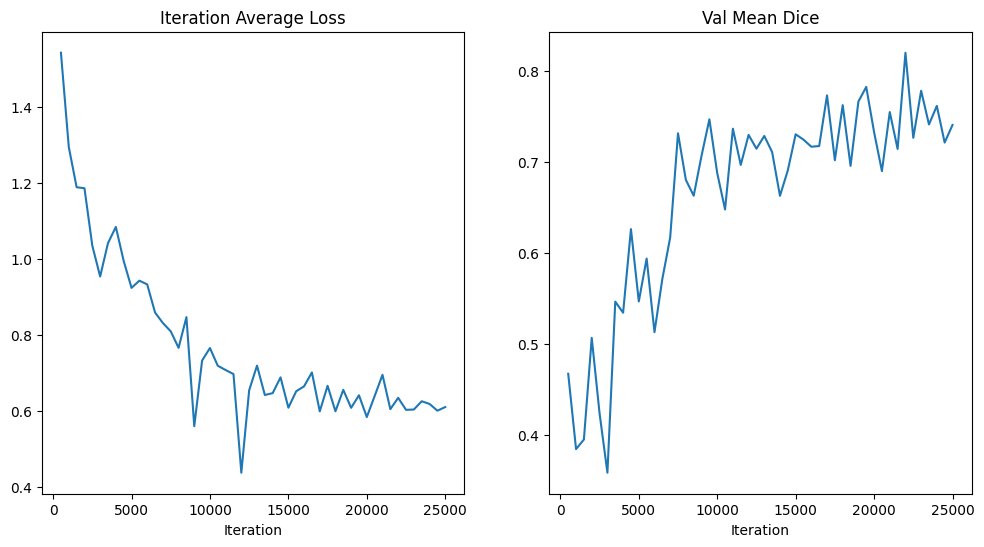

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 3
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_3.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold3_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold3_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=3.20553): 100%|█| 24/24 [00:14<00:00,  1.68it/
Training (47 / 25000 Steps) (loss=3.00794): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (71 / 25000 Steps) (loss=2.84851): 100%|█| 24/24 [00:12<00:00,  1.97it/
Training (95 / 25000 Steps) (loss=2.89214): 100%|█| 24/24 [00:12<00:00,  1.99it/
Training (119 / 25000 Steps) (loss=2.81788): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (143 / 25000 Steps) (loss=2.77576): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (167 / 25000 Steps) (loss=2.68394): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (191 / 25000 Steps) (loss=2.67187): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (215 / 25000 Steps) (loss=2.68900): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (239 / 25000 Steps) (loss=2.69481): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (263 / 25000 Steps) (loss=2.66465): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (287 / 25000 Steps) (loss=2.56076): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3392038345336914 Current Avg. Dice: 0.3392038345336914


Training (503 / 25000 Steps) (loss=2.33690): 100%|█| 24/24 [00:17<00:00,  1.37it
Training (527 / 25000 Steps) (loss=2.28135): 100%|█| 24/24 [00:12<00:00,  1.98it
Training (551 / 25000 Steps) (loss=2.28659): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (575 / 25000 Steps) (loss=2.28585): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (599 / 25000 Steps) (loss=2.20819): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (623 / 25000 Steps) (loss=2.19293): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (647 / 25000 Steps) (loss=2.17868): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (671 / 25000 Steps) (loss=2.13290): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (695 / 25000 Steps) (loss=2.22558): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (719 / 25000 Steps) (loss=2.31001): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (743 / 25000 Steps) (loss=2.17998): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (767 / 25000 Steps) (loss=2.15466): 100%|█| 24/24 [00:12<00:00,  1.97it
Training (791 / 25000 Steps)

Model Was Not Saved ! Current Best Avg. Dice: 0.3392038345336914 Current Avg. Dice: 0.27806854248046875


Training (1007 / 25000 Steps) (loss=2.00971): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (1031 / 25000 Steps) (loss=1.94539): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1055 / 25000 Steps) (loss=1.93140): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1079 / 25000 Steps) (loss=1.95031): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1103 / 25000 Steps) (loss=1.66891): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1127 / 25000 Steps) (loss=1.90964): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1151 / 25000 Steps) (loss=1.74961): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1175 / 25000 Steps) (loss=1.75416): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1199 / 25000 Steps) (loss=1.83940): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1223 / 25000 Steps) (loss=1.71995): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1247 / 25000 Steps) (loss=1.74215): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1271 / 25000 Steps) (loss=1.68700): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.3911169767379761 Current Avg. Dice: 0.3911169767379761


Training (1511 / 25000 Steps) (loss=1.51491): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (1535 / 25000 Steps) (loss=1.69412): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1559 / 25000 Steps) (loss=1.54460): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1583 / 25000 Steps) (loss=1.46004): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1607 / 25000 Steps) (loss=1.43591): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1631 / 25000 Steps) (loss=1.31044): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1655 / 25000 Steps) (loss=1.34863): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (1679 / 25000 Steps) (loss=1.36126): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1703 / 25000 Steps) (loss=1.40341): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=1.34529): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (1751 / 25000 Steps) (loss=1.33678): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1775 / 25000 Steps) (loss=1.22075): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.4392831325531006 Current Avg. Dice: 0.4392831325531006


Training (2015 / 25000 Steps) (loss=1.30135): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (2039 / 25000 Steps) (loss=1.34111): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2063 / 25000 Steps) (loss=1.22124): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2087 / 25000 Steps) (loss=1.18283): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2111 / 25000 Steps) (loss=1.21215): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2135 / 25000 Steps) (loss=1.29862): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2159 / 25000 Steps) (loss=1.23145): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2183 / 25000 Steps) (loss=1.21785): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2207 / 25000 Steps) (loss=1.26113): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2231 / 25000 Steps) (loss=1.12533): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2255 / 25000 Steps) (loss=1.25063): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2279 / 25000 Steps) (loss=1.47314): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4392831325531006 Current Avg. Dice: 0.43344607949256897


Training (2519 / 25000 Steps) (loss=1.11533): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (2543 / 25000 Steps) (loss=1.24604): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2567 / 25000 Steps) (loss=1.20572): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2591 / 25000 Steps) (loss=1.21030): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2615 / 25000 Steps) (loss=1.11398): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2639 / 25000 Steps) (loss=1.15312): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2663 / 25000 Steps) (loss=1.14393): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2687 / 25000 Steps) (loss=1.10807): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (2711 / 25000 Steps) (loss=1.04987): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2735 / 25000 Steps) (loss=1.04273): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2759 / 25000 Steps) (loss=1.07512): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2783 / 25000 Steps) (loss=1.06190): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.4392831325531006 Current Avg. Dice: 0.35122016072273254


Training (3023 / 25000 Steps) (loss=1.00697): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (3047 / 25000 Steps) (loss=1.01839): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3071 / 25000 Steps) (loss=1.05546): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3095 / 25000 Steps) (loss=1.01862): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3119 / 25000 Steps) (loss=1.12971): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3143 / 25000 Steps) (loss=0.97099): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3167 / 25000 Steps) (loss=0.96775): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3191 / 25000 Steps) (loss=1.09793): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3215 / 25000 Steps) (loss=1.03298): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3239 / 25000 Steps) (loss=0.97580): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3263 / 25000 Steps) (loss=1.09012): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3287 / 25000 Steps) (loss=1.00917): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.5375829339027405


Training (3503 / 25000 Steps) (loss=1.04925): 100%|█| 24/24 [00:17<00:00,  1.41i
Training (3527 / 25000 Steps) (loss=1.15701): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3551 / 25000 Steps) (loss=1.06630): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3575 / 25000 Steps) (loss=1.06252): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3599 / 25000 Steps) (loss=1.05150): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3623 / 25000 Steps) (loss=1.04398): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3647 / 25000 Steps) (loss=1.03843): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3671 / 25000 Steps) (loss=1.02519): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3695 / 25000 Steps) (loss=1.01918): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3719 / 25000 Steps) (loss=1.06528): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3743 / 25000 Steps) (loss=0.97883): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (3767 / 25000 Steps) (loss=1.07776): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.41799870133399963


Training (4007 / 25000 Steps) (loss=0.94359): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4031 / 25000 Steps) (loss=1.03119): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4055 / 25000 Steps) (loss=1.18550): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4079 / 25000 Steps) (loss=0.95221): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4103 / 25000 Steps) (loss=1.12613): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4127 / 25000 Steps) (loss=1.06080): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4151 / 25000 Steps) (loss=0.96626): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4175 / 25000 Steps) (loss=0.98783): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4199 / 25000 Steps) (loss=1.13388): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4223 / 25000 Steps) (loss=0.96899): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4247 / 25000 Steps) (loss=0.97756): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4271 / 25000 Steps) (loss=1.00211): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.504210889339447


Training (4511 / 25000 Steps) (loss=0.96758): 100%|█| 24/24 [00:13<00:00,  1.78i
Training (4535 / 25000 Steps) (loss=1.12904): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4559 / 25000 Steps) (loss=0.95248): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4583 / 25000 Steps) (loss=0.88184): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4607 / 25000 Steps) (loss=0.96591): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4631 / 25000 Steps) (loss=0.95103): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4655 / 25000 Steps) (loss=0.86522): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4679 / 25000 Steps) (loss=1.00583): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4703 / 25000 Steps) (loss=0.95160): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (4727 / 25000 Steps) (loss=1.00573): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4751 / 25000 Steps) (loss=0.94828): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4775 / 25000 Steps) (loss=0.91241): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.5132097601890564


Training (5015 / 25000 Steps) (loss=0.90215): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5039 / 25000 Steps) (loss=0.92091): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5063 / 25000 Steps) (loss=0.95596): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5087 / 25000 Steps) (loss=0.93636): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5111 / 25000 Steps) (loss=0.87982): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5135 / 25000 Steps) (loss=0.87943): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5159 / 25000 Steps) (loss=0.87665): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5183 / 25000 Steps) (loss=0.87946): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5207 / 25000 Steps) (loss=0.88712): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5231 / 25000 Steps) (loss=0.97779): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5255 / 25000 Steps) (loss=0.86774): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5279 / 25000 Steps) (loss=0.97355): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.4866674840450287


Training (5519 / 25000 Steps) (loss=0.90338): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (5543 / 25000 Steps) (loss=0.92295): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5567 / 25000 Steps) (loss=0.82544): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5591 / 25000 Steps) (loss=1.02125): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5615 / 25000 Steps) (loss=0.85236): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5639 / 25000 Steps) (loss=0.93732): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5663 / 25000 Steps) (loss=0.97441): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5687 / 25000 Steps) (loss=0.83301): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5711 / 25000 Steps) (loss=0.89956): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5735 / 25000 Steps) (loss=0.77336): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (5759 / 25000 Steps) (loss=0.77136): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5783 / 25000 Steps) (loss=0.88619): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (5807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.5375829339027405 Current Avg. Dice: 0.5162799954414368


Training (6023 / 25000 Steps) (loss=0.85626): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (6047 / 25000 Steps) (loss=1.03176): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6071 / 25000 Steps) (loss=0.83876): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6095 / 25000 Steps) (loss=0.78275): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6119 / 25000 Steps) (loss=0.85406): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6143 / 25000 Steps) (loss=0.80603): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6167 / 25000 Steps) (loss=0.80436): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6191 / 25000 Steps) (loss=0.88109): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6215 / 25000 Steps) (loss=0.87564): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6239 / 25000 Steps) (loss=0.86815): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6263 / 25000 Steps) (loss=0.87080): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6287 / 25000 Steps) (loss=1.00663): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5885868072509766 Current Avg. Dice: 0.5885868072509766


Training (6503 / 25000 Steps) (loss=0.75887): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (6527 / 25000 Steps) (loss=0.85556): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6551 / 25000 Steps) (loss=0.99443): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6575 / 25000 Steps) (loss=0.89656): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6599 / 25000 Steps) (loss=0.79512): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (6623 / 25000 Steps) (loss=0.83117): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6647 / 25000 Steps) (loss=0.81029): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6671 / 25000 Steps) (loss=0.79189): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6695 / 25000 Steps) (loss=0.79391): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6719 / 25000 Steps) (loss=0.84690): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6743 / 25000 Steps) (loss=0.87574): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6767 / 25000 Steps) (loss=0.83809): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (6791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.596065104007721 Current Avg. Dice: 0.596065104007721


Training (7007 / 25000 Steps) (loss=0.88538): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (7031 / 25000 Steps) (loss=0.90454): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7055 / 25000 Steps) (loss=0.78224): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7079 / 25000 Steps) (loss=0.80907): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7103 / 25000 Steps) (loss=0.94966): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7127 / 25000 Steps) (loss=0.83493): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7151 / 25000 Steps) (loss=0.72185): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7175 / 25000 Steps) (loss=1.13417): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7199 / 25000 Steps) (loss=0.71972): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7223 / 25000 Steps) (loss=0.67484): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7247 / 25000 Steps) (loss=0.76247): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7271 / 25000 Steps) (loss=0.77876): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6219969391822815 Current Avg. Dice: 0.6219969391822815


Training (7511 / 25000 Steps) (loss=0.75684): 100%|█| 24/24 [00:18<00:00,  1.33i
Training (7535 / 25000 Steps) (loss=0.84571): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7559 / 25000 Steps) (loss=0.76356): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7583 / 25000 Steps) (loss=0.85003): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7607 / 25000 Steps) (loss=0.79167): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7631 / 25000 Steps) (loss=0.71128): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7655 / 25000 Steps) (loss=0.80749): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (7679 / 25000 Steps) (loss=0.73140): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7703 / 25000 Steps) (loss=0.71971): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7727 / 25000 Steps) (loss=0.75223): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7751 / 25000 Steps) (loss=0.77807): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7775 / 25000 Steps) (loss=0.79442): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6219969391822815 Current Avg. Dice: 0.6129787564277649


Training (8015 / 25000 Steps) (loss=0.65794): 100%|█| 24/24 [00:13<00:00,  1.77i
Training (8039 / 25000 Steps) (loss=0.84272): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8063 / 25000 Steps) (loss=0.83938): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8087 / 25000 Steps) (loss=0.90377): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8111 / 25000 Steps) (loss=0.77568): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8135 / 25000 Steps) (loss=0.86605): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8159 / 25000 Steps) (loss=0.84990): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8183 / 25000 Steps) (loss=0.70604): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8207 / 25000 Steps) (loss=0.63471): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8231 / 25000 Steps) (loss=0.85143): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8255 / 25000 Steps) (loss=0.86118): 100%|█| 24/24 [00:12<00:00,  1.99i
Training (8279 / 25000 Steps) (loss=0.59602): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6257515549659729 Current Avg. Dice: 0.6257515549659729


Training (8519 / 25000 Steps) (loss=0.89049): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (8543 / 25000 Steps) (loss=0.73790): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8567 / 25000 Steps) (loss=0.72940): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8591 / 25000 Steps) (loss=0.63324): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8615 / 25000 Steps) (loss=0.72329): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8639 / 25000 Steps) (loss=0.73476): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (8663 / 25000 Steps) (loss=0.72591): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (8687 / 25000 Steps) (loss=0.54462): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (8711 / 25000 Steps) (loss=0.62340): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (8735 / 25000 Steps) (loss=0.72904): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8759 / 25000 Steps) (loss=0.77113): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8783 / 25000 Steps) (loss=0.66640): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6761643886566162


Training (9023 / 25000 Steps) (loss=0.72619): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (9047 / 25000 Steps) (loss=0.62786): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9071 / 25000 Steps) (loss=0.78858): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9095 / 25000 Steps) (loss=0.80262): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9119 / 25000 Steps) (loss=0.89353): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9143 / 25000 Steps) (loss=0.78608): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9167 / 25000 Steps) (loss=0.59482): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9191 / 25000 Steps) (loss=0.69757): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9215 / 25000 Steps) (loss=0.68396): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9239 / 25000 Steps) (loss=0.79204): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9263 / 25000 Steps) (loss=0.60913): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9287 / 25000 Steps) (loss=0.58299): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6537558436393738


Training (9503 / 25000 Steps) (loss=0.59817): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (9527 / 25000 Steps) (loss=0.71109): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9551 / 25000 Steps) (loss=0.65574): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9575 / 25000 Steps) (loss=0.66418): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9599 / 25000 Steps) (loss=0.62124): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9623 / 25000 Steps) (loss=0.77595): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9647 / 25000 Steps) (loss=0.69751): 100%|█| 24/24 [00:12<00:00,  1.98i
Training (9671 / 25000 Steps) (loss=0.80140): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9695 / 25000 Steps) (loss=0.81470): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (9719 / 25000 Steps) (loss=0.70673): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9743 / 25000 Steps) (loss=0.63389): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9767 / 25000 Steps) (loss=0.71772): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.5715979337692261


Training (10007 / 25000 Steps) (loss=0.80565): 100%|█| 24/24 [00:13<00:00,  1.75
Training (10031 / 25000 Steps) (loss=0.74648): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10055 / 25000 Steps) (loss=0.71049): 100%|█| 24/24 [00:12<00:00,  1.91
Training (10079 / 25000 Steps) (loss=0.71510): 100%|█| 24/24 [00:12<00:00,  1.95
Training (10103 / 25000 Steps) (loss=0.62517): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10127 / 25000 Steps) (loss=0.76556): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10151 / 25000 Steps) (loss=0.68474): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10175 / 25000 Steps) (loss=0.77469): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10199 / 25000 Steps) (loss=0.69157): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10223 / 25000 Steps) (loss=0.72887): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10247 / 25000 Steps) (loss=0.66818): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10271 / 25000 Steps) (loss=0.64840): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6616269946098328


Training (10511 / 25000 Steps) (loss=0.64568): 100%|█| 24/24 [00:13<00:00,  1.77
Training (10535 / 25000 Steps) (loss=0.64348): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10559 / 25000 Steps) (loss=0.61331): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10583 / 25000 Steps) (loss=0.73197): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10607 / 25000 Steps) (loss=0.92996): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10631 / 25000 Steps) (loss=0.80194): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10655 / 25000 Steps) (loss=0.73089): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10679 / 25000 Steps) (loss=0.49375): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10703 / 25000 Steps) (loss=0.80931): 100%|█| 24/24 [00:12<00:00,  1.99
Training (10727 / 25000 Steps) (loss=0.82367): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10751 / 25000 Steps) (loss=0.62155): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10775 / 25000 Steps) (loss=0.66852): 100%|█| 24/24 [00:12<00:00,  1.98
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6192938685417175


Training (11015 / 25000 Steps) (loss=0.56824): 100%|█| 24/24 [00:13<00:00,  1.78
Training (11039 / 25000 Steps) (loss=0.74229): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11063 / 25000 Steps) (loss=0.55143): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11087 / 25000 Steps) (loss=0.75472): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11111 / 25000 Steps) (loss=0.64590): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11135 / 25000 Steps) (loss=0.84182): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11159 / 25000 Steps) (loss=0.73932): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11183 / 25000 Steps) (loss=0.55601): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11207 / 25000 Steps) (loss=0.62494): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11231 / 25000 Steps) (loss=0.69488): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11255 / 25000 Steps) (loss=0.57894): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11279 / 25000 Steps) (loss=0.56752): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6258983016014099


Training (11519 / 25000 Steps) (loss=0.75921): 100%|█| 24/24 [00:13<00:00,  1.77
Training (11543 / 25000 Steps) (loss=0.44045): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11567 / 25000 Steps) (loss=0.74779): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11591 / 25000 Steps) (loss=0.61830): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11615 / 25000 Steps) (loss=0.65442): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11639 / 25000 Steps) (loss=0.88086): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11663 / 25000 Steps) (loss=0.70425): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11687 / 25000 Steps) (loss=0.67564): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11711 / 25000 Steps) (loss=0.57061): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11735 / 25000 Steps) (loss=0.80818): 100%|█| 24/24 [00:12<00:00,  1.99
Training (11759 / 25000 Steps) (loss=0.89060): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11783 / 25000 Steps) (loss=0.57225): 100%|█| 24/24 [00:12<00:00,  1.98
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6387816071510315


Training (12023 / 25000 Steps) (loss=0.72421): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12047 / 25000 Steps) (loss=0.68009): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12071 / 25000 Steps) (loss=0.67670): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12095 / 25000 Steps) (loss=0.70318): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12119 / 25000 Steps) (loss=0.71418): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12143 / 25000 Steps) (loss=0.86283): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12167 / 25000 Steps) (loss=0.57843): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12191 / 25000 Steps) (loss=0.67819): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12215 / 25000 Steps) (loss=0.63280): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12239 / 25000 Steps) (loss=0.62459): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12263 / 25000 Steps) (loss=0.62912): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12287 / 25000 Steps) (loss=0.58218): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6582589149475098


Training (12503 / 25000 Steps) (loss=0.87188): 100%|█| 24/24 [00:13<00:00,  1.77
Training (12527 / 25000 Steps) (loss=0.79259): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12551 / 25000 Steps) (loss=0.48725): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12575 / 25000 Steps) (loss=0.58915): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12599 / 25000 Steps) (loss=0.80130): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12623 / 25000 Steps) (loss=0.69042): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12647 / 25000 Steps) (loss=0.79679): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12671 / 25000 Steps) (loss=0.74464): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12695 / 25000 Steps) (loss=0.61920): 100%|█| 24/24 [00:12<00:00,  1.98
Training (12719 / 25000 Steps) (loss=0.58996): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12743 / 25000 Steps) (loss=0.63435): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12767 / 25000 Steps) (loss=0.66284): 100%|█| 24/24 [00:12<00:00,  1.99
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6761643886566162 Current Avg. Dice: 0.6706025004386902


Training (13007 / 25000 Steps) (loss=0.58262): 100%|█| 24/24 [00:13<00:00,  1.77
Training (13031 / 25000 Steps) (loss=0.72311): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13055 / 25000 Steps) (loss=0.66472): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13079 / 25000 Steps) (loss=0.73573): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13103 / 25000 Steps) (loss=0.66512): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13127 / 25000 Steps) (loss=0.75731): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13151 / 25000 Steps) (loss=0.83436): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13175 / 25000 Steps) (loss=0.77711): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13199 / 25000 Steps) (loss=0.63698): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13223 / 25000 Steps) (loss=0.81462): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13247 / 25000 Steps) (loss=0.55375): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13271 / 25000 Steps) (loss=0.59610): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6821663975715637


Training (13511 / 25000 Steps) (loss=0.43940): 100%|█| 24/24 [00:17<00:00,  1.41
Training (13535 / 25000 Steps) (loss=0.62291): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13559 / 25000 Steps) (loss=0.44174): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13583 / 25000 Steps) (loss=0.75879): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13607 / 25000 Steps) (loss=0.58550): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13631 / 25000 Steps) (loss=0.60812): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13655 / 25000 Steps) (loss=0.73313): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13679 / 25000 Steps) (loss=0.76797): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13703 / 25000 Steps) (loss=0.71469): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13727 / 25000 Steps) (loss=0.73507): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13751 / 25000 Steps) (loss=0.70955): 100%|█| 24/24 [00:12<00:00,  1.99
Training (13775 / 25000 Steps) (loss=0.73265): 100%|█| 24/24 [00:12<00:00,  1.98
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6692962646484375


Training (14015 / 25000 Steps) (loss=0.78525): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14039 / 25000 Steps) (loss=0.53518): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14063 / 25000 Steps) (loss=0.52941): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14087 / 25000 Steps) (loss=0.60583): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14111 / 25000 Steps) (loss=0.60892): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14135 / 25000 Steps) (loss=0.65317): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14159 / 25000 Steps) (loss=0.60867): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14183 / 25000 Steps) (loss=0.56552): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14207 / 25000 Steps) (loss=0.45361): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14231 / 25000 Steps) (loss=0.66098): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14255 / 25000 Steps) (loss=0.74056): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14279 / 25000 Steps) (loss=0.60603): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.61045241355896


Training (14519 / 25000 Steps) (loss=0.68442): 100%|█| 24/24 [00:13<00:00,  1.77
Training (14543 / 25000 Steps) (loss=0.77005): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14567 / 25000 Steps) (loss=0.54659): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14591 / 25000 Steps) (loss=0.67782): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14615 / 25000 Steps) (loss=0.60379): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14639 / 25000 Steps) (loss=0.71135): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14663 / 25000 Steps) (loss=0.62902): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14687 / 25000 Steps) (loss=0.55354): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14711 / 25000 Steps) (loss=0.66488): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14735 / 25000 Steps) (loss=0.78954): 100%|█| 24/24 [00:12<00:00,  1.99
Training (14759 / 25000 Steps) (loss=0.53416): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14783 / 25000 Steps) (loss=0.55480): 100%|█| 24/24 [00:12<00:00,  1.98
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6584080457687378


Training (15023 / 25000 Steps) (loss=0.68721): 100%|█| 24/24 [00:13<00:00,  1.77
Training (15047 / 25000 Steps) (loss=0.53956): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15071 / 25000 Steps) (loss=0.71414): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15095 / 25000 Steps) (loss=0.59839): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15119 / 25000 Steps) (loss=0.59310): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15143 / 25000 Steps) (loss=0.48219): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15167 / 25000 Steps) (loss=0.62101): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15191 / 25000 Steps) (loss=0.68145): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15215 / 25000 Steps) (loss=0.65806): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15239 / 25000 Steps) (loss=0.68853): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15263 / 25000 Steps) (loss=0.65055): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15287 / 25000 Steps) (loss=0.70305): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6201297640800476


Training (15503 / 25000 Steps) (loss=0.72687): 100%|█| 24/24 [00:13<00:00,  1.76
Training (15527 / 25000 Steps) (loss=0.58998): 100%|█| 24/24 [00:12<00:00,  1.99
Training (15551 / 25000 Steps) (loss=0.69048): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15575 / 25000 Steps) (loss=0.78359): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15599 / 25000 Steps) (loss=0.72409): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15623 / 25000 Steps) (loss=0.77051): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15647 / 25000 Steps) (loss=0.70287): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15671 / 25000 Steps) (loss=0.63662): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15695 / 25000 Steps) (loss=0.79358): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15719 / 25000 Steps) (loss=0.73713): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15743 / 25000 Steps) (loss=0.74846): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15767 / 25000 Steps) (loss=0.63643): 100%|█| 24/24 [00:12<00:00,  1.98
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6417763233184814


Training (16007 / 25000 Steps) (loss=0.65073): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16031 / 25000 Steps) (loss=0.56530): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16055 / 25000 Steps) (loss=0.72446): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16079 / 25000 Steps) (loss=0.55203): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16103 / 25000 Steps) (loss=0.61692): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16127 / 25000 Steps) (loss=0.66297): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16151 / 25000 Steps) (loss=0.71999): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16175 / 25000 Steps) (loss=0.64566): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16199 / 25000 Steps) (loss=0.55460): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16223 / 25000 Steps) (loss=0.59360): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16247 / 25000 Steps) (loss=0.52469): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16271 / 25000 Steps) (loss=0.40929): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6821663975715637 Current Avg. Dice: 0.6557685732841492


Training (16511 / 25000 Steps) (loss=0.72083): 100%|█| 24/24 [00:13<00:00,  1.77
Training (16535 / 25000 Steps) (loss=0.76029): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16559 / 25000 Steps) (loss=0.62233): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16583 / 25000 Steps) (loss=0.80969): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16607 / 25000 Steps) (loss=0.61013): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16631 / 25000 Steps) (loss=0.66301): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16655 / 25000 Steps) (loss=0.54703): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16679 / 25000 Steps) (loss=0.60968): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16703 / 25000 Steps) (loss=0.70308): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16727 / 25000 Steps) (loss=0.58659): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16751 / 25000 Steps) (loss=0.82842): 100%|█| 24/24 [00:12<00:00,  1.98
Training (16775 / 25000 Steps) (loss=0.52643): 100%|█| 24/24 [00:12<00:00,  1.99
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7099967002868652 Current Avg. Dice: 0.7099967002868652


Training (17015 / 25000 Steps) (loss=0.58139): 100%|█| 24/24 [00:17<00:00,  1.41
Training (17039 / 25000 Steps) (loss=0.73045): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17063 / 25000 Steps) (loss=0.58957): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17087 / 25000 Steps) (loss=0.64333): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17111 / 25000 Steps) (loss=0.64003): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17135 / 25000 Steps) (loss=0.43951): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17159 / 25000 Steps) (loss=0.69508): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17183 / 25000 Steps) (loss=0.60204): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17207 / 25000 Steps) (loss=0.57218): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17231 / 25000 Steps) (loss=0.78733): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17255 / 25000 Steps) (loss=0.80288): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17279 / 25000 Steps) (loss=0.71625): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7099967002868652 Current Avg. Dice: 0.6343178153038025


Training (17519 / 25000 Steps) (loss=0.64279): 100%|█| 24/24 [00:13<00:00,  1.77
Training (17543 / 25000 Steps) (loss=0.69521): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17567 / 25000 Steps) (loss=0.68727): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17591 / 25000 Steps) (loss=0.63770): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17615 / 25000 Steps) (loss=0.66382): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17639 / 25000 Steps) (loss=0.50298): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17663 / 25000 Steps) (loss=0.60837): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17687 / 25000 Steps) (loss=0.48473): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17711 / 25000 Steps) (loss=0.53054): 100%|█| 24/24 [00:12<00:00,  1.99
Training (17735 / 25000 Steps) (loss=0.64197): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17759 / 25000 Steps) (loss=0.68156): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17783 / 25000 Steps) (loss=0.49658): 100%|█| 24/24 [00:12<00:00,  1.98
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.7631961703300476


Training (18023 / 25000 Steps) (loss=0.55661): 100%|█| 24/24 [00:17<00:00,  1.41
Training (18047 / 25000 Steps) (loss=0.66941): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18071 / 25000 Steps) (loss=0.40368): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18095 / 25000 Steps) (loss=0.69088): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18119 / 25000 Steps) (loss=0.52076): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18143 / 25000 Steps) (loss=0.54720): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18167 / 25000 Steps) (loss=0.50134): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.41593): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18215 / 25000 Steps) (loss=0.54357): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18239 / 25000 Steps) (loss=0.73162): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18263 / 25000 Steps) (loss=0.48240): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18287 / 25000 Steps) (loss=0.68673): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6761301159858704


Training (18503 / 25000 Steps) (loss=0.56165): 100%|█| 24/24 [00:13<00:00,  1.78
Training (18527 / 25000 Steps) (loss=0.74604): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18551 / 25000 Steps) (loss=0.51235): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18575 / 25000 Steps) (loss=0.58586): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18599 / 25000 Steps) (loss=0.56596): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18623 / 25000 Steps) (loss=0.64450): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18647 / 25000 Steps) (loss=0.42367): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18671 / 25000 Steps) (loss=0.71211): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18695 / 25000 Steps) (loss=0.47035): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18719 / 25000 Steps) (loss=0.60071): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18743 / 25000 Steps) (loss=0.61882): 100%|█| 24/24 [00:12<00:00,  1.98
Training (18767 / 25000 Steps) (loss=0.77123): 100%|█| 24/24 [00:12<00:00,  1.99
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6939241290092468


Training (19007 / 25000 Steps) (loss=0.55544): 100%|█| 24/24 [00:13<00:00,  1.77
Training (19031 / 25000 Steps) (loss=0.61863): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19055 / 25000 Steps) (loss=0.63963): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19079 / 25000 Steps) (loss=0.79569): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19103 / 25000 Steps) (loss=0.56786): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19127 / 25000 Steps) (loss=0.77141): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19151 / 25000 Steps) (loss=0.62586): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19175 / 25000 Steps) (loss=0.63270): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19199 / 25000 Steps) (loss=0.55063): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19223 / 25000 Steps) (loss=0.44740): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19247 / 25000 Steps) (loss=0.65874): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19271 / 25000 Steps) (loss=0.52887): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.7173183560371399


Training (19511 / 25000 Steps) (loss=0.75646): 100%|█| 24/24 [00:13<00:00,  1.77
Training (19535 / 25000 Steps) (loss=0.65977): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19559 / 25000 Steps) (loss=0.80327): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19583 / 25000 Steps) (loss=0.64472): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19607 / 25000 Steps) (loss=0.53188): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19631 / 25000 Steps) (loss=0.65475): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19655 / 25000 Steps) (loss=0.46888): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19679 / 25000 Steps) (loss=0.75624): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19703 / 25000 Steps) (loss=0.69645): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19727 / 25000 Steps) (loss=0.72493): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19751 / 25000 Steps) (loss=0.72678): 100%|█| 24/24 [00:12<00:00,  1.99
Training (19775 / 25000 Steps) (loss=0.49411): 100%|█| 24/24 [00:12<00:00,  1.98
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6969254612922668


Training (20015 / 25000 Steps) (loss=0.62342): 100%|█| 24/24 [00:13<00:00,  1.77
Training (20039 / 25000 Steps) (loss=0.45649): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.61006): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20087 / 25000 Steps) (loss=0.60773): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20111 / 25000 Steps) (loss=0.42178): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20135 / 25000 Steps) (loss=0.65542): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20159 / 25000 Steps) (loss=0.57675): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20183 / 25000 Steps) (loss=0.57024): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20207 / 25000 Steps) (loss=0.54265): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20231 / 25000 Steps) (loss=0.59959): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20255 / 25000 Steps) (loss=0.45653): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20279 / 25000 Steps) (loss=0.50329): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.688227117061615


Training (20519 / 25000 Steps) (loss=0.68021): 100%|█| 24/24 [00:13<00:00,  1.78
Training (20543 / 25000 Steps) (loss=0.55652): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20567 / 25000 Steps) (loss=0.80274): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20591 / 25000 Steps) (loss=0.55120): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20615 / 25000 Steps) (loss=0.72287): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20639 / 25000 Steps) (loss=0.65638): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20663 / 25000 Steps) (loss=0.49192): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20687 / 25000 Steps) (loss=0.66896): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20711 / 25000 Steps) (loss=0.55316): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20735 / 25000 Steps) (loss=0.65234): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20759 / 25000 Steps) (loss=0.85183): 100%|█| 24/24 [00:12<00:00,  1.99
Training (20783 / 25000 Steps) (loss=0.61780): 100%|█| 24/24 [00:12<00:00,  1.98
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6853920817375183


Training (21023 / 25000 Steps) (loss=0.59151): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21047 / 25000 Steps) (loss=0.82887): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21071 / 25000 Steps) (loss=0.69743): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21095 / 25000 Steps) (loss=0.58990): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21119 / 25000 Steps) (loss=0.74230): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21143 / 25000 Steps) (loss=0.50383): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21167 / 25000 Steps) (loss=0.75940): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21191 / 25000 Steps) (loss=0.63764): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21215 / 25000 Steps) (loss=0.70631): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21239 / 25000 Steps) (loss=0.50059): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21263 / 25000 Steps) (loss=0.63297): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21287 / 25000 Steps) (loss=0.42601): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6494666934013367


Training (21503 / 25000 Steps) (loss=0.46557): 100%|█| 24/24 [00:13<00:00,  1.77
Training (21527 / 25000 Steps) (loss=0.60234): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21551 / 25000 Steps) (loss=0.50216): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21575 / 25000 Steps) (loss=0.53090): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21599 / 25000 Steps) (loss=0.63858): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21623 / 25000 Steps) (loss=0.44715): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21647 / 25000 Steps) (loss=0.55506): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21671 / 25000 Steps) (loss=0.63357): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21695 / 25000 Steps) (loss=0.40140): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21719 / 25000 Steps) (loss=0.60230): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21743 / 25000 Steps) (loss=0.71771): 100%|█| 24/24 [00:12<00:00,  1.99
Training (21767 / 25000 Steps) (loss=0.63962): 100%|█| 24/24 [00:12<00:00,  1.98
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6923648715019226


Training (22007 / 25000 Steps) (loss=0.65793): 100%|█| 24/24 [00:13<00:00,  1.77
Training (22031 / 25000 Steps) (loss=0.64444): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22055 / 25000 Steps) (loss=0.58781): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22079 / 25000 Steps) (loss=0.65797): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22103 / 25000 Steps) (loss=0.35778): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22127 / 25000 Steps) (loss=0.44614): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22151 / 25000 Steps) (loss=0.54695): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22175 / 25000 Steps) (loss=0.63281): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22199 / 25000 Steps) (loss=0.56398): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22223 / 25000 Steps) (loss=0.51558): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22247 / 25000 Steps) (loss=0.58924): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22271 / 25000 Steps) (loss=0.51755): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.7103938460350037


Training (22511 / 25000 Steps) (loss=0.48921): 100%|█| 24/24 [00:13<00:00,  1.78
Training (22535 / 25000 Steps) (loss=0.59911): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22559 / 25000 Steps) (loss=0.54480): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22583 / 25000 Steps) (loss=0.63023): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22607 / 25000 Steps) (loss=0.64261): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22631 / 25000 Steps) (loss=0.60204): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22655 / 25000 Steps) (loss=0.67655): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22679 / 25000 Steps) (loss=0.58837): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22703 / 25000 Steps) (loss=0.38024): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22727 / 25000 Steps) (loss=0.62839): 100%|█| 24/24 [00:12<00:00,  1.99
Training (22751 / 25000 Steps) (loss=0.47480): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22775 / 25000 Steps) (loss=0.79564): 100%|█| 24/24 [00:12<00:00,  1.98
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6966080665588379


Training (23015 / 25000 Steps) (loss=0.64537): 100%|█| 24/24 [00:13<00:00,  1.76
Training (23039 / 25000 Steps) (loss=0.79958): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23063 / 25000 Steps) (loss=0.66201): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23087 / 25000 Steps) (loss=0.77613): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23111 / 25000 Steps) (loss=0.67810): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23135 / 25000 Steps) (loss=0.62315): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23159 / 25000 Steps) (loss=0.71131): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23183 / 25000 Steps) (loss=0.60500): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23207 / 25000 Steps) (loss=0.48220): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23231 / 25000 Steps) (loss=0.56366): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23255 / 25000 Steps) (loss=0.70732): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23279 / 25000 Steps) (loss=0.57207): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6821509003639221


Training (23519 / 25000 Steps) (loss=0.64204): 100%|█| 24/24 [00:13<00:00,  1.77
Training (23543 / 25000 Steps) (loss=0.50844): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23567 / 25000 Steps) (loss=0.56200): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23591 / 25000 Steps) (loss=0.72763): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23615 / 25000 Steps) (loss=0.58307): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23639 / 25000 Steps) (loss=0.69843): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23663 / 25000 Steps) (loss=0.77117): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23687 / 25000 Steps) (loss=0.67831): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23711 / 25000 Steps) (loss=0.67951): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23735 / 25000 Steps) (loss=0.68349): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23759 / 25000 Steps) (loss=0.43606): 100%|█| 24/24 [00:12<00:00,  1.99
Training (23783 / 25000 Steps) (loss=0.54656): 100%|█| 24/24 [00:12<00:00,  1.98
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.7018342018127441


Training (24023 / 25000 Steps) (loss=0.63512): 100%|█| 24/24 [00:13<00:00,  1.77
Training (24047 / 25000 Steps) (loss=0.43215): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24071 / 25000 Steps) (loss=0.70385): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24095 / 25000 Steps) (loss=0.57915): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24119 / 25000 Steps) (loss=0.68464): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24143 / 25000 Steps) (loss=0.74849): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24167 / 25000 Steps) (loss=0.64119): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24191 / 25000 Steps) (loss=0.53143): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24215 / 25000 Steps) (loss=0.63812): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24239 / 25000 Steps) (loss=0.56499): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24263 / 25000 Steps) (loss=0.61035): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24287 / 25000 Steps) (loss=0.53635): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.7279836535453796


Training (24503 / 25000 Steps) (loss=0.71305): 100%|█| 24/24 [00:13<00:00,  1.78
Training (24527 / 25000 Steps) (loss=0.52636): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24551 / 25000 Steps) (loss=0.60591): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24575 / 25000 Steps) (loss=0.54220): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24599 / 25000 Steps) (loss=0.61906): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24623 / 25000 Steps) (loss=0.67215): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24647 / 25000 Steps) (loss=0.41234): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24671 / 25000 Steps) (loss=0.67257): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24695 / 25000 Steps) (loss=0.62688): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24719 / 25000 Steps) (loss=0.47044): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24743 / 25000 Steps) (loss=0.70999): 100%|█| 24/24 [00:12<00:00,  1.99
Training (24767 / 25000 Steps) (loss=0.54534): 100%|█| 24/24 [00:12<00:00,  1.98
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7631961703300476 Current Avg. Dice: 0.6548466086387634


Training (25007 / 25000 Steps) (loss=0.61751): 100%|█| 24/24 [00:13<00:00,  1.77


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7632 at iteration: 18000


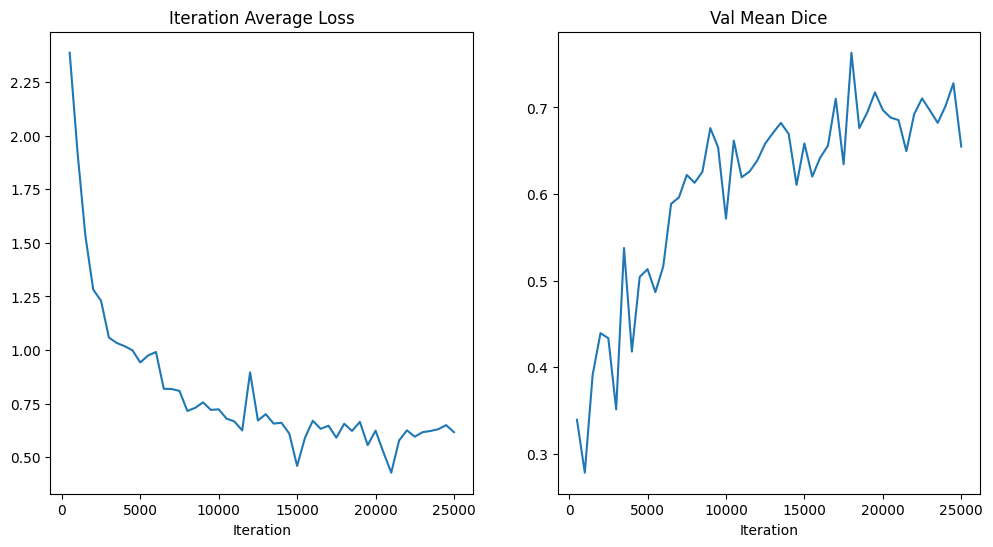

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [5]:
#fold 4
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"
split_json = "dataset_4.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,#24
    cache_rate=1.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)#cache_num=6
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.10it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
import torch, gc
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda()
                                      , batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonword82_best_metric_model.pth")))
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         print(x.shape,y.shape)
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold4_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
#         gc.collect()
#         torch.cuda.empty_cache()
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 25000
eval_num = 500#500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_pretrainonwordfintuneonmiccai_fold4_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=2.89673): 100%|█| 24/24 [00:14<00:00,  1.66it/
Training (47 / 25000 Steps) (loss=2.60841): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (71 / 25000 Steps) (loss=2.67479): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (95 / 25000 Steps) (loss=2.39451): 100%|█| 24/24 [00:12<00:00,  1.95it/
Training (119 / 25000 Steps) (loss=2.70966): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (143 / 25000 Steps) (loss=2.38928): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (167 / 25000 Steps) (loss=2.49652): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (191 / 25000 Steps) (loss=2.54339): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (215 / 25000 Steps) (loss=2.34504): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (239 / 25000 Steps) (loss=2.30578): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (263 / 25000 Steps) (loss=2.33994): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (287 / 25000 Steps) (loss=2.58933): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.3154307007789612 Current Avg. Dice: 0.3154307007789612


Training (503 / 25000 Steps) (loss=1.86556): 100%|█| 24/24 [00:18<00:00,  1.33it
Training (527 / 25000 Steps) (loss=2.02328): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (551 / 25000 Steps) (loss=2.03161): 100%|█| 24/24 [00:12<00:00,  1.96it
Training (575 / 25000 Steps) (loss=1.94023): 100%|█| 24/24 [00:12<00:00,  1.93it
Training (599 / 25000 Steps) (loss=2.02962): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (623 / 25000 Steps) (loss=1.73312): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (647 / 25000 Steps) (loss=1.76183): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (671 / 25000 Steps) (loss=1.95957): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (695 / 25000 Steps) (loss=2.08535): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (719 / 25000 Steps) (loss=1.77357): 100%|█| 24/24 [00:12<00:00,  1.95it
Training (743 / 25000 Steps) (loss=1.70641): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (767 / 25000 Steps) (loss=1.64836): 100%|█| 24/24 [00:12<00:00,  1.94it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.38037076592445374 Current Avg. Dice: 0.38037076592445374


Training (1007 / 25000 Steps) (loss=1.50892): 100%|█| 24/24 [00:17<00:00,  1.37i
Training (1031 / 25000 Steps) (loss=1.43958): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1055 / 25000 Steps) (loss=1.49012): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1079 / 25000 Steps) (loss=1.60251): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1103 / 25000 Steps) (loss=1.54139): 100%|█| 24/24 [00:12<00:00,  1.93i
Training (1127 / 25000 Steps) (loss=1.42476): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1151 / 25000 Steps) (loss=1.35560): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1175 / 25000 Steps) (loss=1.41745): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1199 / 25000 Steps) (loss=1.37966): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1223 / 25000 Steps) (loss=1.41663): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1247 / 25000 Steps) (loss=1.40403): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1271 / 25000 Steps) (loss=1.32786): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.46030864119529724 Current Avg. Dice: 0.46030864119529724


Training (1511 / 25000 Steps) (loss=1.25833): 100%|█| 24/24 [00:17<00:00,  1.38i
Training (1535 / 25000 Steps) (loss=1.17479): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1559 / 25000 Steps) (loss=1.37098): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1583 / 25000 Steps) (loss=1.23281): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1607 / 25000 Steps) (loss=1.45838): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1631 / 25000 Steps) (loss=1.23256): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1655 / 25000 Steps) (loss=1.23845): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1679 / 25000 Steps) (loss=1.13197): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1703 / 25000 Steps) (loss=1.24188): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1727 / 25000 Steps) (loss=1.20201): 100%|█| 24/24 [00:12<00:00,  1.94i
Training (1751 / 25000 Steps) (loss=1.15176): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (1775 / 25000 Steps) (loss=1.12655): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (1799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.46030864119529724 Current Avg. Dice: 0.38385844230651855


Training (2015 / 25000 Steps) (loss=1.17201): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (2039 / 25000 Steps) (loss=1.21998): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2063 / 25000 Steps) (loss=1.11586): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2087 / 25000 Steps) (loss=1.15882): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2111 / 25000 Steps) (loss=1.06564): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2135 / 25000 Steps) (loss=1.14017): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2159 / 25000 Steps) (loss=1.27557): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2183 / 25000 Steps) (loss=1.22304): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2207 / 25000 Steps) (loss=1.15243): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2231 / 25000 Steps) (loss=1.04057): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2255 / 25000 Steps) (loss=1.08159): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2279 / 25000 Steps) (loss=1.09878): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.46030864119529724 Current Avg. Dice: 0.4122469425201416


Training (2519 / 25000 Steps) (loss=1.06401): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (2543 / 25000 Steps) (loss=1.09503): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2567 / 25000 Steps) (loss=1.05980): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2591 / 25000 Steps) (loss=1.05675): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2615 / 25000 Steps) (loss=1.19325): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2639 / 25000 Steps) (loss=1.21611): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2663 / 25000 Steps) (loss=0.99241): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2687 / 25000 Steps) (loss=1.17146): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2711 / 25000 Steps) (loss=1.02191): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2735 / 25000 Steps) (loss=1.08084): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (2759 / 25000 Steps) (loss=1.06693): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (2783 / 25000 Steps) (loss=1.02577): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (2807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.46030864119529724 Current Avg. Dice: 0.44807854294776917


Training (3023 / 25000 Steps) (loss=1.05037): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (3047 / 25000 Steps) (loss=1.38898): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3071 / 25000 Steps) (loss=0.91290): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3095 / 25000 Steps) (loss=1.06894): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3119 / 25000 Steps) (loss=1.05475): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3143 / 25000 Steps) (loss=1.00567): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3167 / 25000 Steps) (loss=1.02307): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3191 / 25000 Steps) (loss=0.91496): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3215 / 25000 Steps) (loss=1.03080): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3239 / 25000 Steps) (loss=1.03083): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3263 / 25000 Steps) (loss=1.05823): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3287 / 25000 Steps) (loss=1.08921): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.47055304050445557 Current Avg. Dice: 0.47055304050445557


Training (3503 / 25000 Steps) (loss=1.11302): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (3527 / 25000 Steps) (loss=1.03687): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3551 / 25000 Steps) (loss=1.04726): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3575 / 25000 Steps) (loss=1.00112): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3599 / 25000 Steps) (loss=0.91718): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3623 / 25000 Steps) (loss=0.88204): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3647 / 25000 Steps) (loss=0.96698): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3671 / 25000 Steps) (loss=0.90672): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3695 / 25000 Steps) (loss=0.97671): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3719 / 25000 Steps) (loss=0.97399): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3743 / 25000 Steps) (loss=1.06973): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (3767 / 25000 Steps) (loss=0.97600): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (3791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.48210597038269043 Current Avg. Dice: 0.48210597038269043


Training (4007 / 25000 Steps) (loss=0.99097): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (4031 / 25000 Steps) (loss=0.97086): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4055 / 25000 Steps) (loss=0.91826): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4079 / 25000 Steps) (loss=0.98120): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4103 / 25000 Steps) (loss=0.88944): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4127 / 25000 Steps) (loss=0.92592): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4151 / 25000 Steps) (loss=0.89217): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4175 / 25000 Steps) (loss=0.94779): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4199 / 25000 Steps) (loss=1.06003): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4223 / 25000 Steps) (loss=0.87274): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4247 / 25000 Steps) (loss=0.99505): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (4271 / 25000 Steps) (loss=0.82558): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48210597038269043 Current Avg. Dice: 0.4516519010066986


Training (4511 / 25000 Steps) (loss=0.94215): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (4535 / 25000 Steps) (loss=0.84770): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4559 / 25000 Steps) (loss=0.99699): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4583 / 25000 Steps) (loss=0.88243): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4607 / 25000 Steps) (loss=0.95201): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4631 / 25000 Steps) (loss=0.95681): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (4655 / 25000 Steps) (loss=1.02423): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4679 / 25000 Steps) (loss=1.01828): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4703 / 25000 Steps) (loss=1.07100): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4727 / 25000 Steps) (loss=0.95882): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4751 / 25000 Steps) (loss=0.92526): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4775 / 25000 Steps) (loss=0.99902): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.48210597038269043 Current Avg. Dice: 0.45723798871040344


Training (5015 / 25000 Steps) (loss=0.95537): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (5039 / 25000 Steps) (loss=0.95870): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5063 / 25000 Steps) (loss=0.85178): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5087 / 25000 Steps) (loss=0.95956): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5111 / 25000 Steps) (loss=0.99117): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5135 / 25000 Steps) (loss=0.80298): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5159 / 25000 Steps) (loss=0.88292): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5183 / 25000 Steps) (loss=0.91818): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5207 / 25000 Steps) (loss=0.86896): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5231 / 25000 Steps) (loss=0.82306): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5255 / 25000 Steps) (loss=0.88176): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5279 / 25000 Steps) (loss=0.90767): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5060308575630188 Current Avg. Dice: 0.5060308575630188


Training (5519 / 25000 Steps) (loss=0.86150): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (5543 / 25000 Steps) (loss=0.96633): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5567 / 25000 Steps) (loss=0.84468): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5591 / 25000 Steps) (loss=0.87401): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5615 / 25000 Steps) (loss=0.78359): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5639 / 25000 Steps) (loss=0.85422): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5663 / 25000 Steps) (loss=0.81620): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5687 / 25000 Steps) (loss=0.92616): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5711 / 25000 Steps) (loss=0.86124): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (5735 / 25000 Steps) (loss=0.90637): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (5759 / 25000 Steps) (loss=0.83639): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5783 / 25000 Steps) (loss=0.87538): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.529817521572113 Current Avg. Dice: 0.529817521572113


Training (6023 / 25000 Steps) (loss=1.14475): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (6047 / 25000 Steps) (loss=1.33283): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6071 / 25000 Steps) (loss=0.91201): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6095 / 25000 Steps) (loss=1.07428): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6119 / 25000 Steps) (loss=0.84090): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6143 / 25000 Steps) (loss=0.78271): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6167 / 25000 Steps) (loss=0.93412): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6191 / 25000 Steps) (loss=0.80334): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6215 / 25000 Steps) (loss=0.90813): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6239 / 25000 Steps) (loss=0.88112): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6263 / 25000 Steps) (loss=0.85284): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6287 / 25000 Steps) (loss=0.86319): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6391012072563171 Current Avg. Dice: 0.6391012072563171


Training (6503 / 25000 Steps) (loss=1.01705): 100%|█| 24/24 [00:17<00:00,  1.39i
Training (6527 / 25000 Steps) (loss=0.96348): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6551 / 25000 Steps) (loss=0.83059): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6575 / 25000 Steps) (loss=0.91354): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6599 / 25000 Steps) (loss=1.00792): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6623 / 25000 Steps) (loss=0.90712): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6647 / 25000 Steps) (loss=0.87410): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6671 / 25000 Steps) (loss=0.75803): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6695 / 25000 Steps) (loss=0.88125): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (6719 / 25000 Steps) (loss=0.83567): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6743 / 25000 Steps) (loss=0.81601): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6767 / 25000 Steps) (loss=0.88291): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6391012072563171 Current Avg. Dice: 0.558753490447998


Training (7007 / 25000 Steps) (loss=0.90050): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (7031 / 25000 Steps) (loss=0.78550): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7055 / 25000 Steps) (loss=0.80184): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7079 / 25000 Steps) (loss=0.92469): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7103 / 25000 Steps) (loss=0.89489): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (7127 / 25000 Steps) (loss=0.82947): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (7151 / 25000 Steps) (loss=0.98265): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7175 / 25000 Steps) (loss=0.88739): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7199 / 25000 Steps) (loss=0.84656): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7223 / 25000 Steps) (loss=0.78604): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7247 / 25000 Steps) (loss=1.56144): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7271 / 25000 Steps) (loss=0.94074): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6391012072563171 Current Avg. Dice: 0.5114989876747131


Training (7511 / 25000 Steps) (loss=0.73117): 100%|█| 24/24 [00:13<00:00,  1.75i
Training (7535 / 25000 Steps) (loss=0.63460): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7559 / 25000 Steps) (loss=0.78006): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7583 / 25000 Steps) (loss=0.83579): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7607 / 25000 Steps) (loss=0.88354): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7631 / 25000 Steps) (loss=0.84349): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7655 / 25000 Steps) (loss=0.72679): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7679 / 25000 Steps) (loss=0.85409): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7703 / 25000 Steps) (loss=0.85207): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7727 / 25000 Steps) (loss=0.78225): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7751 / 25000 Steps) (loss=0.88295): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (7775 / 25000 Steps) (loss=0.76653): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (7799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6569955348968506 Current Avg. Dice: 0.6569955348968506


Training (8015 / 25000 Steps) (loss=0.76516): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (8039 / 25000 Steps) (loss=0.75678): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8063 / 25000 Steps) (loss=0.99612): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8087 / 25000 Steps) (loss=0.78478): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8111 / 25000 Steps) (loss=0.81801): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8135 / 25000 Steps) (loss=0.84154): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8159 / 25000 Steps) (loss=0.63229): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8183 / 25000 Steps) (loss=1.30503): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8207 / 25000 Steps) (loss=0.81873): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8231 / 25000 Steps) (loss=0.80307): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8255 / 25000 Steps) (loss=0.77994): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8279 / 25000 Steps) (loss=0.73618): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6569955348968506 Current Avg. Dice: 0.5516019463539124


Training (8519 / 25000 Steps) (loss=0.73242): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (8543 / 25000 Steps) (loss=0.76049): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8567 / 25000 Steps) (loss=0.76811): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8591 / 25000 Steps) (loss=0.64388): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8615 / 25000 Steps) (loss=0.94711): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8639 / 25000 Steps) (loss=0.81465): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8663 / 25000 Steps) (loss=0.78518): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8687 / 25000 Steps) (loss=0.89085): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8711 / 25000 Steps) (loss=0.72501): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8735 / 25000 Steps) (loss=0.80082): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (8759 / 25000 Steps) (loss=0.73230): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (8783 / 25000 Steps) (loss=0.71443): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6731961369514465 Current Avg. Dice: 0.6731961369514465


Training (9023 / 25000 Steps) (loss=0.73926): 100%|█| 24/24 [00:17<00:00,  1.40i
Training (9047 / 25000 Steps) (loss=0.69279): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9071 / 25000 Steps) (loss=0.76304): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9095 / 25000 Steps) (loss=0.68641): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9119 / 25000 Steps) (loss=0.77045): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9143 / 25000 Steps) (loss=0.77710): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9167 / 25000 Steps) (loss=0.77956): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9191 / 25000 Steps) (loss=0.93104): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9215 / 25000 Steps) (loss=0.73899): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9239 / 25000 Steps) (loss=0.80404): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9263 / 25000 Steps) (loss=0.58024): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9287 / 25000 Steps) (loss=0.93322): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6731961369514465 Current Avg. Dice: 0.584800124168396


Training (9503 / 25000 Steps) (loss=0.64014): 100%|█| 24/24 [00:13<00:00,  1.76i
Training (9527 / 25000 Steps) (loss=0.67460): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9551 / 25000 Steps) (loss=0.77650): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9575 / 25000 Steps) (loss=0.51363): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9599 / 25000 Steps) (loss=0.82382): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9623 / 25000 Steps) (loss=0.69859): 100%|█| 24/24 [00:12<00:00,  1.95i
Training (9647 / 25000 Steps) (loss=0.77238): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9671 / 25000 Steps) (loss=0.72872): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9695 / 25000 Steps) (loss=0.67528): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9719 / 25000 Steps) (loss=0.71356): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9743 / 25000 Steps) (loss=0.77233): 100%|█| 24/24 [00:12<00:00,  1.97i
Training (9767 / 25000 Steps) (loss=0.78153): 100%|█| 24/24 [00:12<00:00,  1.96i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.6731961369514465 Current Avg. Dice: 0.6445678472518921


Training (10007 / 25000 Steps) (loss=0.75149): 100%|█| 24/24 [00:13<00:00,  1.75
Training (10031 / 25000 Steps) (loss=0.71702): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10055 / 25000 Steps) (loss=0.78602): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10079 / 25000 Steps) (loss=0.83846): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10103 / 25000 Steps) (loss=0.88583): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10127 / 25000 Steps) (loss=0.78194): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10151 / 25000 Steps) (loss=0.69162): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10175 / 25000 Steps) (loss=1.00074): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10199 / 25000 Steps) (loss=0.74595): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10223 / 25000 Steps) (loss=0.71668): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10247 / 25000 Steps) (loss=0.72941): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10271 / 25000 Steps) (loss=0.84860): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10295 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6825328469276428 Current Avg. Dice: 0.6825328469276428


Training (10511 / 25000 Steps) (loss=0.82346): 100%|█| 24/24 [00:17<00:00,  1.40
Training (10535 / 25000 Steps) (loss=0.74034): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10559 / 25000 Steps) (loss=0.69506): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10583 / 25000 Steps) (loss=0.86009): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10607 / 25000 Steps) (loss=0.86896): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10631 / 25000 Steps) (loss=0.80165): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10655 / 25000 Steps) (loss=0.68590): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10679 / 25000 Steps) (loss=0.79989): 100%|█| 24/24 [00:12<00:00,  1.96
Training (10703 / 25000 Steps) (loss=0.70205): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10727 / 25000 Steps) (loss=0.82515): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10751 / 25000 Steps) (loss=0.71292): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10775 / 25000 Steps) (loss=0.91492): 100%|█| 24/24 [00:12<00:00,  1.97
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.6825328469276428 Current Avg. Dice: 0.6592081189155579


Training (11015 / 25000 Steps) (loss=0.55310): 100%|█| 24/24 [00:13<00:00,  1.75
Training (11039 / 25000 Steps) (loss=0.88368): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11063 / 25000 Steps) (loss=0.75114): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11087 / 25000 Steps) (loss=0.64404): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11111 / 25000 Steps) (loss=0.78589): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11135 / 25000 Steps) (loss=0.74692): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11159 / 25000 Steps) (loss=0.69555): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11183 / 25000 Steps) (loss=0.83715): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11207 / 25000 Steps) (loss=0.56833): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11231 / 25000 Steps) (loss=0.71532): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11255 / 25000 Steps) (loss=0.76835): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11279 / 25000 Steps) (loss=0.63835): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.6882569789886475 Current Avg. Dice: 0.6882569789886475


Training (11519 / 25000 Steps) (loss=0.65638): 100%|█| 24/24 [00:17<00:00,  1.39
Training (11543 / 25000 Steps) (loss=0.67469): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11567 / 25000 Steps) (loss=0.63142): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11591 / 25000 Steps) (loss=0.70002): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11615 / 25000 Steps) (loss=0.65428): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11639 / 25000 Steps) (loss=0.79685): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11663 / 25000 Steps) (loss=0.70798): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11687 / 25000 Steps) (loss=0.50359): 100%|█| 24/24 [00:12<00:00,  1.97
Training (11711 / 25000 Steps) (loss=0.67369): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11735 / 25000 Steps) (loss=0.67238): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11759 / 25000 Steps) (loss=0.82069): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11783 / 25000 Steps) (loss=0.71813): 100%|█| 24/24 [00:12<00:00,  1.96
Training (11807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7576667666435242


Training (12023 / 25000 Steps) (loss=0.64792): 100%|█| 24/24 [00:17<00:00,  1.40
Training (12047 / 25000 Steps) (loss=0.56777): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12071 / 25000 Steps) (loss=0.58173): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12095 / 25000 Steps) (loss=0.67736): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12119 / 25000 Steps) (loss=0.81219): 100%|█| 24/24 [00:12<00:00,  1.95
Training (12143 / 25000 Steps) (loss=0.77200): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12167 / 25000 Steps) (loss=0.60845): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12191 / 25000 Steps) (loss=0.80937): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12215 / 25000 Steps) (loss=0.87047): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12239 / 25000 Steps) (loss=0.72252): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12263 / 25000 Steps) (loss=0.67392): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12287 / 25000 Steps) (loss=0.49078): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6659715175628662


Training (12503 / 25000 Steps) (loss=0.64989): 100%|█| 24/24 [00:13<00:00,  1.75
Training (12527 / 25000 Steps) (loss=0.67629): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12551 / 25000 Steps) (loss=0.54137): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12575 / 25000 Steps) (loss=0.46402): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12599 / 25000 Steps) (loss=0.60709): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12623 / 25000 Steps) (loss=0.71037): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12647 / 25000 Steps) (loss=0.81186): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12671 / 25000 Steps) (loss=0.80792): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12695 / 25000 Steps) (loss=0.58399): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12719 / 25000 Steps) (loss=0.60360): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12743 / 25000 Steps) (loss=0.55378): 100%|█| 24/24 [00:12<00:00,  1.97
Training (12767 / 25000 Steps) (loss=0.64387): 100%|█| 24/24 [00:12<00:00,  1.96
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6657025218009949


Training (13007 / 25000 Steps) (loss=0.83070): 100%|█| 24/24 [00:13<00:00,  1.75
Training (13031 / 25000 Steps) (loss=0.50047): 100%|█| 24/24 [00:12<00:00,  1.95
Training (13055 / 25000 Steps) (loss=0.81927): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13079 / 25000 Steps) (loss=0.71983): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13103 / 25000 Steps) (loss=0.72801): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13127 / 25000 Steps) (loss=0.51454): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13151 / 25000 Steps) (loss=0.81450): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13175 / 25000 Steps) (loss=0.60092): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13199 / 25000 Steps) (loss=0.85033): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13223 / 25000 Steps) (loss=0.75776): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13247 / 25000 Steps) (loss=0.60985): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13271 / 25000 Steps) (loss=0.58257): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6878061890602112


Training (13511 / 25000 Steps) (loss=0.59497): 100%|█| 24/24 [00:13<00:00,  1.75
Training (13535 / 25000 Steps) (loss=0.61200): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13559 / 25000 Steps) (loss=0.64589): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13583 / 25000 Steps) (loss=0.93701): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13607 / 25000 Steps) (loss=0.42928): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13631 / 25000 Steps) (loss=0.87046): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13655 / 25000 Steps) (loss=0.64627): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13679 / 25000 Steps) (loss=0.72455): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13703 / 25000 Steps) (loss=0.72776): 100%|█| 24/24 [00:12<00:00,  1.95
Training (13727 / 25000 Steps) (loss=0.64508): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13751 / 25000 Steps) (loss=0.53305): 100%|█| 24/24 [00:12<00:00,  1.96
Training (13775 / 25000 Steps) (loss=0.75706): 100%|█| 24/24 [00:12<00:00,  1.97
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.660112202167511


Training (14015 / 25000 Steps) (loss=0.73154): 100%|█| 24/24 [00:13<00:00,  1.75
Training (14039 / 25000 Steps) (loss=0.78949): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14063 / 25000 Steps) (loss=0.75781): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14087 / 25000 Steps) (loss=0.78788): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14111 / 25000 Steps) (loss=0.53511): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14135 / 25000 Steps) (loss=0.66476): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14159 / 25000 Steps) (loss=0.67559): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14183 / 25000 Steps) (loss=0.66261): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14207 / 25000 Steps) (loss=0.60763): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14231 / 25000 Steps) (loss=0.72282): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14255 / 25000 Steps) (loss=0.69383): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14279 / 25000 Steps) (loss=0.61329): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6906163692474365


Training (14519 / 25000 Steps) (loss=0.74219): 100%|█| 24/24 [00:13<00:00,  1.75
Training (14543 / 25000 Steps) (loss=0.65731): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14567 / 25000 Steps) (loss=0.68437): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14591 / 25000 Steps) (loss=0.80455): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14615 / 25000 Steps) (loss=0.69680): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14639 / 25000 Steps) (loss=0.84544): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14663 / 25000 Steps) (loss=0.76429): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14687 / 25000 Steps) (loss=0.40283): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14711 / 25000 Steps) (loss=0.64030): 100%|█| 24/24 [00:12<00:00,  1.97
Training (14735 / 25000 Steps) (loss=0.89387): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14759 / 25000 Steps) (loss=0.46635): 100%|█| 24/24 [00:12<00:00,  1.95
Training (14783 / 25000 Steps) (loss=0.86521): 100%|█| 24/24 [00:12<00:00,  1.96
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6626622080802917


Training (15023 / 25000 Steps) (loss=0.77356): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15047 / 25000 Steps) (loss=0.71317): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15071 / 25000 Steps) (loss=0.88898): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15095 / 25000 Steps) (loss=0.63592): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15119 / 25000 Steps) (loss=0.54827): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15143 / 25000 Steps) (loss=0.70743): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15167 / 25000 Steps) (loss=0.57126): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15191 / 25000 Steps) (loss=0.66234): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15215 / 25000 Steps) (loss=0.60143): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15239 / 25000 Steps) (loss=0.74438): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15263 / 25000 Steps) (loss=0.62229): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15287 / 25000 Steps) (loss=0.53465): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6737048029899597


Training (15503 / 25000 Steps) (loss=0.67469): 100%|█| 24/24 [00:13<00:00,  1.75
Training (15527 / 25000 Steps) (loss=0.61453): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15551 / 25000 Steps) (loss=0.87978): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15575 / 25000 Steps) (loss=0.66617): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15599 / 25000 Steps) (loss=0.72765): 100%|█| 24/24 [00:12<00:00,  1.95
Training (15623 / 25000 Steps) (loss=0.77291): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15647 / 25000 Steps) (loss=0.70037): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15671 / 25000 Steps) (loss=0.67061): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15695 / 25000 Steps) (loss=0.54475): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15719 / 25000 Steps) (loss=0.74887): 100%|█| 24/24 [00:12<00:00,  1.97
Training (15743 / 25000 Steps) (loss=0.92197): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15767 / 25000 Steps) (loss=0.56170): 100%|█| 24/24 [00:12<00:00,  1.96
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7095661163330078


Training (16007 / 25000 Steps) (loss=0.86058): 100%|█| 24/24 [00:13<00:00,  1.75
Training (16031 / 25000 Steps) (loss=0.74806): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16055 / 25000 Steps) (loss=0.43692): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16079 / 25000 Steps) (loss=0.68622): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16103 / 25000 Steps) (loss=0.69353): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16127 / 25000 Steps) (loss=1.04776): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16151 / 25000 Steps) (loss=0.46560): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16175 / 25000 Steps) (loss=0.65750): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16199 / 25000 Steps) (loss=0.72048): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16223 / 25000 Steps) (loss=0.66593): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16247 / 25000 Steps) (loss=0.98849): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16271 / 25000 Steps) (loss=0.57666): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7159302234649658


Training (16511 / 25000 Steps) (loss=0.65206): 100%|█| 24/24 [00:13<00:00,  1.74
Training (16535 / 25000 Steps) (loss=0.93386): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16559 / 25000 Steps) (loss=0.63285): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16583 / 25000 Steps) (loss=0.67114): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16607 / 25000 Steps) (loss=0.64376): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16631 / 25000 Steps) (loss=0.46050): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16655 / 25000 Steps) (loss=0.62859): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16679 / 25000 Steps) (loss=0.81798): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16703 / 25000 Steps) (loss=0.74793): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16727 / 25000 Steps) (loss=0.43507): 100%|█| 24/24 [00:12<00:00,  1.97
Training (16751 / 25000 Steps) (loss=0.61408): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16775 / 25000 Steps) (loss=0.79573): 100%|█| 24/24 [00:12<00:00,  1.96
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7145243287086487


Training (17015 / 25000 Steps) (loss=0.79763): 100%|█| 24/24 [00:13<00:00,  1.76
Training (17039 / 25000 Steps) (loss=0.50116): 100%|█| 24/24 [00:12<00:00,  1.95
Training (17063 / 25000 Steps) (loss=0.49832): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17087 / 25000 Steps) (loss=0.56027): 100%|█| 24/24 [00:12<00:00,  1.95
Training (17111 / 25000 Steps) (loss=0.76551): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17135 / 25000 Steps) (loss=0.59671): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17159 / 25000 Steps) (loss=0.39854): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17183 / 25000 Steps) (loss=0.59252): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17207 / 25000 Steps) (loss=0.55488): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17231 / 25000 Steps) (loss=0.71781): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17255 / 25000 Steps) (loss=0.45354): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17279 / 25000 Steps) (loss=0.76438): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7394892573356628


Training (17519 / 25000 Steps) (loss=0.61167): 100%|█| 24/24 [00:13<00:00,  1.75
Training (17543 / 25000 Steps) (loss=0.56962): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17567 / 25000 Steps) (loss=0.71305): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17591 / 25000 Steps) (loss=0.38594): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17615 / 25000 Steps) (loss=0.48641): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17639 / 25000 Steps) (loss=0.66587): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17663 / 25000 Steps) (loss=0.69285): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17687 / 25000 Steps) (loss=0.44724): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17711 / 25000 Steps) (loss=0.46318): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17735 / 25000 Steps) (loss=0.59342): 100%|█| 24/24 [00:12<00:00,  1.97
Training (17759 / 25000 Steps) (loss=0.55863): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17783 / 25000 Steps) (loss=0.57890): 100%|█| 24/24 [00:12<00:00,  1.96
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7319433689117432


Training (18023 / 25000 Steps) (loss=0.59648): 100%|█| 24/24 [00:13<00:00,  1.75
Training (18047 / 25000 Steps) (loss=0.78136): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18071 / 25000 Steps) (loss=0.70767): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18095 / 25000 Steps) (loss=0.80255): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18119 / 25000 Steps) (loss=0.89032): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18143 / 25000 Steps) (loss=0.67163): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18167 / 25000 Steps) (loss=0.59446): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18191 / 25000 Steps) (loss=0.60765): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18215 / 25000 Steps) (loss=0.77644): 100%|█| 24/24 [00:12<00:00,  1.95
Training (18239 / 25000 Steps) (loss=0.86563): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18263 / 25000 Steps) (loss=0.65447): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18287 / 25000 Steps) (loss=0.66053): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6761928200721741


Training (18503 / 25000 Steps) (loss=0.56284): 100%|█| 24/24 [00:13<00:00,  1.75
Training (18527 / 25000 Steps) (loss=0.69625): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18551 / 25000 Steps) (loss=0.46052): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18575 / 25000 Steps) (loss=1.36204): 100%|█| 24/24 [00:12<00:00,  1.95
Training (18599 / 25000 Steps) (loss=0.53739): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18623 / 25000 Steps) (loss=0.68032): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18647 / 25000 Steps) (loss=0.58807): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18671 / 25000 Steps) (loss=0.63146): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18695 / 25000 Steps) (loss=0.58319): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18719 / 25000 Steps) (loss=0.53555): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18743 / 25000 Steps) (loss=0.77842): 100%|█| 24/24 [00:12<00:00,  1.97
Training (18767 / 25000 Steps) (loss=0.66136): 100%|█| 24/24 [00:12<00:00,  1.96
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.7465243339538574


Training (19007 / 25000 Steps) (loss=0.53185): 100%|█| 24/24 [00:13<00:00,  1.76
Training (19031 / 25000 Steps) (loss=0.79842): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19055 / 25000 Steps) (loss=0.78625): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19079 / 25000 Steps) (loss=0.69832): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19103 / 25000 Steps) (loss=0.53458): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19127 / 25000 Steps) (loss=0.60841): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19151 / 25000 Steps) (loss=0.49526): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19175 / 25000 Steps) (loss=0.72160): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19199 / 25000 Steps) (loss=0.62056): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19223 / 25000 Steps) (loss=0.81381): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19247 / 25000 Steps) (loss=0.72823): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19271 / 25000 Steps) (loss=0.82713): 100%|█| 24/24 [00:12<00:00,  1.95
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7576667666435242 Current Avg. Dice: 0.6829550862312317


Training (19511 / 25000 Steps) (loss=0.74230): 100%|█| 24/24 [00:13<00:00,  1.75
Training (19535 / 25000 Steps) (loss=0.74691): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19559 / 25000 Steps) (loss=0.59478): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19583 / 25000 Steps) (loss=0.66290): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19607 / 25000 Steps) (loss=0.68425): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19631 / 25000 Steps) (loss=0.60320): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19655 / 25000 Steps) (loss=0.43104): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19679 / 25000 Steps) (loss=0.52974): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19703 / 25000 Steps) (loss=0.67582): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19727 / 25000 Steps) (loss=0.62086): 100%|█| 24/24 [00:12<00:00,  1.96
Training (19751 / 25000 Steps) (loss=0.54974): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19775 / 25000 Steps) (loss=0.74319): 100%|█| 24/24 [00:12<00:00,  1.97
Training (19799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7701373100280762


Training (20015 / 25000 Steps) (loss=0.59079): 100%|█| 24/24 [00:17<00:00,  1.39
Training (20039 / 25000 Steps) (loss=0.67480): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20063 / 25000 Steps) (loss=0.75799): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20087 / 25000 Steps) (loss=0.73207): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20111 / 25000 Steps) (loss=0.69699): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20135 / 25000 Steps) (loss=0.72691): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20159 / 25000 Steps) (loss=0.61445): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20183 / 25000 Steps) (loss=0.66957): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20207 / 25000 Steps) (loss=0.67017): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20231 / 25000 Steps) (loss=0.72855): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20255 / 25000 Steps) (loss=0.68613): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20279 / 25000 Steps) (loss=0.71993): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.713869571685791


Training (20519 / 25000 Steps) (loss=0.60882): 100%|█| 24/24 [00:13<00:00,  1.76
Training (20543 / 25000 Steps) (loss=0.68745): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20567 / 25000 Steps) (loss=0.66901): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20591 / 25000 Steps) (loss=0.76102): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20615 / 25000 Steps) (loss=0.69038): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20639 / 25000 Steps) (loss=0.64909): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20663 / 25000 Steps) (loss=0.59273): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20687 / 25000 Steps) (loss=0.63714): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20711 / 25000 Steps) (loss=0.61509): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20735 / 25000 Steps) (loss=0.66410): 100%|█| 24/24 [00:12<00:00,  1.96
Training (20759 / 25000 Steps) (loss=0.55661): 100%|█| 24/24 [00:12<00:00,  1.97
Training (20783 / 25000 Steps) (loss=0.60125): 100%|█| 24/24 [00:12<00:00,  1.95
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7336949706077576


Training (21023 / 25000 Steps) (loss=0.62035): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21047 / 25000 Steps) (loss=0.71197): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21071 / 25000 Steps) (loss=0.71896): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21095 / 25000 Steps) (loss=0.72908): 100%|█| 24/24 [00:12<00:00,  1.95
Training (21119 / 25000 Steps) (loss=0.59692): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21143 / 25000 Steps) (loss=0.65539): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21167 / 25000 Steps) (loss=0.73340): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21191 / 25000 Steps) (loss=0.65990): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21215 / 25000 Steps) (loss=0.72836): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21239 / 25000 Steps) (loss=0.78110): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21263 / 25000 Steps) (loss=0.74589): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21287 / 25000 Steps) (loss=0.76591): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7232864499092102


Training (21503 / 25000 Steps) (loss=0.75253): 100%|█| 24/24 [00:13<00:00,  1.76
Training (21527 / 25000 Steps) (loss=0.67838): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21551 / 25000 Steps) (loss=0.70654): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21575 / 25000 Steps) (loss=0.75935): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21599 / 25000 Steps) (loss=0.66592): 100%|█| 24/24 [00:12<00:00,  1.95
Training (21623 / 25000 Steps) (loss=0.60389): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21647 / 25000 Steps) (loss=0.47945): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21671 / 25000 Steps) (loss=0.60359): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21695 / 25000 Steps) (loss=0.65786): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21719 / 25000 Steps) (loss=0.41785): 100%|█| 24/24 [00:12<00:00,  1.96
Training (21743 / 25000 Steps) (loss=0.47451): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21767 / 25000 Steps) (loss=0.68908): 100%|█| 24/24 [00:12<00:00,  1.97
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.6771075129508972


Training (22007 / 25000 Steps) (loss=0.52809): 100%|█| 24/24 [00:13<00:00,  1.76
Training (22031 / 25000 Steps) (loss=0.70567): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22055 / 25000 Steps) (loss=0.78084): 100%|█| 24/24 [00:12<00:00,  1.95
Training (22079 / 25000 Steps) (loss=0.65924): 100%|█| 24/24 [00:12<00:00,  1.95
Training (22103 / 25000 Steps) (loss=0.52379): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22127 / 25000 Steps) (loss=0.69574): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22151 / 25000 Steps) (loss=0.61016): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22175 / 25000 Steps) (loss=0.63552): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22199 / 25000 Steps) (loss=0.72722): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22223 / 25000 Steps) (loss=0.80074): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22247 / 25000 Steps) (loss=0.59737): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22271 / 25000 Steps) (loss=0.59826): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7644316554069519


Training (22511 / 25000 Steps) (loss=0.51149): 100%|█| 24/24 [00:13<00:00,  1.75
Training (22535 / 25000 Steps) (loss=0.62711): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22559 / 25000 Steps) (loss=0.50684): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22583 / 25000 Steps) (loss=0.52761): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22607 / 25000 Steps) (loss=0.38631): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22631 / 25000 Steps) (loss=0.56344): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22655 / 25000 Steps) (loss=0.57889): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22679 / 25000 Steps) (loss=0.41649): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22703 / 25000 Steps) (loss=0.81189): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22727 / 25000 Steps) (loss=0.61112): 100%|█| 24/24 [00:12<00:00,  1.96
Training (22751 / 25000 Steps) (loss=0.74546): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22775 / 25000 Steps) (loss=0.71662): 100%|█| 24/24 [00:12<00:00,  1.97
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7310665249824524


Training (23015 / 25000 Steps) (loss=0.56648): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23039 / 25000 Steps) (loss=0.64259): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23063 / 25000 Steps) (loss=0.67935): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23087 / 25000 Steps) (loss=0.71701): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23111 / 25000 Steps) (loss=0.54097): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23135 / 25000 Steps) (loss=0.66923): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23159 / 25000 Steps) (loss=0.64722): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23183 / 25000 Steps) (loss=0.56879): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23207 / 25000 Steps) (loss=0.64354): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23231 / 25000 Steps) (loss=0.73832): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23255 / 25000 Steps) (loss=0.61861): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23279 / 25000 Steps) (loss=0.71973): 100%|█| 24/24 [00:12<00:00,  1.95
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7092021107673645


Training (23519 / 25000 Steps) (loss=0.77613): 100%|█| 24/24 [00:13<00:00,  1.75
Training (23543 / 25000 Steps) (loss=0.72177): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23567 / 25000 Steps) (loss=0.80583): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23591 / 25000 Steps) (loss=0.68143): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23615 / 25000 Steps) (loss=0.49636): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23639 / 25000 Steps) (loss=0.51043): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23663 / 25000 Steps) (loss=0.51879): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23687 / 25000 Steps) (loss=0.46060): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23711 / 25000 Steps) (loss=0.55914): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23735 / 25000 Steps) (loss=0.63769): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23759 / 25000 Steps) (loss=0.51519): 100%|█| 24/24 [00:12<00:00,  1.96
Training (23783 / 25000 Steps) (loss=0.40313): 100%|█| 24/24 [00:12<00:00,  1.97
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.6960723996162415


Training (24023 / 25000 Steps) (loss=0.58651): 100%|█| 24/24 [00:13<00:00,  1.75
Training (24047 / 25000 Steps) (loss=0.69482): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24071 / 25000 Steps) (loss=0.62765): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24095 / 25000 Steps) (loss=0.35252): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24119 / 25000 Steps) (loss=0.68778): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24143 / 25000 Steps) (loss=0.52191): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24167 / 25000 Steps) (loss=0.68078): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24191 / 25000 Steps) (loss=0.72719): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24215 / 25000 Steps) (loss=0.52063): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24239 / 25000 Steps) (loss=0.74617): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24263 / 25000 Steps) (loss=0.56851): 100%|█| 24/24 [00:12<00:00,  1.97
Training (24287 / 25000 Steps) (loss=0.39019): 100%|█| 24/24 [00:12<00:00,  1.96
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.6639557480812073


Training (24503 / 25000 Steps) (loss=0.61213): 100%|█| 24/24 [00:13<00:00,  1.73
Training (24527 / 25000 Steps) (loss=0.49129): 100%|█| 24/24 [00:12<00:00,  1.90
Training (24551 / 25000 Steps) (loss=0.73987): 100%|█| 24/24 [00:12<00:00,  1.94
Training (24575 / 25000 Steps) (loss=0.82261): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24599 / 25000 Steps) (loss=0.62147): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24623 / 25000 Steps) (loss=0.80140): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24647 / 25000 Steps) (loss=0.74032): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24671 / 25000 Steps) (loss=0.73657): 100%|█| 24/24 [00:12<00:00,  1.94
Training (24695 / 25000 Steps) (loss=0.70456): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24719 / 25000 Steps) (loss=0.69707): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24743 / 25000 Steps) (loss=0.84247): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24767 / 25000 Steps) (loss=0.69107): 100%|█| 24/24 [00:12<00:00,  1.95
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.7701373100280762 Current Avg. Dice: 0.7222723364830017


Training (25007 / 25000 Steps) (loss=0.61417): 100%|█| 24/24 [00:13<00:00,  1.72


<All keys matched successfully>

In [8]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.7701 at iteration: 20000


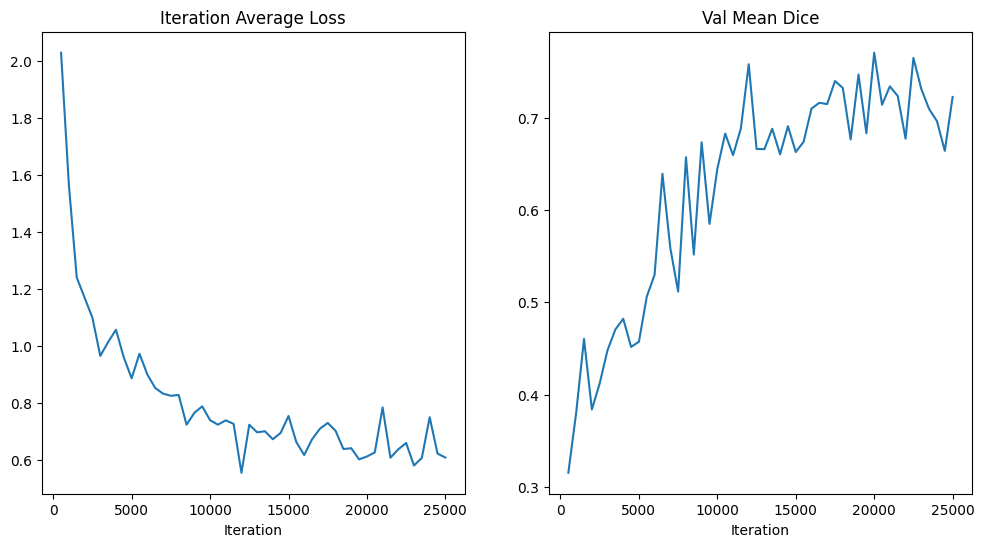

In [9]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [7]:
#test
test = torch.randn(4, 1, 96, 96, 96).cuda()
output = model(test)

x_in vit torch.Size([4, 1, 96, 96, 96])
x_in affter embed torch.Size([4, 216, 384])
torch.Size([4, 216, 384])


In [4]:
#inference MMH
#导入用到得module
import os
import shutil
import numpy as np
import itk
from PIL import Image
import tempfile
from monai.data import ITKReader, PILReader
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose,Invertd,AsDiscreted, SaveImaged,
)
from monai.handlers.utils import from_engine

from monai.config import print_config

from monai.inferers import sliding_window_inference
from monai.data import NiftiSaver

device = torch.device("cuda:0")

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [11]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
#             print(val_inputs.shape,val_labels.shape)
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [8]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=57, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|██████████████████████████| 57/57 [00:18<00:00,  3.12it/s]


In [10]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:12<00:00,  4.65it/s]

dice_val: 0.2666066586971283


In [11]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.34900960326194763


In [12]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.02it/s]

dice_val: 0.31487661600112915


In [13]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.4232094883918762


In [14]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.95it/s]

dice_val: 0.3234732747077942


In [ ]:
#inference MMH up down flip

In [23]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503_updown_flip/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
   [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)

val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors

Loading dataset: 100%|██████████████████████████| 57/57 [00:19<00:00,  2.93it/s]


In [24]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  4.91it/s]

dice_val: 0.2643609642982483


In [25]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.07it/s]

dice_val: 0.30316197872161865


In [26]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.06it/s]

dice_val: 0.32531973719596863


In [27]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.16it/s]

dice_val: 0.3863683342933655


In [28]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "waveunetr_concatViT_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|██████████████████| 57/57 [00:11<00:00,  5.08it/s]

dice_val: 0.3078237771987915


In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=384,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [6]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

In [7]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [9]:
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

val_transforms = Compose(
        [LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),]
)


val_files = load_decathlon_datalist(datasets, True, "validation")
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=100, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
# set_track_meta(False)

Loading dataset: 100%|████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


In [12]:
#fold0
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold0_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.87it/s]

dice_val: 0.7673020362854004


In [13]:
#fold1
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold1_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.78it/s]

dice_val: 0.7603350877761841


In [14]:
#fold2
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.86it/s]

dice_val: 0.7831133008003235


In [15]:
#fold3
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold3_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.85it/s]

dice_val: 0.7857744097709656


In [16]:
#fold4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/dwt_swinunetr_model", "frequency_unetr_fold4_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1

epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
dice_val = validation(epoch_iterator_val)
print("dice_val:",dice_val)
# epoch_loss /= step
# epoch_loss_values.append(epoch_loss)
# metric_values.append(dice_val)

Validate (0 / 10 Steps): 100%|████████████████| 100/100 [00:20<00:00,  4.80it/s]

dice_val: 0.7703914046287537


In [5]:
#prediction
# data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/MMH_0503/'
data_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset1/'
split_json = "dataset_inf.json"
datasets = data_dir + split_json

test_files = load_decathlon_datalist(datasets, True, "validation")

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="/media/user/2tb/dataset/wordpred/frequency_unetr", output_postfix="", resample=False),
    ]
)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_num=114, cache_rate=1.0, num_workers=4)
test_ds = CacheDataset(data=test_files, transform=test_transforms, num_workers=4)
test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1)

# data = transform(img_path).to(device)

Loading dataset: 100%|████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=8,#14
    img_size=(96, 96, 96),
    feature_size=16,#16 48
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)


loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
# loss_function = DiceLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/unetr", "unetr_fold2_best_metric_model.pth")))
# model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr/swin_unetr_model", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
case_num=1
# with torch.no_grad():
# #     for case_num in range(0,114):
#     img_name = os.path.split(test_ds[case_num]["image"].meta["filename_or_obj"])[1]
#     img = test_ds[case_num]["image"]
#     test_inputs = torch.unsqueeze(img, 1).cuda()
#     test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model, overlap=0.8,sw_device="cuda")
#     test_outputs=torch.argmax(test_outputs, dim=1)
# #     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei/swinunetr_majei_output',output_ext=img_name)
#     saver=NiftiSaver(output_dir='/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/datasetmajei',output_ext=img_name)
#     saver.save(test_outputs

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]
#         test_output = from_engine(["pred"])(test_data)


with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_data["pred"] = sliding_window_inference(test_inputs, (96,96,96), 4, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)


RuntimeError: applying transform <monai.transforms.post.dictionary.Invertd object at 0x7f1b7ade47d0>